# **Impressionist Classifier Project**
The aim of this project is to build a multi-class classifier for 5 impressionist painters, namely: Camille Pisarro, Claude Monet, Henri Matisse, John Singer-Sargent , and Vincent van Gogh.

The Data set is downloaded from:
https://www.kaggle.com/datasets/delayedkarma/impressionist-classifier-data

It is already devided into the train and validation sets, with 400 train images and 100 validation images respectively for each of the 10 artists.

# ***PROJECT OUTLINE***


1.   Prepare the Data
2.   Build training functions and basic CNN
3.   Train CNN called Arti and show results
4.   Train CNN with dropout called Dropi and show results
5.   Use Ensemble Voting and show results
6.   Train an untrained RESNET from torchvision.models and compare results
7.   Train a pretrained RESNET from torchvision.models and show results
8.   Conclusions
9.   Summery







In [1]:
# @title
#################################### IMPORTS ####################################
%pip install opencv-python
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile
import pandas
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import torch.optim as optim
import itertools
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, ReLU
import cv2

In [2]:
# @title
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the GPU")

else:
    device = torch.device("cpu")

Using the GPU


# ***1. Prepare the Data***
To prepare the data we need to:

  A.   Load it from kaggle to content

  B.   Load it from content to variables as np arrays and create matching ground truth

  C. Resize all the images to the same dimensions (512,512,3)



#A. Load data set from kaggle to content without doanload
This is done without direct download to your computer or using google drive.
Follow the instructions in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
Make sure to use and upload the kaggle.json file

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d delayedkarma/impressionist-classifier-data

100% 2.18G/2.19G [01:58<00:00, 22.4MB/s]
100% 2.19G/2.19G [01:58<00:00, 19.9MB/s]


In [5]:
! unzip impressionist-classifier-data

Archive:  impressionist-classifier-data.zip
  inflating: training/training/Cezanne/215457.jpg  
  inflating: training/training/Cezanne/215458.jpg  
  inflating: training/training/Cezanne/215459.jpg  
  inflating: training/training/Cezanne/215460.jpg  
  inflating: training/training/Cezanne/215462.jpg  
  inflating: training/training/Cezanne/215463.jpg  
  inflating: training/training/Cezanne/215466.jpg  
  inflating: training/training/Cezanne/215467.jpg  
  inflating: training/training/Cezanne/215468.jpg  
  inflating: training/training/Cezanne/215469.jpg  
  inflating: training/training/Cezanne/215470.jpg  
  inflating: training/training/Cezanne/215471.jpg  
  inflating: training/training/Cezanne/215473.jpg  
  inflating: training/training/Cezanne/215474.jpg  
  inflating: training/training/Cezanne/215475.jpg  
  inflating: training/training/Cezanne/215476.jpg  
  inflating: training/training/Cezanne/215477.jpg  
  inflating: training/training/Cezanne/215478.jpg  
  inflating: trainin

#B. Load it from content to variables as np arrays and create matching ground truth
Create XT, ST , VT, STVT.

XT - training images.

ST - training ground truth.

VT - validation images.

STVT - validation ground truth.

In [6]:
artists_train = [[],[],[],[],[]]
artists_valid = [[],[],[],[],[]]
folder_path_train = '/content/training/training'
folder_path_validation = '/content/validation/validation'
artist_names = ['Matisse', 'Monet', 'Pissarro', 'Sargent','VanGogh']

not_used_names = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Renoir']
num_of_imgs = 400

for idx,artist in enumerate(artist_names):
    folder_path = os.path.join(folder_path_validation, artist)
    image_artist = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    i=0
    for filename in image_artist:
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path)
        img = np.array(img)
        if   len(img.shape) != 3 : continue
        img = img[:, :, :3]            # remove the alpha channel

        artists_valid[idx].append(img)
        i = i + 1
        if i > 100 :
          break



for idx,artist in enumerate(artist_names):
    folder_path = os.path.join(folder_path_train, artist)
    image_artist = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    i=0
    for filename in image_artist:
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path)
        img = np.array(img)
        if   len(img.shape) != 3 : continue
        img = img[:, :, :3]            # remove the alpha channel
        artists_train[idx].append(img)

        i = i + 1
        if i > num_of_imgs :
          break


<ipython-input-7-be69cf8ebeec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  artists_valid = np.array(artists_valid)
<ipython-input-7-be69cf8ebeec>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  artists_train = np.array(artists_train)


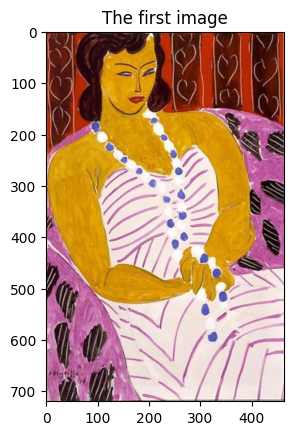

In [7]:
artists_valid = np.array(artists_valid)
artists_train = np.array(artists_train)
# Display the first image
plt.figure()
plt.imshow(artists_train[0][0])
plt.title("The first image")
plt.show()
print("Artists_Train.shape=",artists_train.shape)
print("artists_valid.shape=",artists_valid.shape)

In [8]:
# Create one-hot encoding for the artists
num_artists = len(artist_names)
one_hot_encoding = np.eye(num_artists)  # Generates a diagonal matrix with 1s on the diagonal

# Initialize lists to store training data
xt = []
st = []
vt = []
vtst = []

# Iterate through the artists and their corresponding images
for i, artist_images in enumerate(artists_train):
    artist_label = one_hot_encoding[i]  # Get the one-hot label for the artist
    for image in artist_images:
        #normalized_image = (image - channel_means) / channel_stds
        xt.append(image)  # Append the image to the training data
        st.append(artist_label)  # Append the one-hot label to the training labels

for i, artist_images in enumerate(artists_valid):
    artist_label = one_hot_encoding[i]  # Get the one-hot label for the artist
    for image in artist_images:
        #normalized_image = (image - channel_means) / channel_stds
        vt.append(image)  # Append the image to the training data
        vtst.append(artist_label)  # Append the one-hot label to the training labels


# Convert the lists to NumPy arrays
xt = np.array(xt)
st = np.array(st)
vt = np.array(vt)
vtst = np.array(vtst)
print("vt.shape=",vt.shape)
# xt now contains your training images, and st contains the corresponding one-hot labels
# You can use these arrays for training your model


Artists_Train.shape= (5,)
artists_valid.shape= (5,)
vt.shape= (493,)


<ipython-input-8-5e15beada742>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xt = np.array(xt)
<ipython-input-8-5e15beada742>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vt = np.array(vt)


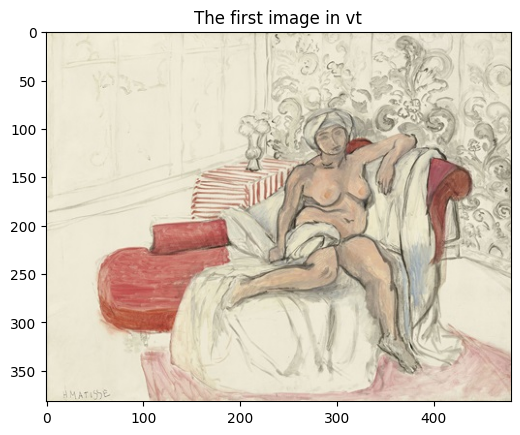

In [9]:
plt.figure()
plt.imshow(vt[0])
plt.title("The first image in vt")
plt.show()

#Delete what you can

In [10]:
del artists_train, artists_valid

In [11]:
del artist_images,artist_label

In [12]:
print("vt.shape=",vt.shape)
print("xt.shape=",xt.shape)

vt.shape= (493,)
xt.shape= (1989,)


#C. Resize all the images to the same dimensions (512,512,3)
We need to resize and fit all the paintings to the same scale (512,512,3).
We are going to use Image from PIL.

In [13]:
from PIL import Image

# Assuming you have a NumPy array `xt` containing images
# Define the target size
target_size = (512, 512) #(224,224) - Later use for ResNet18

# Create an empty array to store the resized and cropped images
resized_images = []

# Iterate through the images in `xt` and resize them to the target size
for image in xt:
    current_height, current_width, channels = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / current_width
    height_scale = target_size[1] / current_height

    # Choose the maximum scaling factor that still fits within the target size
    scale_factor = max(width_scale, height_scale)

    # Calculate the new dimensions after resizing
    new_width = int(current_width * scale_factor)
    new_height = int(current_height * scale_factor)

    # Resize the image using the calculated dimensions
    resized_image = Image.fromarray((image).astype(np.uint8))
    resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)

    # Calculate the crop box to get the center portion of the resized image
    left = (new_width - target_size[0]) / 2
    top = (new_height - target_size[1]) / 2
    right = (new_width + target_size[0]) / 2
    bottom = (new_height + target_size[1]) / 2

    # Crop the resized image to the target size
    cropped_image = resized_image.crop((left, top, right, bottom))

    # Convert the cropped image back to a NumPy array
    cropped_image = np.array(cropped_image)

    # Append the resized and cropped image to the result
    resized_images.append(cropped_image)

# Convert the list of resized and cropped images back to a NumPy array
xt = np.array(resized_images)
del resized_images


<ipython-input-13-f06c4a0eba6f>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)


Same but for validation data:

In [14]:
from PIL import Image

# Assuming you have a NumPy array `xt` containing images
# Define the target size
target_size = (512, 512) #(224,224) - Later use for ResNet18

# Create an empty array to store the resized and cropped images
resized_images = []

# Iterate through the images in `xt` and resize them to the target size
for image in vt:
    current_height, current_width, channels = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / current_width
    height_scale = target_size[1] / current_height

    # Choose the maximum scaling factor that still fits within the target size
    scale_factor = max(width_scale, height_scale)

    # Calculate the new dimensions after resizing
    new_width = int(current_width * scale_factor)
    new_height = int(current_height * scale_factor)

    # Resize the image using the calculated dimensions
    resized_image = Image.fromarray((image).astype(np.uint8))
    resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)

    # Calculate the crop box to get the center portion of the resized image
    left = (new_width - target_size[0]) / 2
    top = (new_height - target_size[1]) / 2
    right = (new_width + target_size[0]) / 2
    bottom = (new_height + target_size[1]) / 2

    # Crop the resized image to the target size
    cropped_image = resized_image.crop((left, top, right, bottom))

    # Convert the cropped image back to a NumPy array
    cropped_image = np.array(cropped_image)

    # Append the resized and cropped image to the result
    resized_images.append(cropped_image)

# Convert the list of resized and cropped images back to a NumPy array
vt = np.array(resized_images)
del resized_images


<ipython-input-14-51cc7f94c2dc>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)


Validate the dimension of XT, VT:

In [15]:
print("vt.shape=",vt.shape)
print("xt.shape=",xt.shape)

vt.shape= (493, 512, 512, 3)
xt.shape= (1989, 512, 512, 3)


# ***2. Build training functions and basic CNN***

In [16]:
class Art_NN(nn.Module):
    def __init__(self, n=6):
        super(Art_NN, self).__init__()
        self.n_feature = n
        self.kernel_size = 3
        self.padding = (self.kernel_size-1)//2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv2 = nn.Conv2d(n,n*2, kernel_size=self.kernel_size, padding=self.padding)
        self.conv3 = nn.Conv2d(2*n,4*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv4 = nn.Conv2d(4*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv5 = nn.Conv2d(8*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv6 = nn.Conv2d(8*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv7 = nn.Conv2d(8*n,4*n, kernel_size=self.kernel_size, padding=self.padding)


        self.fc1 = nn.Linear(8*n*8*8, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 5)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu= nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.layernorm1 = nn.LayerNorm(normalized_shape=8*n, eps=1e-6)

    def forward(self, x):


        x = x - 128
        #input size (batch, 3, 512, 512)

        x = self.conv1(x) # x size = (batch, n, 512, 512)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, n, 256, 256)

        x = self.conv2(x) # x size = (batch, 2n, 256, 256)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 2n, 128, 128)

        x = self.conv3(x) # x size = (batch, 4n, 128, 128)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 4n, 64, 64)

        x = self.conv4(x) # x size = (batch, 8n, 64, 64)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 32, 32)

        x = self.conv5(x) # x size = (batch, 8n, 32, 32)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 16, 16)

        x = self.conv6(x) # x size = (batch, 8n, 16, 16)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 8, 8)


        # Assuming your tensor is named 'input_tensor'
        batch_size, _, height, width = x.size()

        # Reshape the tensor
        y = x.view(batch_size, -1, height * width).transpose(1, 2) # x size = (batch, 64, 48)


##### FULLY CONNECTED LAYERS
        y = y.reshape(-1, self.n_feature*8*8*8)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)
        y = self.softmax(y)

        return y

Build the same NN class but with dropout layers implemented to try and avoid overfitting

In [91]:
class Dropi_Art_NN(nn.Module):
    def __init__(self, n=6):
        super(Dropi_Art_NN, self).__init__()
        self.n_feature = n
        self.kernel_size = 3
        self.padding = (self.kernel_size-1)//2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv2 = nn.Conv2d(n,n*2, kernel_size=self.kernel_size, padding=self.padding)
        self.conv3 = nn.Conv2d(2*n,4*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv4 = nn.Conv2d(4*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv5 = nn.Conv2d(8*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv6 = nn.Conv2d(8*n,8*n, kernel_size=self.kernel_size, padding=self.padding)
        self.conv7 = nn.Conv2d(8*n,4*n, kernel_size=self.kernel_size, padding=self.padding)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)


        self.fc1 = nn.Linear(8*n*8*8, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 5)


        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu= nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


        self.layernorm1 = nn.LayerNorm(normalized_shape=[3, 512, 512])
        self.layernorm2 = nn.LayerNorm(normalized_shape=[2*n, 128, 128])
        self.layernorm3 = nn.LayerNorm(normalized_shape=[8*n, 32, 32])


    def forward(self, x):

        #input size (batch, 3, 512, 512)
        ###### Norm #########
        x = self.layernorm1(x)

        x = self.conv1(x) # x size = (batch, n, 512, 512)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, n, 256, 256)

        x = self.conv2(x) # x size = (batch, 2n, 256, 256)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 2n, 128, 128)

        ###### Norm #########
        x = self.layernorm2(x)

        x = self.conv3(x) # x size = (batch, 4n, 128, 128)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 4n, 64, 64)

        x = self.conv4(x) # x size = (batch, 8n, 64, 64)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 32, 32)

        ###### Norm #########
        x = self.layernorm3(x)

        x = self.conv5(x) # x size = (batch, 8n, 32, 32)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 16, 16)

        x = self.conv6(x) # x size = (batch, 8n, 16, 16)
        x = self.relu(x)
        x = self.pool(x) # x size = (batch, 8n == 48, 8, 8)


        # Assuming your tensor is named 'input_tensor'
        batch_size, _, height, width = x.size()

        # Reshape the tensor
        y = x.view(batch_size, -1, height * width).transpose(1, 2) # x size = (batch, 64, 48)


##### FULLY CONNECTED LAYERS
        y = y.reshape(-1, self.n_feature*8*8*8)
        ###### Drop Out #########
        y = self.dropout1(y)
        y = self.fc1(y)
        y = self.relu(y)
        ###### Drop Out #########
        y = self.dropout2(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)
        y = self.softmax(y)

        return y

# Create a Confusion Matrix Tracker Class
We will use this class to visualize model performance metrics over time. It will help us to understand how the model is learning and improving.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Accuracy: 0.8
Precision: 0.7


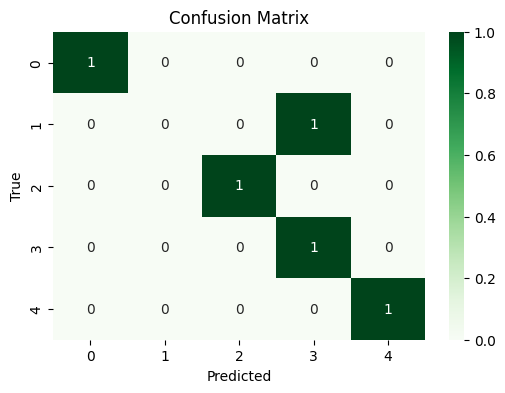

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

class ConfusionMatrixTracker():
    def __init__(self,color_choice):
        self.y_true = []
        self.y_pred = []
        self.color_choice = color_choice

    def update(self, y_true, y_pred):
        batch_y_true = np.argmax(y_true, axis=1)
        batch_y_pred = np.argmax(y_pred, axis=1)
        self.y_true.extend(batch_y_true)
        self.y_pred.extend(batch_y_pred)

    def calculate_metrics(self):
        cm = confusion_matrix(self.y_true, self.y_pred)
        accuracy = accuracy_score(self.y_true, self.y_pred)
        precision = precision_score(self.y_true, self.y_pred, average='weighted')
        recall = recall_score(self.y_true, self.y_pred, average='weighted')
        f1 = f1_score(self.y_true, self.y_pred, average='weighted')
        return cm, accuracy, precision, recall, f1

    def plot_confusion_matrix(self):
        cm, _, _, _, _ = self.calculate_metrics()
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap= self.color_choice, xticklabels=set(self.y_true), yticklabels=set(self.y_true))
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

# Example usage:
confusion_tracker = ConfusionMatrixTracker("Greens")

# Assuming you have batches of true and predicted labels

batch_y_true = np.array([[0, 1, 0, 0, 0],
                         [1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0],
                         [0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 1]])

batch_y_pred = np.array([[0.1, 0, 0.1, 0.9, 0.0],
                         [0.7, 0.2, 0.1, 0.0, 0.0],
                         [0.0, 0.0, 0.9, 0.1, 0.0],
                         [0.0, 0.0, 0.0, 0.9, 0.1],
                         [0.0, 0.1, 0.0, 0.0, 0.9]])


confusion_tracker.update(batch_y_true, batch_y_pred)

# You can update the tracker with more batches if needed

# Calculate and display metrics
cm, accuracy, precision, recall, f1 = confusion_tracker.calculate_metrics()
print("Confusion Matrix:")
print(cm)
print("\nAccuracy:", accuracy)
print("Precision:", precision)

# Visualize confusion matrix
confusion_tracker.plot_confusion_matrix()


Create get_accuracy function for estimating the accuracy of the model on the data.

In [27]:
def get_accuracy(model, xt_data, st_data,color_choice="Blues", batch_size=10, max_N=20):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    confusion_tracker = ConfusionMatrixTracker(color_choice)
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct = 0
    N = 0
    shuff_index=np.random.permutation(len(xt_data))
    xt_data=xt_data[shuff_index]
    xt_data = torch.Tensor(xt_data).to(device)
    st_data=st_data[shuff_index]
    st_data= torch.Tensor(st_data).to(device)
    val_losses =[]
    for i in range(0, xt_data.shape[0], batch_size):
        # forward pass prediction
        XTD = torch.Tensor(xt_data[i:i+batch_size]).transpose(1, 3).transpose(2,3)
        y = model(XTD)
        st_ac = st_data[i:i+batch_size]
        val_loss = criterion(y,torch.Tensor(st_ac))
        val_cost = float(val_loss.detach().cpu().numpy())
        val_losses.append(float(val_cost))
        y = y.detach().cpu().numpy() # convert the PyTorch tensor => numpy array
        st_ac = st_ac.cpu().numpy()
        confusion_tracker.update(st_ac, y)
        #pred = np.argmax(y, axis=1)
        correct += np.sum(np.argmax(y, axis=1) == np.argmax(st_ac, axis=1))
        #print("correct =" , correct)
        N += y.shape[0]

        if N > max_N:
            break
    cm, accuracy, precision, recall, f1 = confusion_tracker.calculate_metrics()
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    # Visualize confusion matrix
    confusion_tracker.plot_confusion_matrix()
    #print("break N=", N)
    avrege_loss = sum(val_losses)/len(val_losses)
    return correct / N,avrege_loss

Create the training function in code.

The criterion will be cross Entropy loss, and will use ADAM optimizer. At the end of every epoch it will print an evaluation of the models performance by confusion matrix.

In [28]:
def run_pytorch_gradient_descent(model, vt, vtst,
                                 xt,
                                 st,
                                 N_epochs=10,
                                 batch_size=10,
                                 learning_rate=0.001,
                                 weight_decay=0,beta1=0.9, beta2=0.999,
                                 max_iters=2000,
                                 checkpoint_path=None):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                           betas = (beta1,beta2),
                          weight_decay=weight_decay
                           )
    parameter=[learning_rate,weight_decay,batch_size,N_epochs]
    iters, losses, val_losses = [], [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    train_losses =[]
    n = 0 # the number of iterations

    while True:
        for epoch in range(N_epochs+1):
            #each epoch shuffel the train_data
            shuff_index=np.random.permutation(len(xt))
            xt = xt[shuff_index]
            st = st[shuff_index]
            for i in range(0, xt.shape[0], batch_size):
                XT = xt[i:i+batch_size]
                ST = st[i:i+batch_size]
                XT = torch.Tensor(XT).transpose(1, 3).transpose(2,3) #from [n,1024,1024,3] to [n,3,1024,1024]
                ST = torch.Tensor(ST)
                XT = XT.to(device)
                ST = ST.to(device)



                zs =  model(XT)          # compute prediction logit
                loss = criterion(zs,ST)  # compute the total loss
                loss.backward()          # compute updates for each parameter
                optimizer.step()         # make the updates for each parameter
                optimizer.zero_grad()    # a clean up step for PyTorch

                # save the current training information
                #val_acc_pos, val_acc_neg, val_loss = get_accuracy(model, validation_data)
                iters.append(n)
                losses.append(float(loss))  # compute *average* loss -  ABORT - NO NEED TO NORMALIZE BY /batch_size

                #val_losses.append(val_loss)
                # increment the iteration number
                n += 1
                #print("n=",n, "i=",i,"batch=",batch_size)

            #after each epoch make validation test:
            iters_sub.append(n)
            train_cost = float(loss.detach().cpu().numpy())
            train_losses.append(train_cost)
            print("****************Train****************")
            train_acc, _ = get_accuracy(model, xt, st,"Blues",20,20)
            train_accs.append(train_acc)
            print("****************Validation****************")
            val_acc, val_loss = get_accuracy(model,vt,vtst,"Greens" ,20,20)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print("epoch %d , Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%] [Train Loss %f, Validation loss %f]" % (
                     epoch, n, val_acc*100, train_acc * 100, train_cost,val_loss))
            torch.save(model.state_dict(), checkpoint_path.format(n))
            #if (checkpoint_path is not None) and n > 0 and (val_acc > 0.35 or val_loss < 1.4) :
            #    torch.save(model.state_dict(), checkpoint_path.format(n))

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs, val_losses

        return  iters, losses, iters_sub, train_accs, val_accs, val_losses


Create a function meant to plot the "Learning Curve: Loss per Iteration" and "Learning Curve: Accuracy per Iteration".

In [21]:

def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs,val_losses):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters_sub, val_losses, label="Validation",color='red')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    """
    Plot the validation learning curve.
    """
    plt.title("validation Learning Curve: Loss per Iteration")
    plt.plot(iters_sub, val_losses, label="vali")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# ***3. Train CNN called Arti and show results***

In [148]:
Arti = Art_NN(n=6)
Arti.to(device)

Art_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layernorm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
)

In [23]:
print(Arti)

Art_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layernorm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
)


****************Train****************

Accuracy: 0.375
Precision: 0.56875
Recall: 0.375


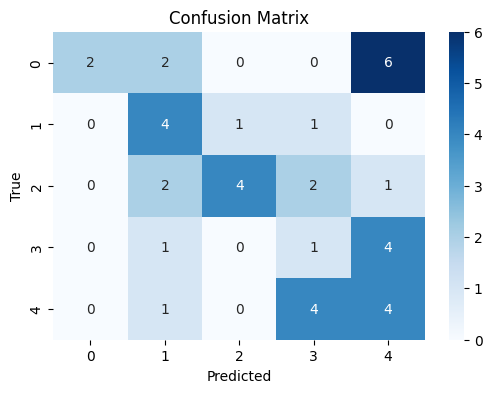

****************Validation****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.55
Precision: 0.4585737179487179
Recall: 0.55


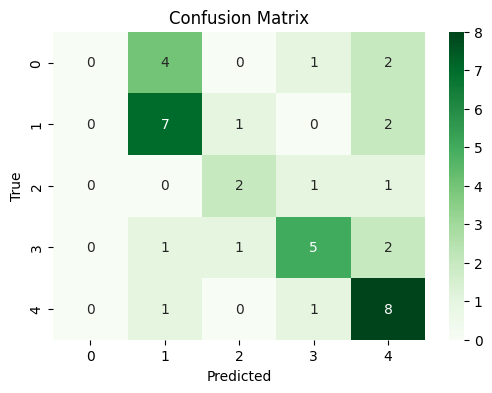

epoch 0 , Iter 100. [Val Acc 55%] [Train Acc 38%] [Train Loss 1.139730, Validation loss 1.375202]
****************Train****************

Accuracy: 0.475
Precision: 0.4905952380952381
Recall: 0.475


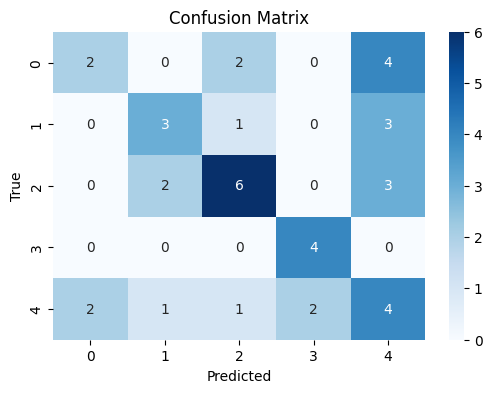

****************Validation****************

Accuracy: 0.45
Precision: 0.466656746031746
Recall: 0.45


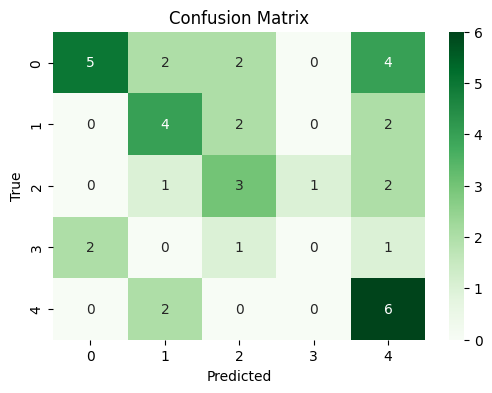

epoch 1 , Iter 200. [Val Acc 45%] [Train Acc 48%] [Train Loss 1.420117, Validation loss 1.421778]
****************Train****************

Accuracy: 0.45
Precision: 0.449375
Recall: 0.45


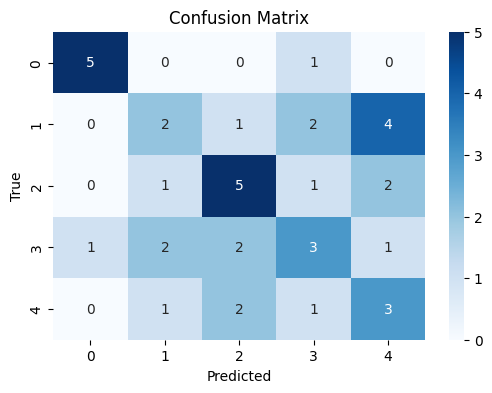

****************Validation****************

Accuracy: 0.575
Precision: 0.614375
Recall: 0.575


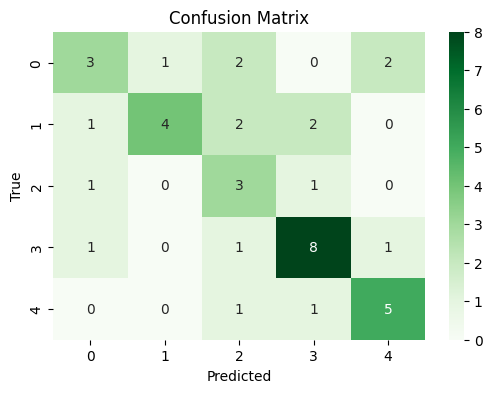

epoch 2 , Iter 300. [Val Acc 57%] [Train Acc 45%] [Train Loss 1.386673, Validation loss 1.337582]
****************Train****************

Accuracy: 0.65
Precision: 0.6483974358974359
Recall: 0.65


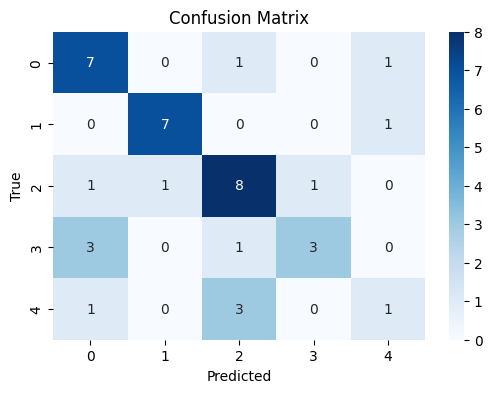

****************Validation****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.375
Precision: 0.33666666666666667
Recall: 0.375


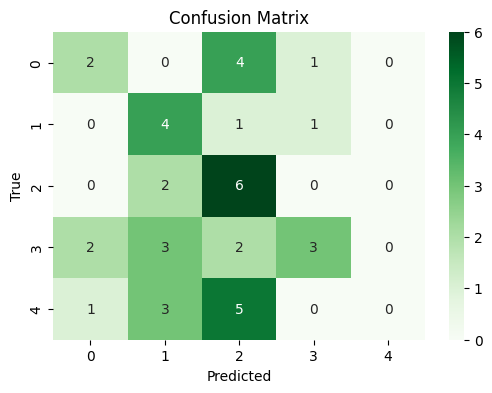

epoch 3 , Iter 400. [Val Acc 38%] [Train Acc 65%] [Train Loss 1.358406, Validation loss 1.485984]
****************Train****************

Accuracy: 0.525
Precision: 0.5165151515151516
Recall: 0.525


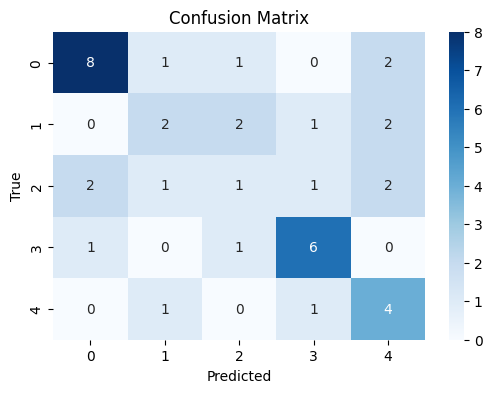

****************Validation****************

Accuracy: 0.475
Precision: 0.5269047619047618
Recall: 0.475


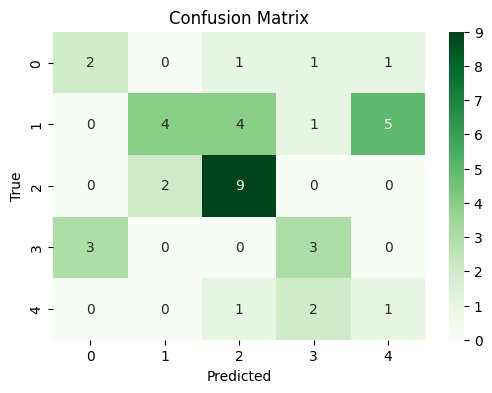

epoch 4 , Iter 500. [Val Acc 48%] [Train Acc 52%] [Train Loss 1.308004, Validation loss 1.405862]
****************Train****************

Accuracy: 0.625
Precision: 0.7415178571428571
Recall: 0.625


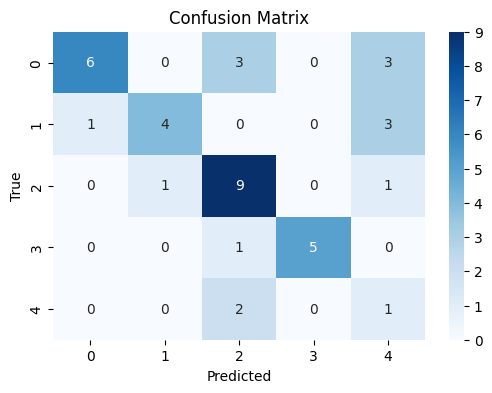

****************Validation****************

Accuracy: 0.5
Precision: 0.5285256410256409
Recall: 0.5


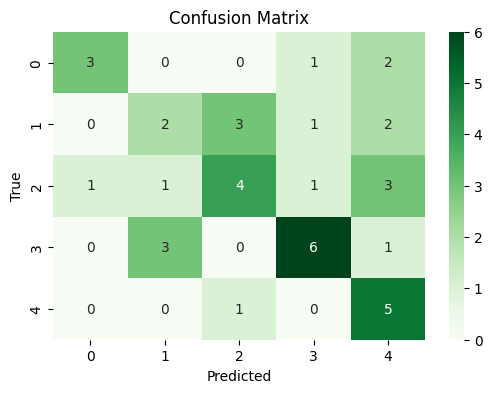

epoch 5 , Iter 600. [Val Acc 50%] [Train Acc 62%] [Train Loss 1.254917, Validation loss 1.378979]
****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.625
Precision: 0.5587179487179487
Recall: 0.625


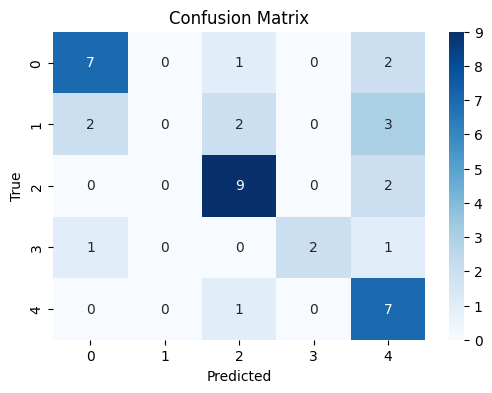

****************Validation****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.6
Precision: 0.5552083333333334
Recall: 0.6


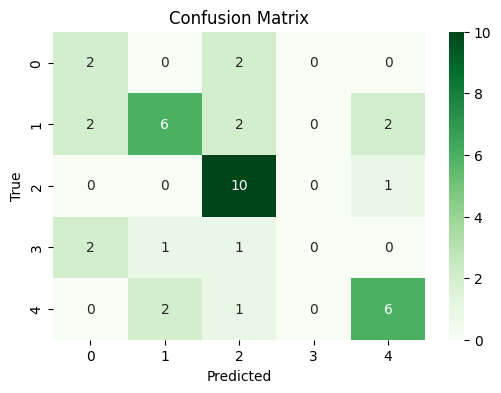

epoch 6 , Iter 700. [Val Acc 60%] [Train Acc 62%] [Train Loss 1.345312, Validation loss 1.318926]
****************Train****************

Accuracy: 0.625
Precision: 0.7027777777777777
Recall: 0.625


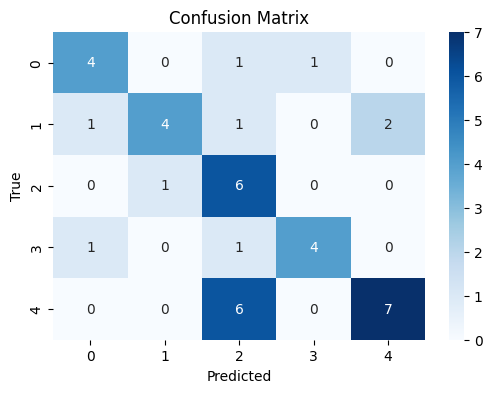

****************Validation****************

Accuracy: 0.575
Precision: 0.5757575757575758
Recall: 0.575


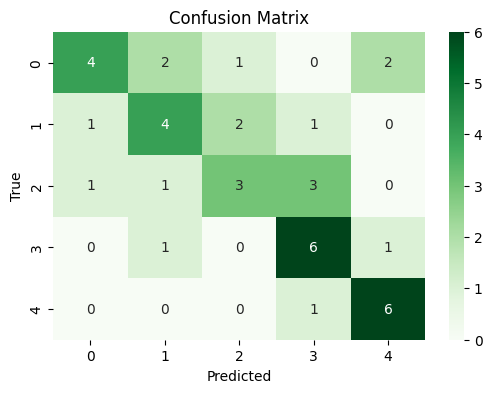

epoch 7 , Iter 800. [Val Acc 57%] [Train Acc 62%] [Train Loss 1.443325, Validation loss 1.324111]
****************Train****************

Accuracy: 0.55
Precision: 0.6972222222222222
Recall: 0.55


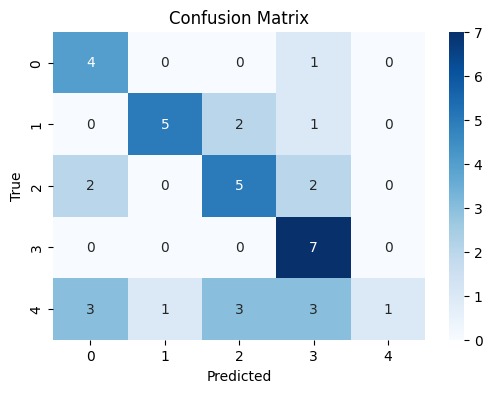

****************Validation****************

Accuracy: 0.525
Precision: 0.6909226190476191
Recall: 0.525


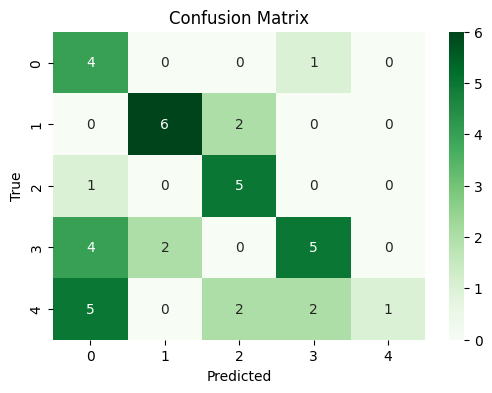

epoch 8 , Iter 900. [Val Acc 52%] [Train Acc 55%] [Train Loss 1.342801, Validation loss 1.352419]
****************Train****************

Accuracy: 0.625
Precision: 0.640827922077922
Recall: 0.625


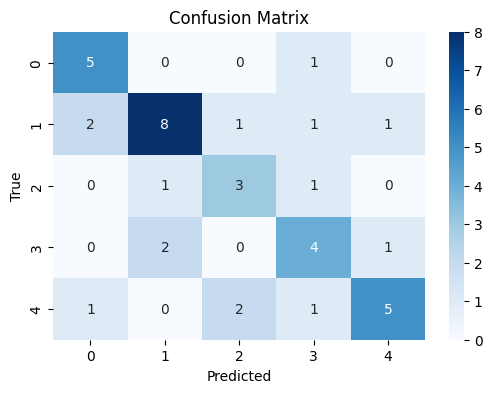

****************Validation****************

Accuracy: 0.475
Precision: 0.5132400932400932
Recall: 0.475


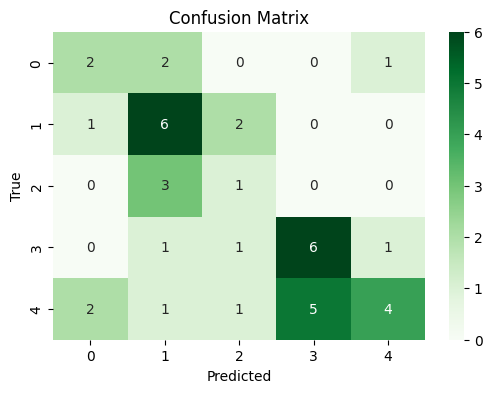

epoch 9 , Iter 1000. [Val Acc 48%] [Train Acc 62%] [Train Loss 1.356894, Validation loss 1.425186]
****************Train****************

Accuracy: 0.425
Precision: 0.5409294871794872
Recall: 0.425


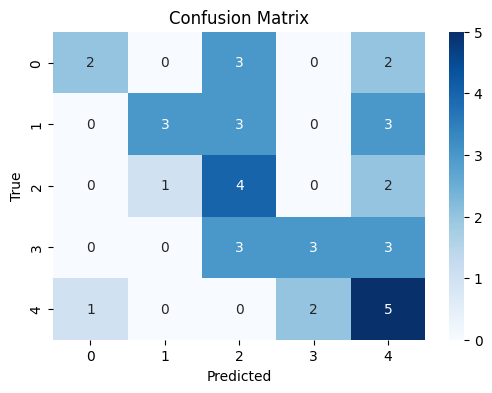

****************Validation****************

Accuracy: 0.625
Precision: 0.6708270676691729
Recall: 0.625


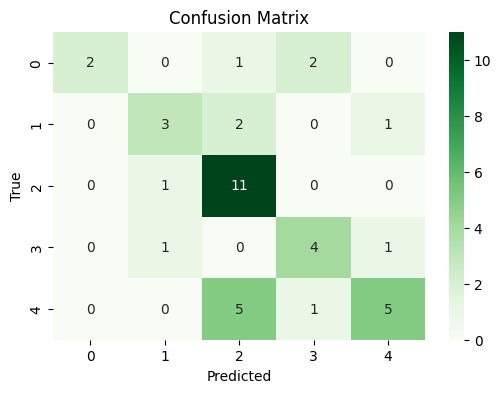

epoch 10 , Iter 1100. [Val Acc 62%] [Train Acc 42%] [Train Loss 1.404053, Validation loss 1.319979]


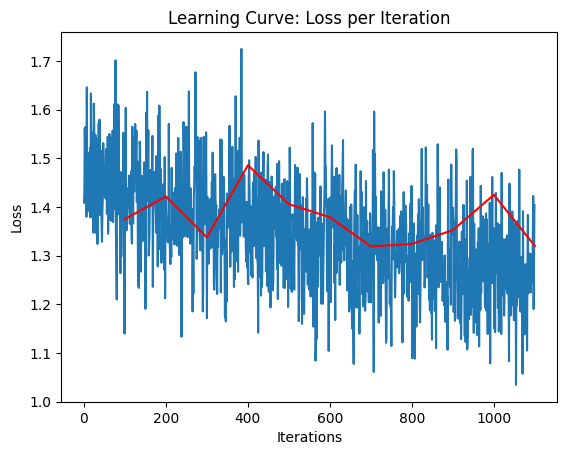

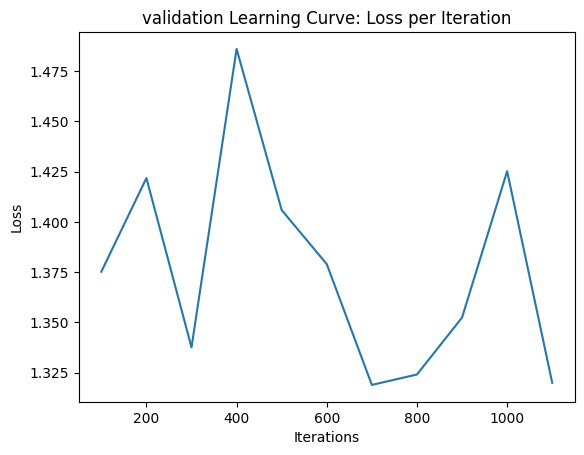

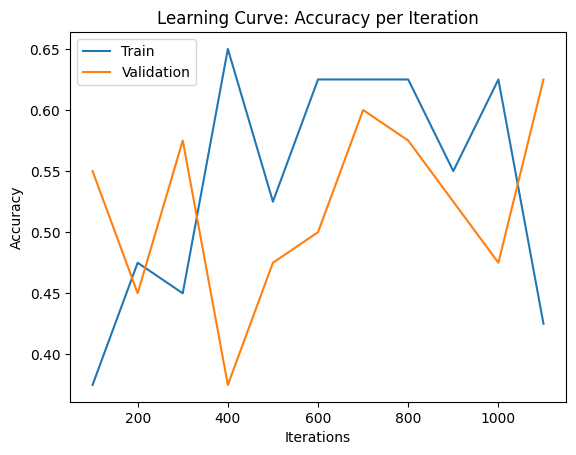

In [29]:

batch =20
m=0.0001 ## Start with higher learning rate to unable fast learning curve in the beginning
decay=0.001

learning_curve_info = run_pytorch_gradient_descent(Arti,vt, vtst, xt,st,N_epochs=10, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Weights/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

# Former Session Learning Curves

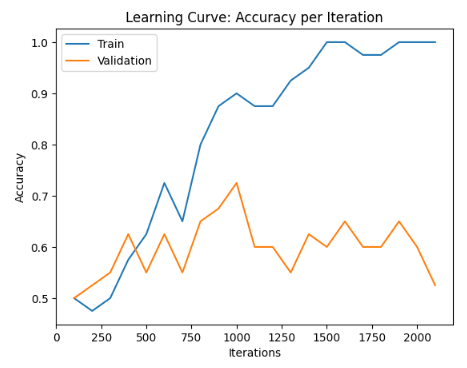

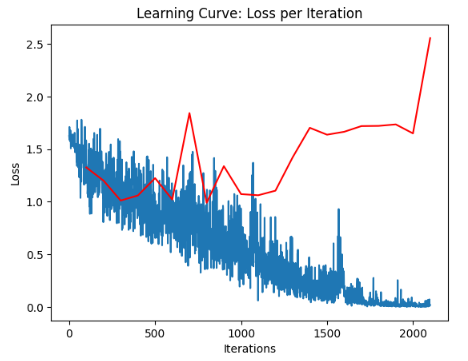

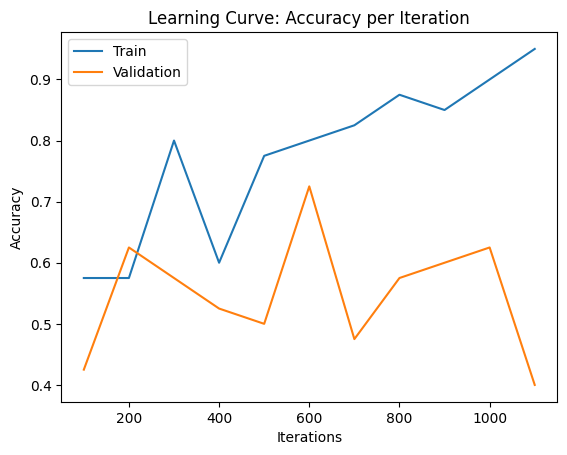

# **Outcome Discussion and Insights**

 We can see after 600 iterations at the end of epoch 5 the CNN has started to overfit to the trainig data.

 In this session, the overfitting is less visible in the learning curve. Unfortunately, when I recreated the session, I did not use 20 epochs. However, the intention can be observed in the learning curves from the previous session.

 "epoch 5 , Iter 600. [Val Acc 72%] [Train Acc 80%] [Train Loss 0.700049, Validation loss 0.776750]"

We will try and deal with this problem in 3 ways:

  A.   Utilizing Weight Decay with the ADAM Optimizer (already done).

  B.   Implement early stopping to halt training when the model's performance on the validation set stops improving. Then pick the best last weights before overfitting started and relaunch training.

  C.   Apply dropout regularization to prevent overfitting.

  D.   Experiment with ensemble methods, such as combining predictions from multiple models, to improve performance.

  E.   Use pretrained RESNET and compare results.









#B. **Implement early stopping**
 Halt training when the model's performance on the validation set stops improving. Then pick the best last weights before overfitting started and relaunch training.

****************Train****************

Accuracy: 0.675
Precision: 0.7030681818181819
Recall: 0.675


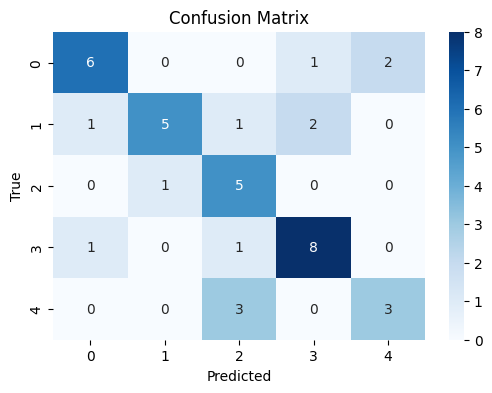

****************Validation****************

Accuracy: 0.5
Precision: 0.4928937728937729
Recall: 0.5


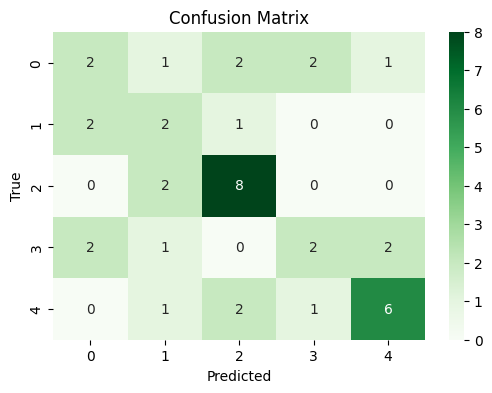

epoch 0 , Iter 100. [Val Acc 50%] [Train Acc 68%] [Train Loss 1.401009, Validation loss 1.403491]
****************Train****************

Accuracy: 0.725
Precision: 0.72875
Recall: 0.725


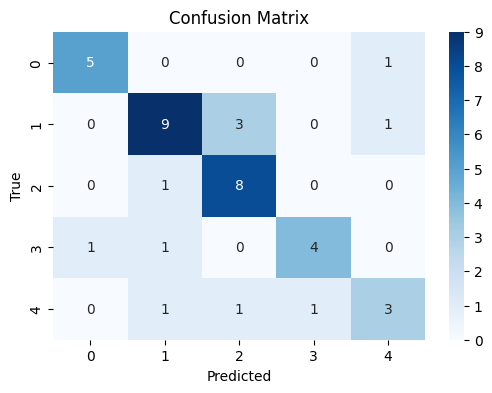

****************Validation****************

Accuracy: 0.425
Precision: 0.4383333333333333
Recall: 0.425


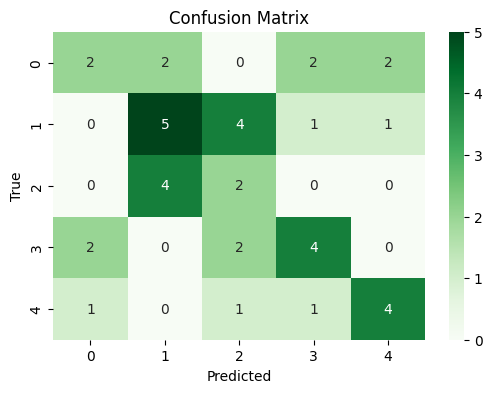

epoch 1 , Iter 200. [Val Acc 42%] [Train Acc 72%] [Train Loss 1.559507, Validation loss 1.437952]
****************Train****************

Accuracy: 0.675
Precision: 0.7888392857142856
Recall: 0.675


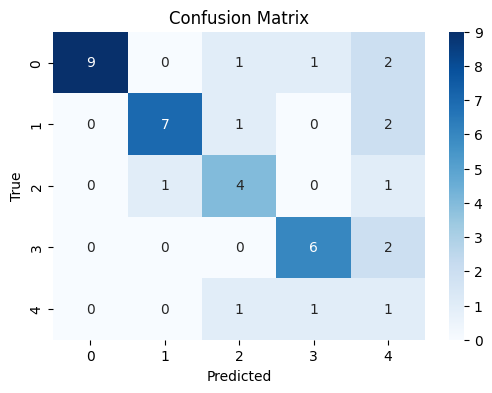

****************Validation****************

Accuracy: 0.575
Precision: 0.6291666666666667
Recall: 0.575


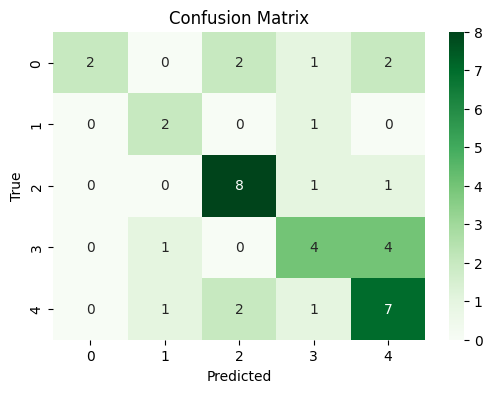

epoch 2 , Iter 300. [Val Acc 57%] [Train Acc 68%] [Train Loss 1.342144, Validation loss 1.278276]
****************Train****************

Accuracy: 0.7
Precision: 0.7539393939393939
Recall: 0.7


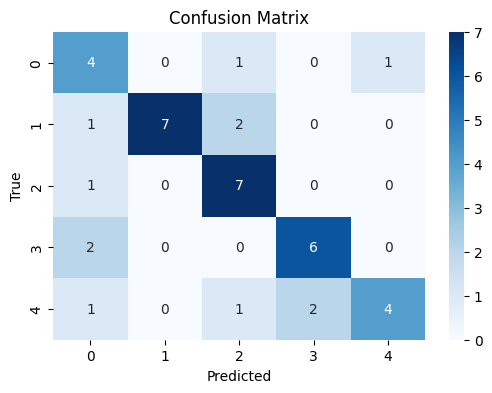

****************Validation****************

Accuracy: 0.525
Precision: 0.5415178571428572
Recall: 0.525


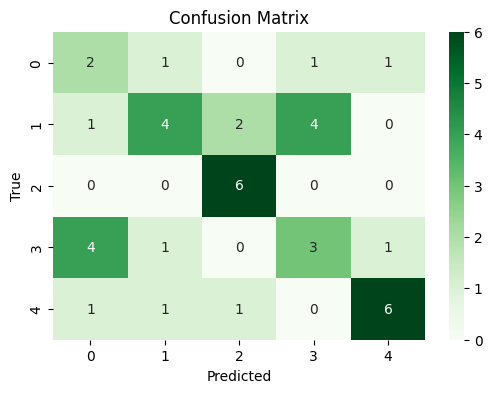

epoch 3 , Iter 400. [Val Acc 52%] [Train Acc 70%] [Train Loss 1.072273, Validation loss 1.366469]
****************Train****************

Accuracy: 0.7
Precision: 0.7617279411764706
Recall: 0.7


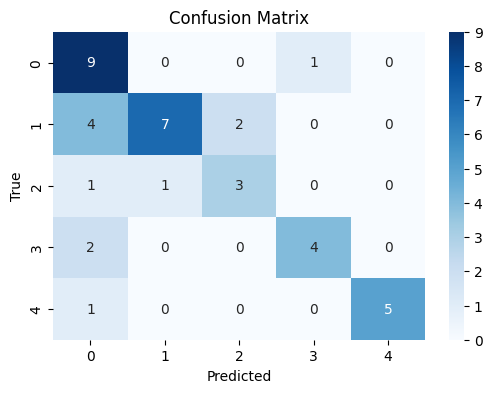

****************Validation****************

Accuracy: 0.575
Precision: 0.6926767676767678
Recall: 0.575


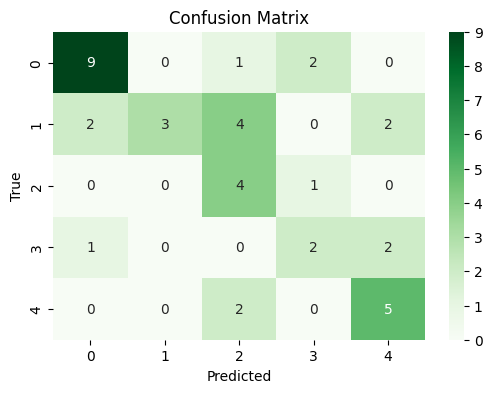

epoch 4 , Iter 500. [Val Acc 57%] [Train Acc 70%] [Train Loss 1.010591, Validation loss 1.311118]
****************Train****************

Accuracy: 0.775
Precision: 0.810873015873016
Recall: 0.775


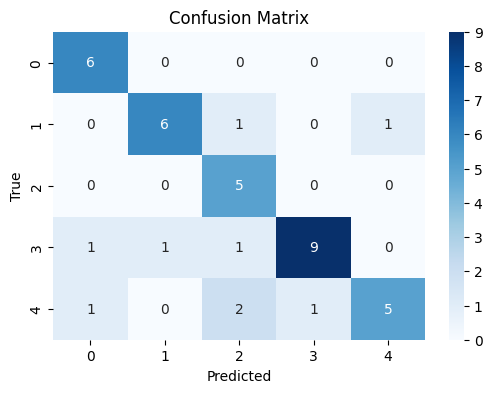

****************Validation****************

Accuracy: 0.45
Precision: 0.44375
Recall: 0.45


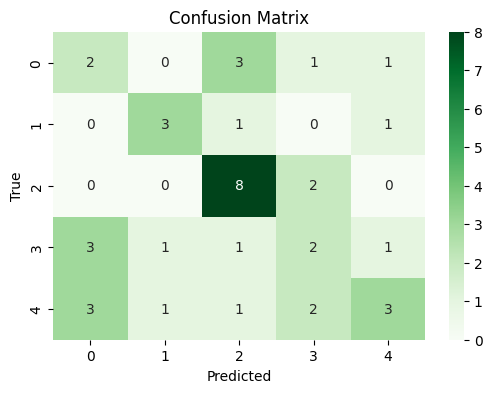

epoch 5 , Iter 600. [Val Acc 45%] [Train Acc 78%] [Train Loss 1.159832, Validation loss 1.432720]
****************Train****************

Accuracy: 0.725
Precision: 0.7419155844155844
Recall: 0.725


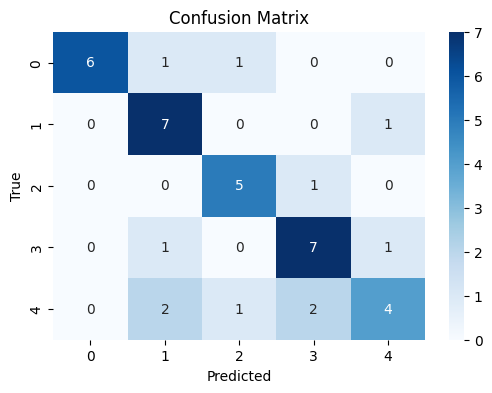

****************Validation****************

Accuracy: 0.675
Precision: 0.7722943722943724
Recall: 0.675


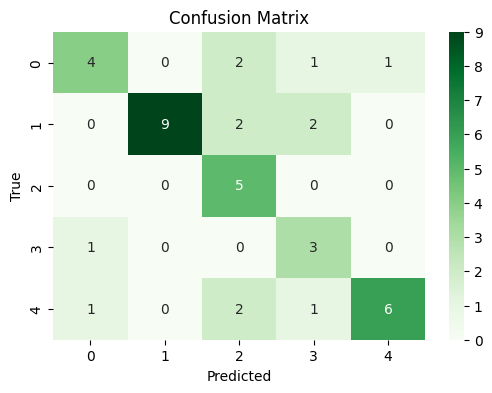

epoch 6 , Iter 700. [Val Acc 68%] [Train Acc 72%] [Train Loss 1.232468, Validation loss 1.213016]
****************Train****************

Accuracy: 0.7
Precision: 0.78
Recall: 0.7


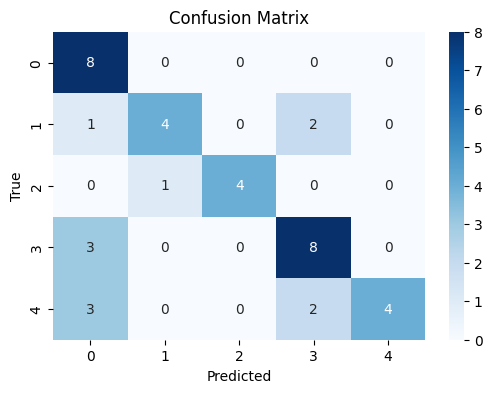

****************Validation****************

Accuracy: 0.45
Precision: 0.4928661616161616
Recall: 0.45


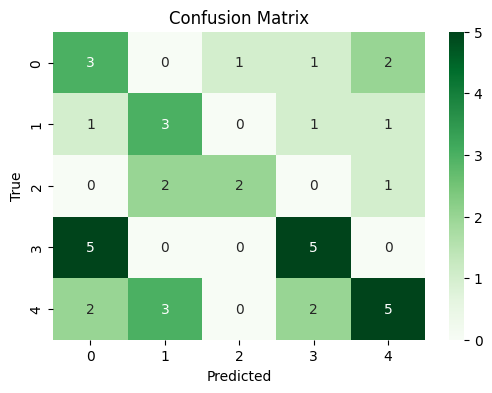

epoch 7 , Iter 800. [Val Acc 45%] [Train Acc 70%] [Train Loss 1.229122, Validation loss 1.418930]
****************Train****************

Accuracy: 0.725
Precision: 0.8090972222222224
Recall: 0.725


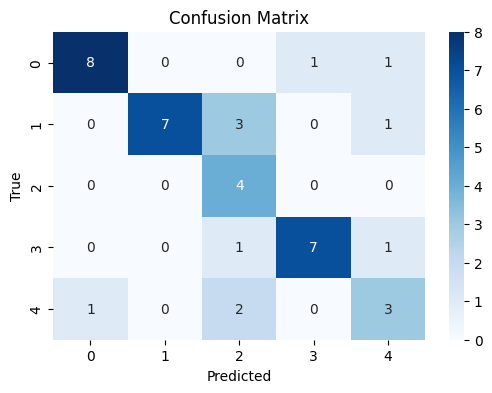

****************Validation****************

Accuracy: 0.5
Precision: 0.5533730158730159
Recall: 0.5


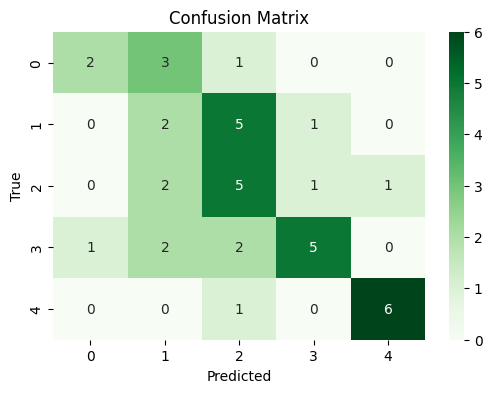

epoch 8 , Iter 900. [Val Acc 50%] [Train Acc 72%] [Train Loss 1.033472, Validation loss 1.377525]
****************Train****************

Accuracy: 0.875
Precision: 0.9102678571428571
Recall: 0.875


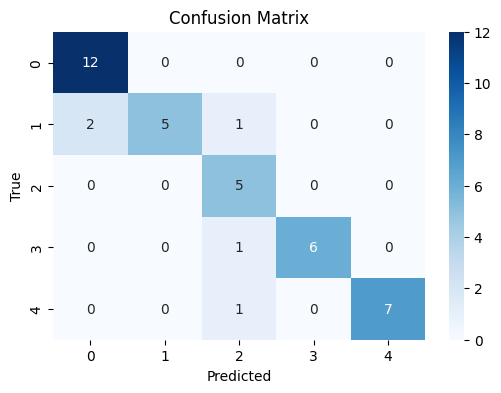

****************Validation****************

Accuracy: 0.525
Precision: 0.5357142857142858
Recall: 0.525


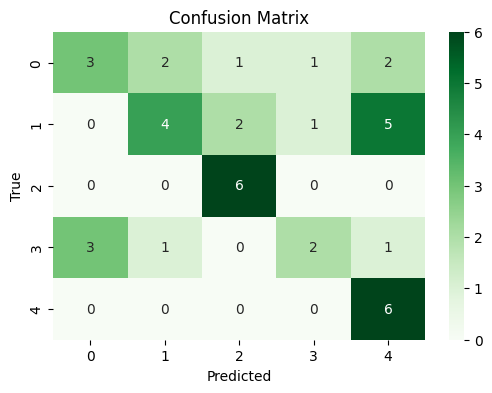

epoch 9 , Iter 1000. [Val Acc 52%] [Train Acc 88%] [Train Loss 1.370269, Validation loss 1.369102]
****************Train****************

Accuracy: 0.725
Precision: 0.7735515873015874
Recall: 0.725


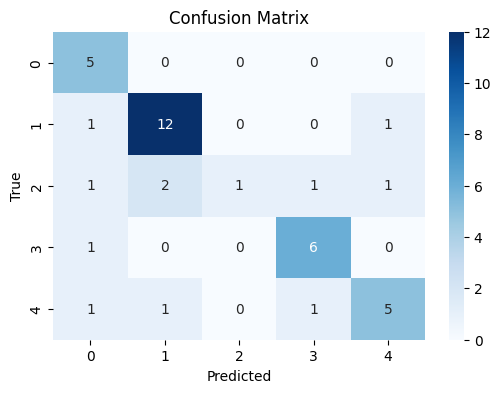

****************Validation****************

Accuracy: 0.625
Precision: 0.6604166666666667
Recall: 0.625


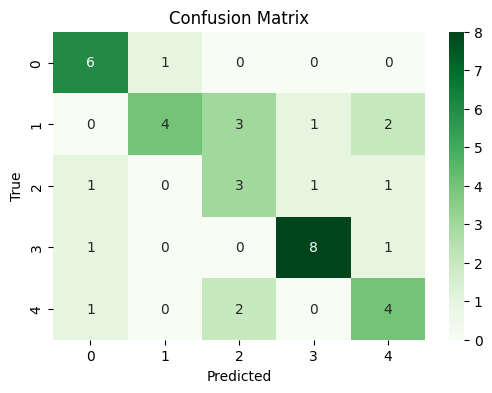

epoch 10 , Iter 1100. [Val Acc 62%] [Train Acc 72%] [Train Loss 1.141980, Validation loss 1.287455]


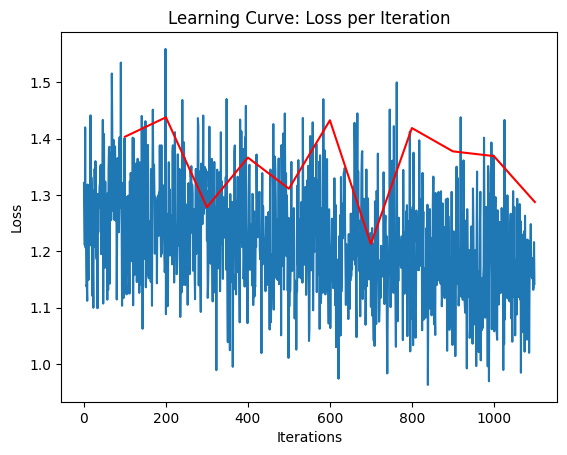

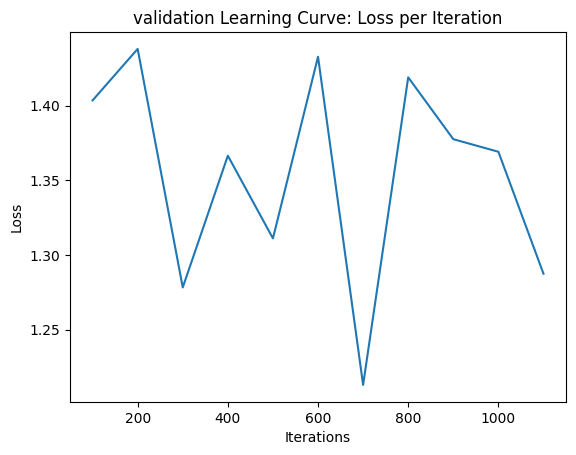

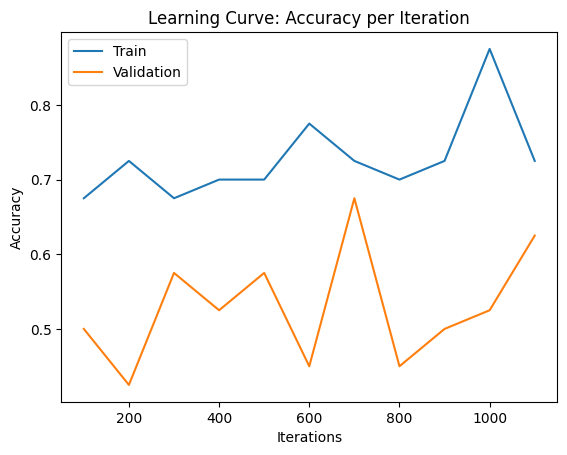

In [31]:
batch =20
m=0.00005 ## Lower learning rate to unable local optimization
decay=0.001 ## Consider changing weight decay rate
Arti.load_state_dict(torch.load('/content/Weights/ckpt-700.pk'))

learning_curve_info = run_pytorch_gradient_descent(Arti,vt, vtst, xt,st,N_epochs=10, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Weights2/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

In [35]:
Arti.load_state_dict(torch.load('/content/Weights2/ckpt-700.pk'))

<All keys matched successfully>

****************Train****************

Accuracy: 0.825
Precision: 0.8325892857142858
Recall: 0.825


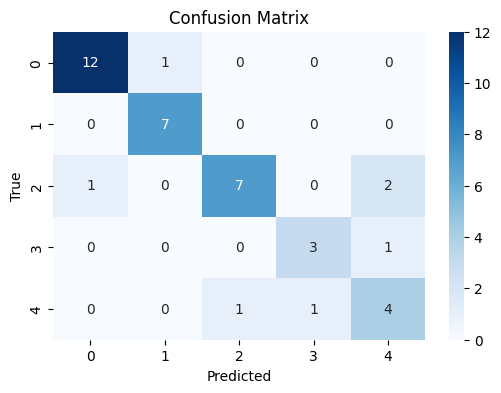

****************Validation****************

Accuracy: 0.7
Precision: 0.783452380952381
Recall: 0.7


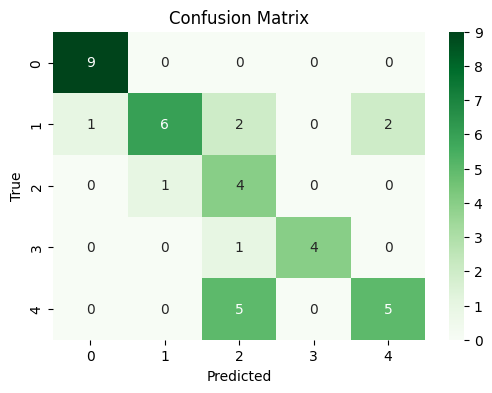

epoch 0 , Iter 100. [Val Acc 70%] [Train Acc 82%] [Train Loss 1.124472, Validation loss 1.230085]
****************Train****************

Accuracy: 0.675
Precision: 0.7291666666666667
Recall: 0.675


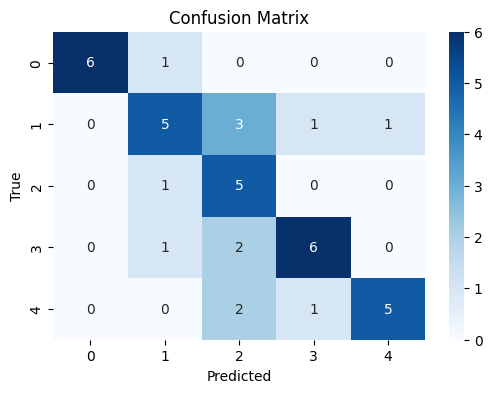

****************Validation****************

Accuracy: 0.65
Precision: 0.6594444444444444
Recall: 0.65


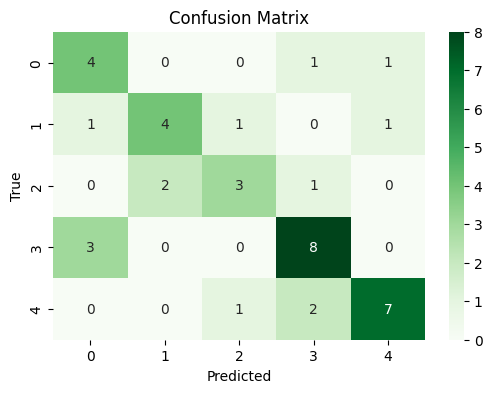

epoch 1 , Iter 200. [Val Acc 65%] [Train Acc 68%] [Train Loss 1.101478, Validation loss 1.253851]
****************Train****************

Accuracy: 0.775
Precision: 0.8449404761904763
Recall: 0.775


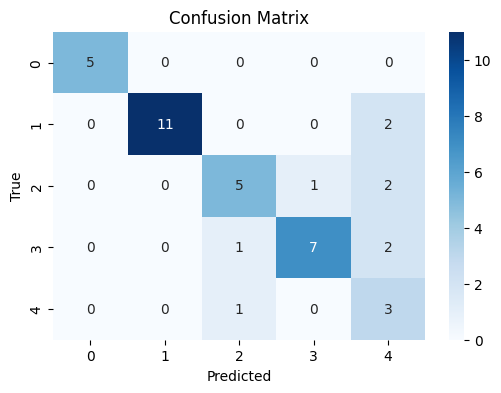

****************Validation****************

Accuracy: 0.75
Precision: 0.7470057720057719
Recall: 0.75


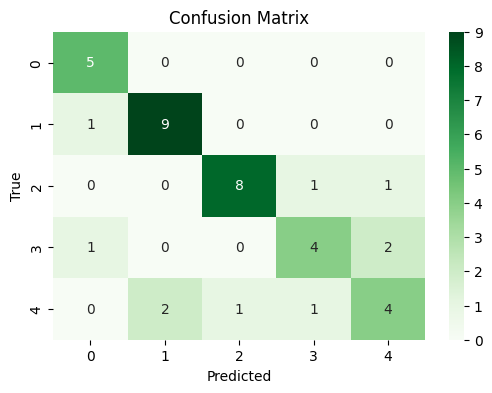

epoch 2 , Iter 300. [Val Acc 75%] [Train Acc 78%] [Train Loss 1.061426, Validation loss 1.242963]
****************Train****************

Accuracy: 0.85
Precision: 0.8444444444444444
Recall: 0.85


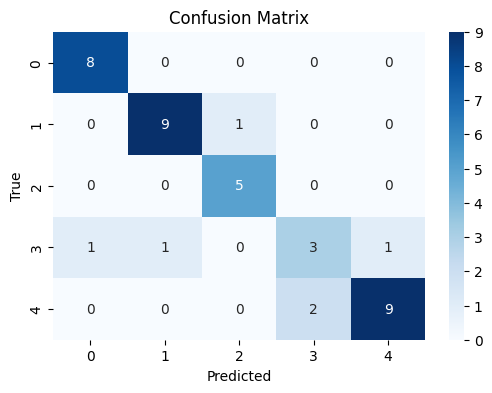

****************Validation****************

Accuracy: 0.725
Precision: 0.7208333333333333
Recall: 0.725


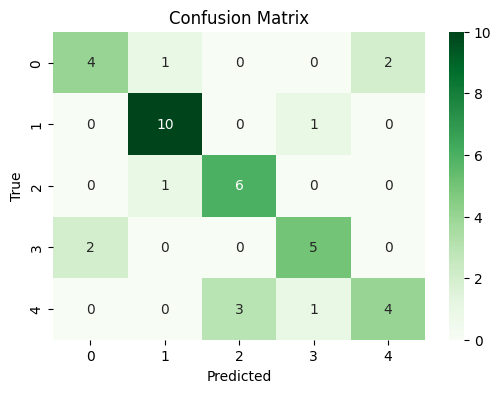

epoch 3 , Iter 400. [Val Acc 72%] [Train Acc 85%] [Train Loss 1.135952, Validation loss 1.180170]
****************Train****************

Accuracy: 0.9
Precision: 0.901923076923077
Recall: 0.9


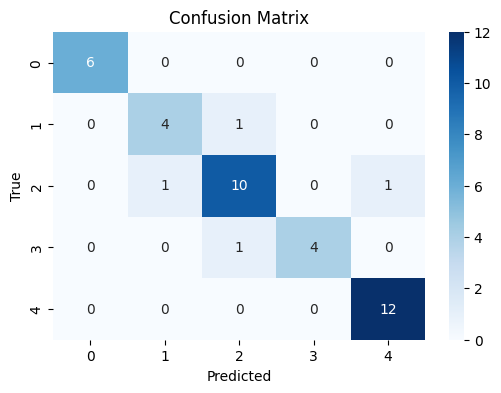

****************Validation****************

Accuracy: 0.6
Precision: 0.6658333333333333
Recall: 0.6


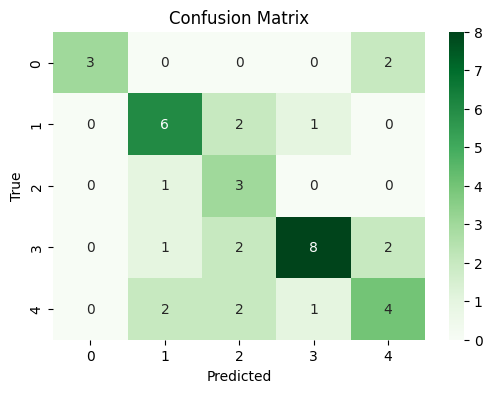

epoch 4 , Iter 500. [Val Acc 60%] [Train Acc 90%] [Train Loss 1.368306, Validation loss 1.284153]
****************Train****************

Accuracy: 0.725
Precision: 0.75
Recall: 0.725


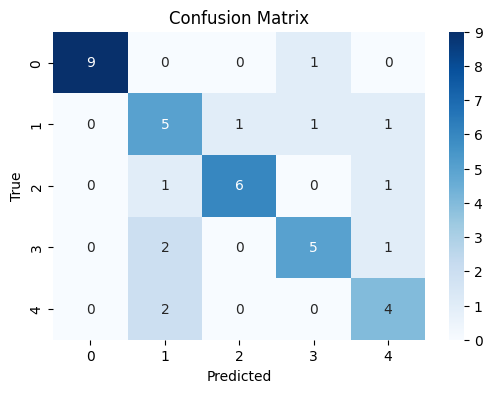

****************Validation****************

Accuracy: 0.675
Precision: 0.7017857142857142
Recall: 0.675


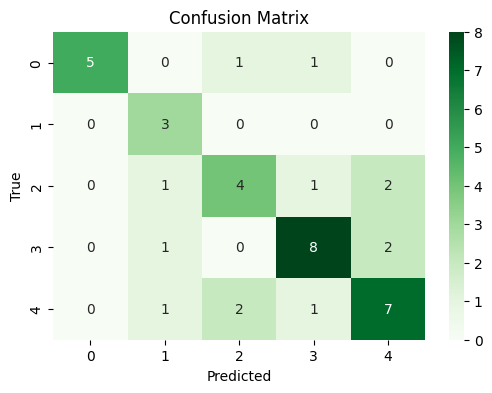

epoch 5 , Iter 600. [Val Acc 68%] [Train Acc 72%] [Train Loss 1.175114, Validation loss 1.224431]
****************Train****************

Accuracy: 0.75
Precision: 0.7589285714285714
Recall: 0.75


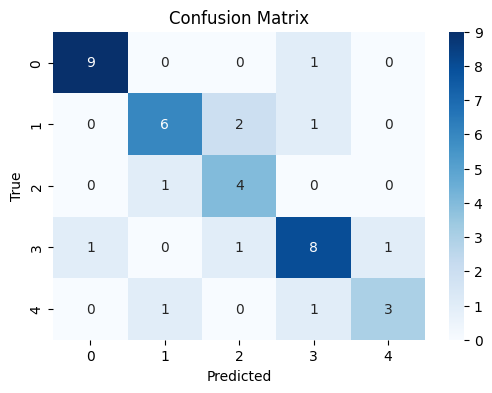

****************Validation****************

Accuracy: 0.7
Precision: 0.7833333333333334
Recall: 0.7


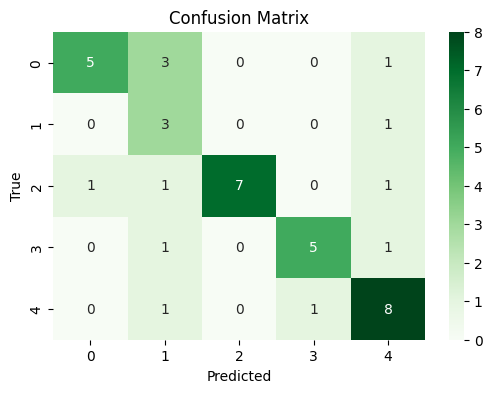

epoch 6 , Iter 700. [Val Acc 70%] [Train Acc 75%] [Train Loss 1.193190, Validation loss 1.274609]
****************Train****************

Accuracy: 0.875
Precision: 0.9032280219780219
Recall: 0.875


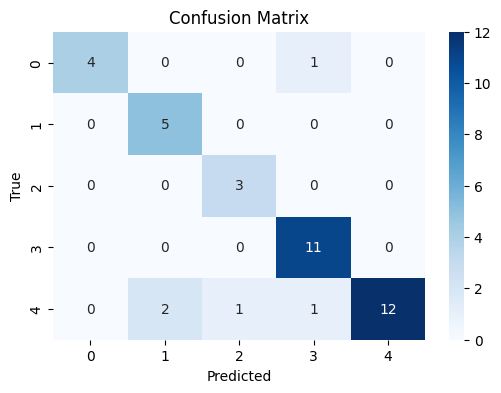

****************Validation****************

Accuracy: 0.7
Precision: 0.7544642857142857
Recall: 0.7


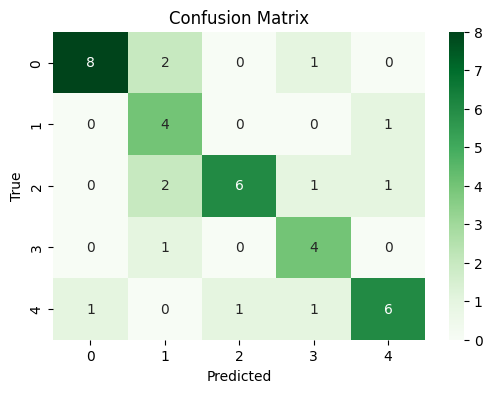

epoch 7 , Iter 800. [Val Acc 70%] [Train Acc 88%] [Train Loss 0.923683, Validation loss 1.249115]
****************Train****************

Accuracy: 0.875
Precision: 0.8982954545454545
Recall: 0.875


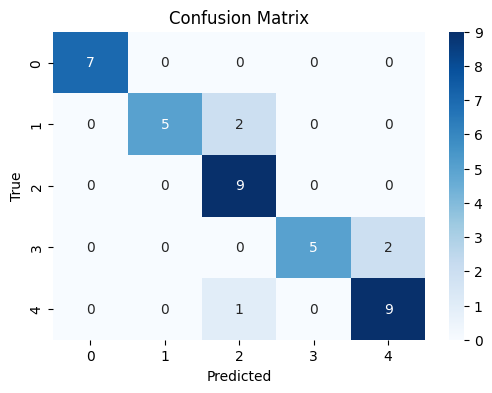

****************Validation****************

Accuracy: 0.575
Precision: 0.6115422077922078
Recall: 0.575


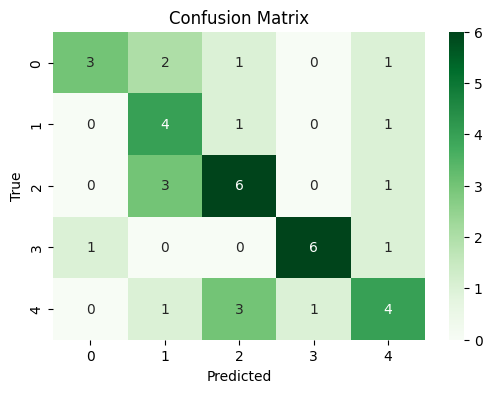

epoch 8 , Iter 900. [Val Acc 57%] [Train Acc 88%] [Train Loss 1.096962, Validation loss 1.314993]
****************Train****************

Accuracy: 0.825
Precision: 0.8431818181818181
Recall: 0.825


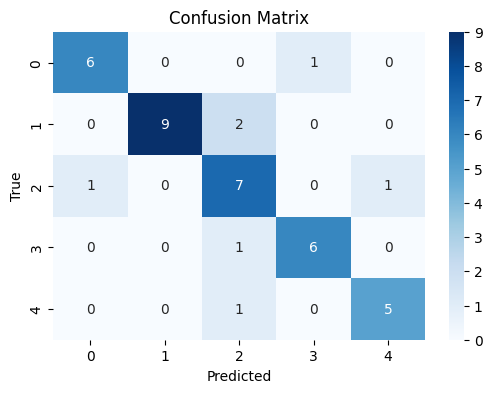

****************Validation****************

Accuracy: 0.6
Precision: 0.6229166666666666
Recall: 0.6


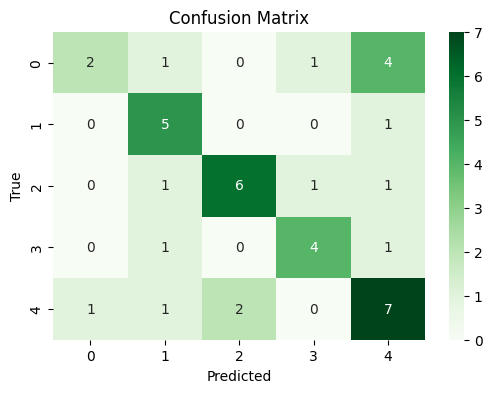

epoch 9 , Iter 1000. [Val Acc 60%] [Train Acc 82%] [Train Loss 1.077736, Validation loss 1.281211]
****************Train****************

Accuracy: 0.825
Precision: 0.8294642857142858
Recall: 0.825


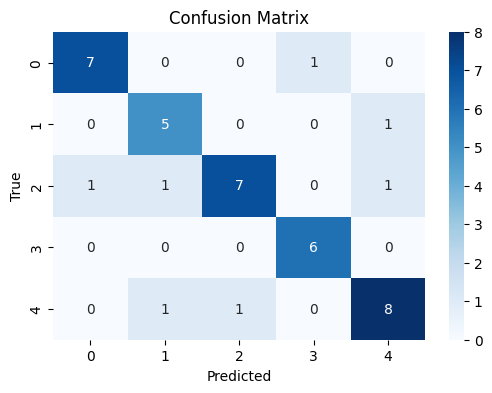

****************Validation****************

Accuracy: 0.675
Precision: 0.7492559523809523
Recall: 0.675


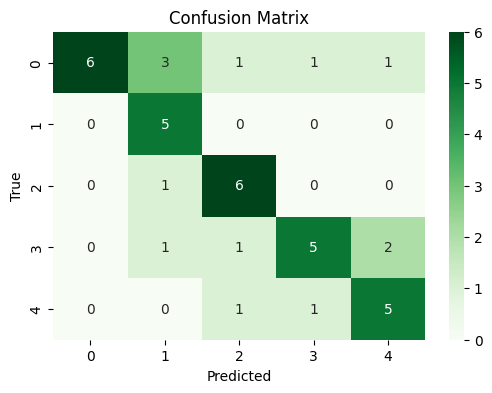

epoch 10 , Iter 1100. [Val Acc 68%] [Train Acc 82%] [Train Loss 1.107267, Validation loss 1.230480]


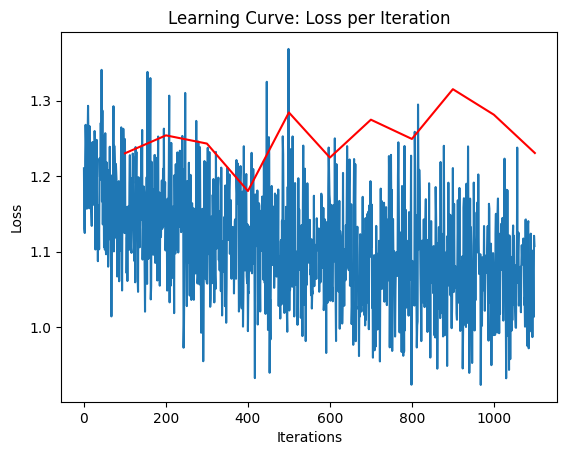

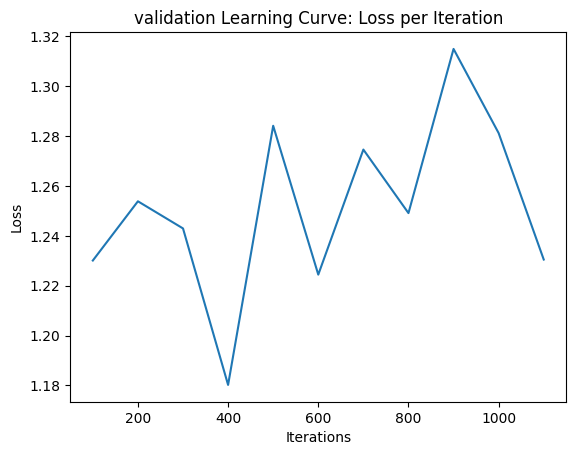

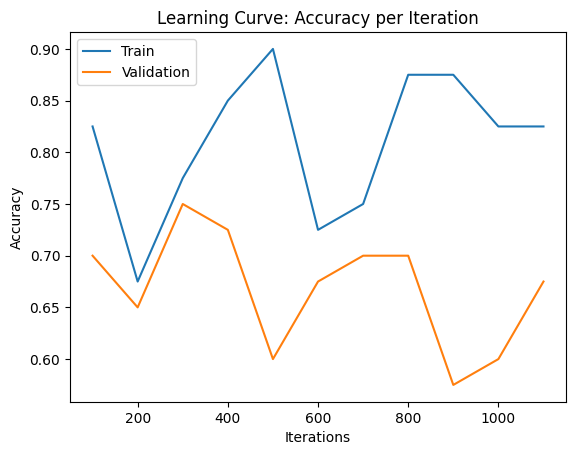

In [34]:
batch =20
m=0.00001 ## Lower learning rate to unable local optimization
decay=0.001 ## Consider changing weight decay rate

learning_curve_info = run_pytorch_gradient_descent(Arti,vt, vtst, xt,st,N_epochs=10, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Weights3/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

#Outcome Discussion and Insights
In this session the best results I have reached this way are:

"epoch 2 , Iter 300. [Val Acc **75%**] [Train Acc 78%] [Train Loss 1.061426, Validation loss 1.242963]"
__________
In a different session I have reached better results of :

"epoch 1 , Iter 200. [Val Acc **78%**] [Train Acc 80%] [Train Loss 0.601095, Validation loss 0.698188]"
__________
This is due to the random nature of stochastic gradient descent(SGD) and weights initialization.

These results are nice, but they are challenging to recreate. This suggests that the achievement is more a result of luck and persistence than the creation of a comprehensive manual for solving the task.

#*The inherent randomness involved in attempting to converge to a favorable minimum on the loss function through SGD can provide motivation to persist with a particular method, anticipating diverse and improved outcomes. However, our aim here is not to grasp the skill of '**wishing to win the lottery**'; rather, we are here to **uncover strategies that effectively address the problem** in a way that won't fail us.*

Therefore, we will be moving on to our next approach.

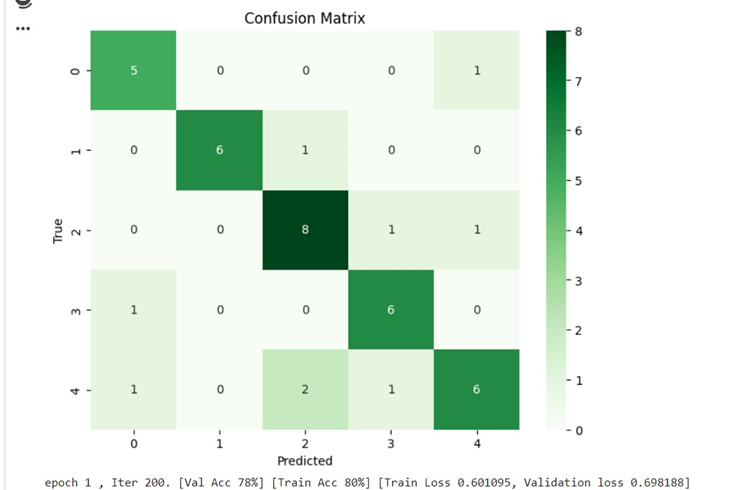

The accuracy estimations were tested on a subset of 20 images, not the entire validation set. Examining the confusion matrix reveals that the model's confusion is evenly distributed across the five artists, indicating that difficulty in recognition is not concentrated on one or two specific artists. The next confusion matrix has tested the whole validation set and shows an accuracy rate of **64.5%**.






Accuracy: 0.6450304259634888
Precision: 0.6534471122102212
Recall: 0.6450304259634888


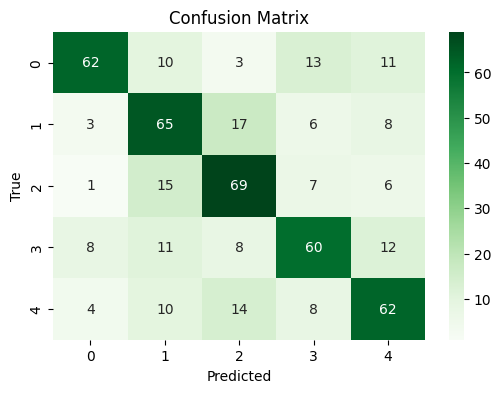

In [38]:
Arti.load_state_dict(torch.load('/content/Weights3/ckpt-300.pk'))
val_acc, val_loss = get_accuracy(Arti,vt,vtst,"Greens" ,20,493)

# **4.  Train CNN with dropout called Dropi and show results**
  C.   Apply dropout regularization to prevent overfitting.

  
Use a different NN called 'Dropi' implemented with dropout layers and normalization.
In the convolutional layers we will use normalization, in the fully connected layers we will use dropout as recommended in :

https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html

I have concerns about using batch normalization with small batches (20 images) and the potential lack of meaningful normalization across different paintings. Batch normalization calculates statistics (mean and variance) over the batch, and in the case of small batches, these statistics might not accurately represent the overall distribution of my data. So, I will use layer normalization instead of batch normalization.

Notice the dropout rate used and the amount and location of these dropout layers - every change in these parameters makes an effect. Hopefully these dropout layers will help prevent overfitting while allowing learning.

In [55]:
Dropi = Dropi_Art_NN(n=6)
Dropi.to(device)
print(Dropi)

Dropi_Art_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layernorm1): LayerNorm((3, 512, 512), eps=

****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.475
Precision: 0.3563636363636363
Recall: 0.475


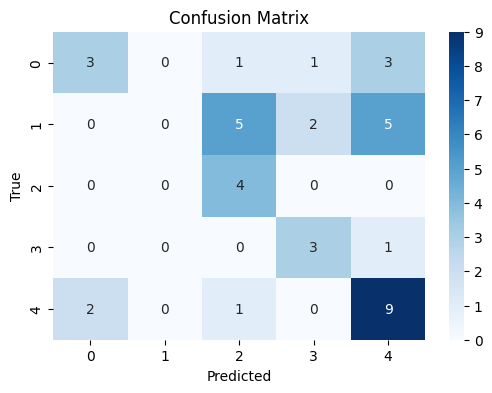

****************Validation****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.475
Precision: 0.3671689421689422
Recall: 0.475


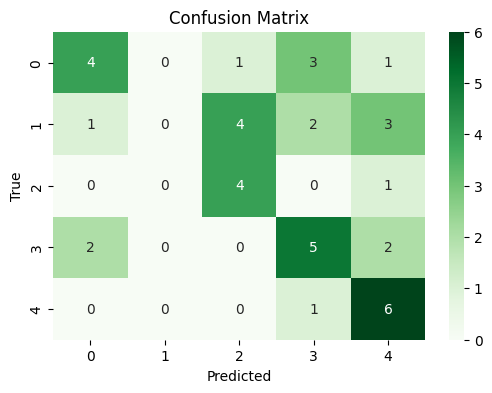

epoch 0 , Iter 100. [Val Acc 48%] [Train Acc 48%] [Train Loss 1.611330, Validation loss 1.412826]
****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.6
Precision: 0.5194444444444445
Recall: 0.6


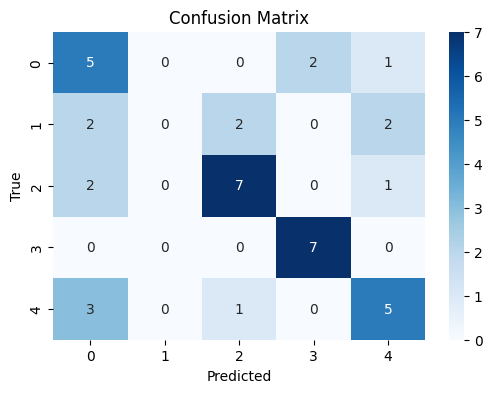

****************Validation****************

Accuracy: 0.5
Precision: 0.4993253968253968
Recall: 0.5


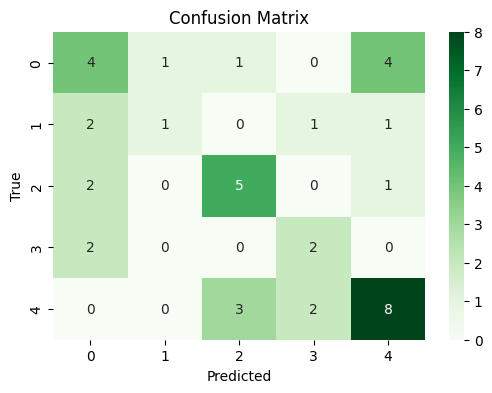

epoch 1 , Iter 200. [Val Acc 50%] [Train Acc 60%] [Train Loss 1.214321, Validation loss 1.383039]
****************Train****************

Accuracy: 0.575
Precision: 0.7080882352941177
Recall: 0.575


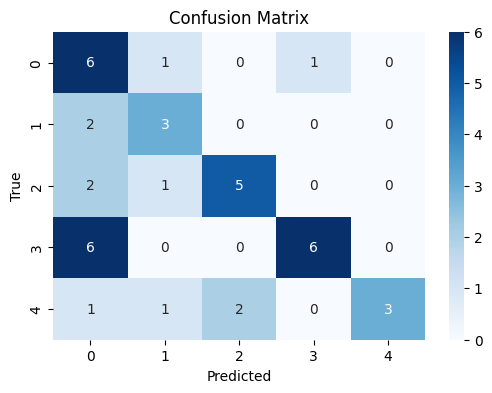

****************Validation****************

Accuracy: 0.575
Precision: 0.5868055555555556
Recall: 0.575


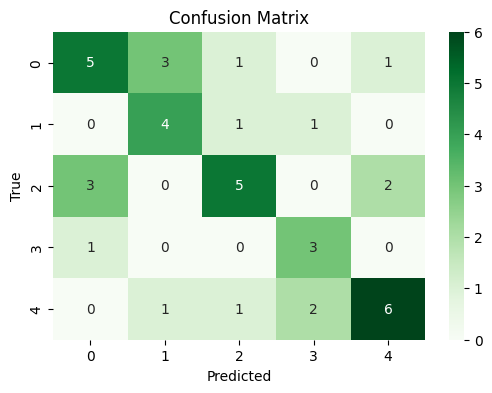

epoch 2 , Iter 300. [Val Acc 57%] [Train Acc 57%] [Train Loss 1.429109, Validation loss 1.341829]
****************Train****************

Accuracy: 0.675
Precision: 0.8035416666666666
Recall: 0.675


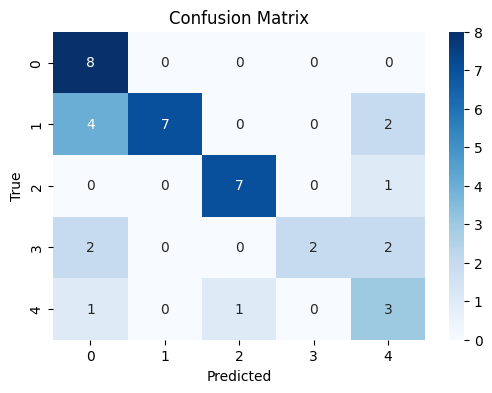

****************Validation****************

Accuracy: 0.55
Precision: 0.7214204545454546
Recall: 0.55


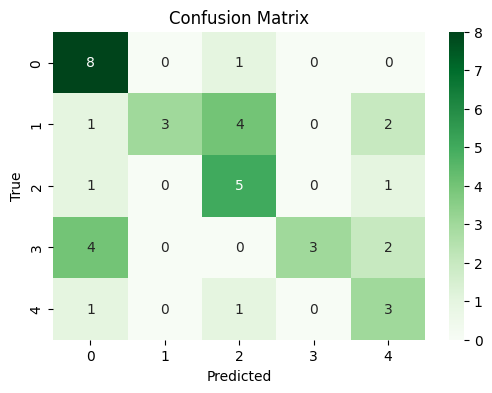

epoch 3 , Iter 400. [Val Acc 55%] [Train Acc 68%] [Train Loss 1.159395, Validation loss 1.359903]
****************Train****************

Accuracy: 0.6
Precision: 0.6593434343434345
Recall: 0.6


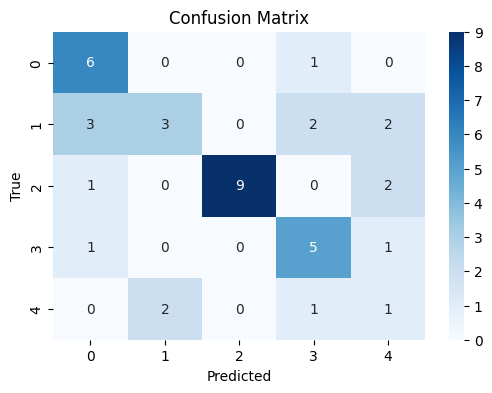

****************Validation****************

Accuracy: 0.475
Precision: 0.6436868686868686
Recall: 0.475


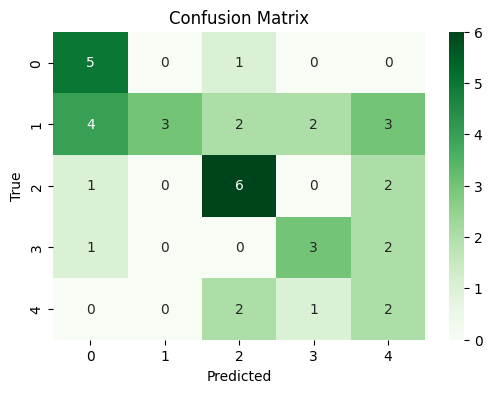

epoch 4 , Iter 500. [Val Acc 48%] [Train Acc 60%] [Train Loss 1.384305, Validation loss 1.437906]
****************Train****************

Accuracy: 0.575
Precision: 0.6009469696969697
Recall: 0.575


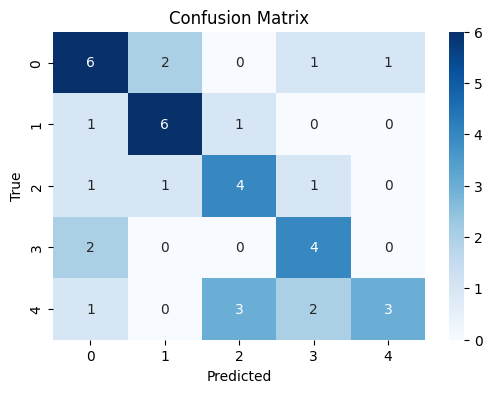

****************Validation****************

Accuracy: 0.625
Precision: 0.6365440115440115
Recall: 0.625


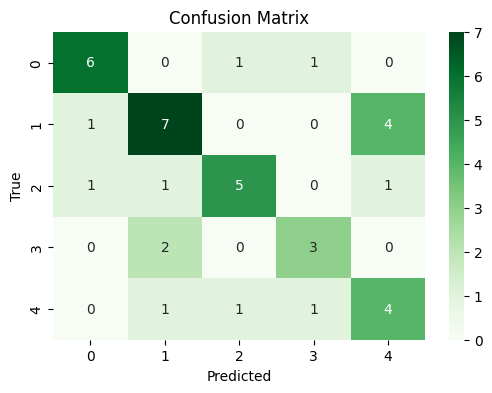

epoch 5 , Iter 600. [Val Acc 62%] [Train Acc 57%] [Train Loss 1.235937, Validation loss 1.277005]
****************Train****************

Accuracy: 0.6
Precision: 0.6132575757575758
Recall: 0.6


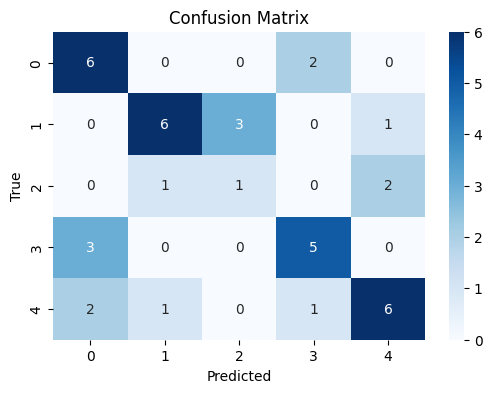

****************Validation****************

Accuracy: 0.425
Precision: 0.45684523809523814
Recall: 0.425


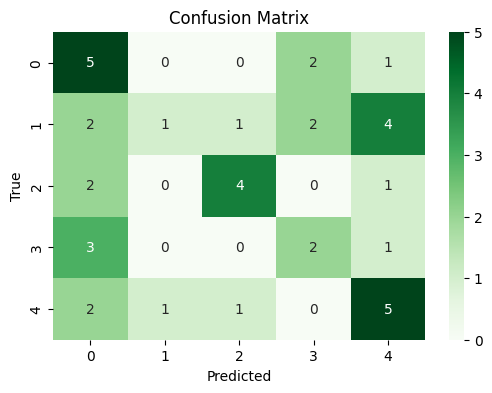

epoch 6 , Iter 700. [Val Acc 42%] [Train Acc 60%] [Train Loss 1.530756, Validation loss 1.444446]
****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.8
Precision: 0.7674999999999998
Recall: 0.8


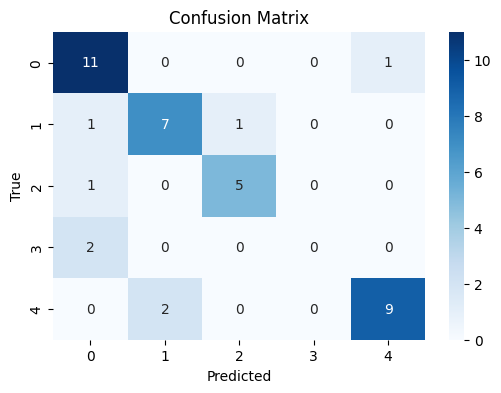

****************Validation****************

Accuracy: 0.6
Precision: 0.6255357142857143
Recall: 0.6


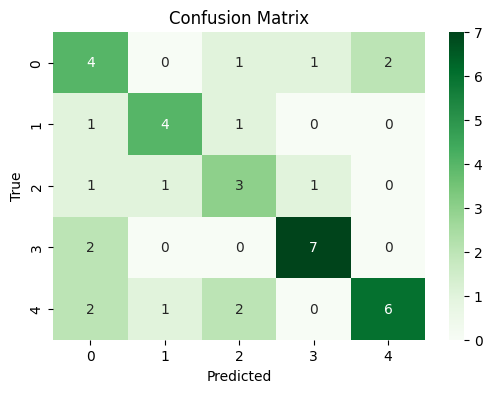

epoch 7 , Iter 800. [Val Acc 60%] [Train Acc 80%] [Train Loss 1.128367, Validation loss 1.284823]
****************Train****************

Accuracy: 0.675
Precision: 0.7167857142857142
Recall: 0.675


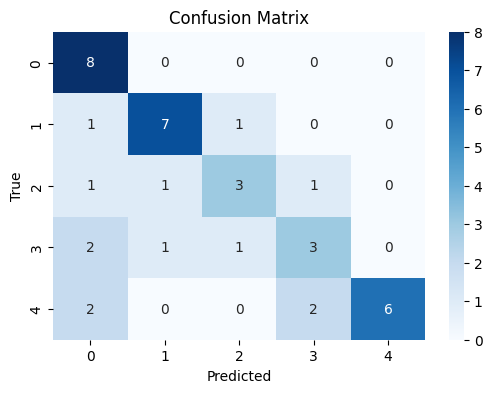

****************Validation****************

Accuracy: 0.5
Precision: 0.5363888888888889
Recall: 0.5


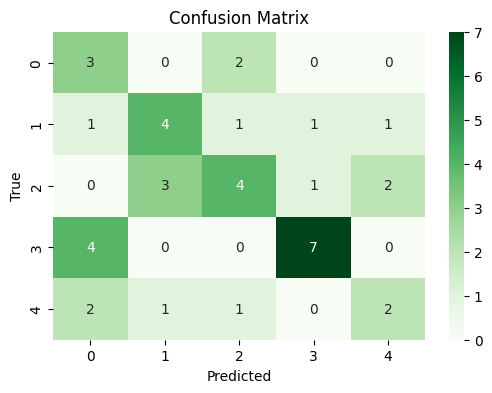

epoch 8 , Iter 900. [Val Acc 50%] [Train Acc 68%] [Train Loss 1.170659, Validation loss 1.384358]
****************Train****************

Accuracy: 0.675
Precision: 0.6983333333333333
Recall: 0.675


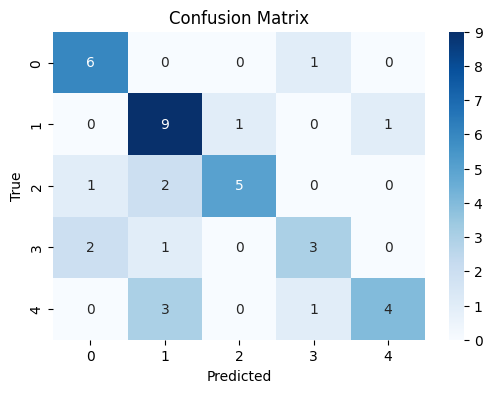

****************Validation****************

Accuracy: 0.6
Precision: 0.6916666666666667
Recall: 0.6


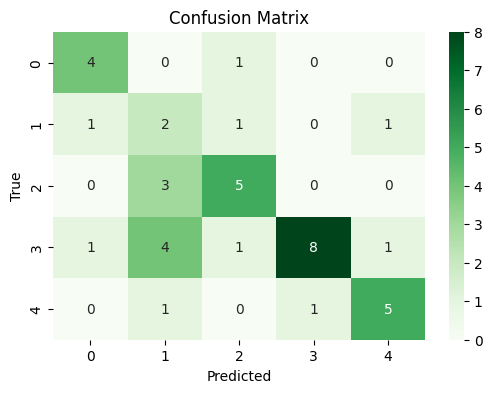

epoch 9 , Iter 1000. [Val Acc 60%] [Train Acc 68%] [Train Loss 1.265141, Validation loss 1.313786]
****************Train****************

Accuracy: 0.7
Precision: 0.6947649572649572
Recall: 0.7


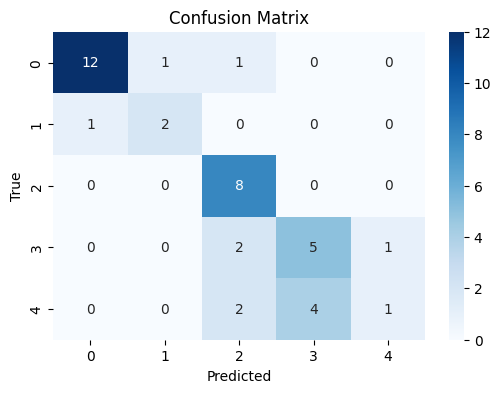

****************Validation****************

Accuracy: 0.625
Precision: 0.774067599067599
Recall: 0.625


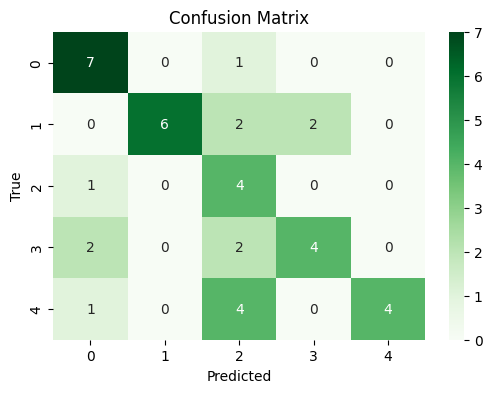

epoch 10 , Iter 1100. [Val Acc 62%] [Train Acc 70%] [Train Loss 1.448148, Validation loss 1.313355]


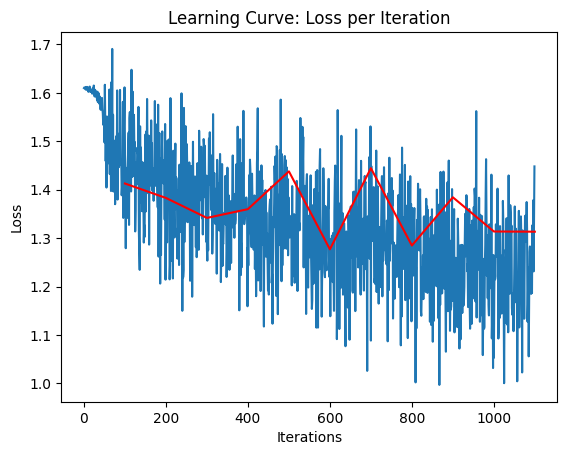

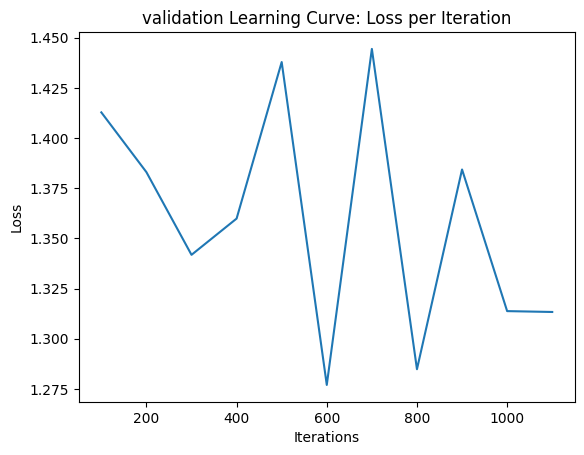

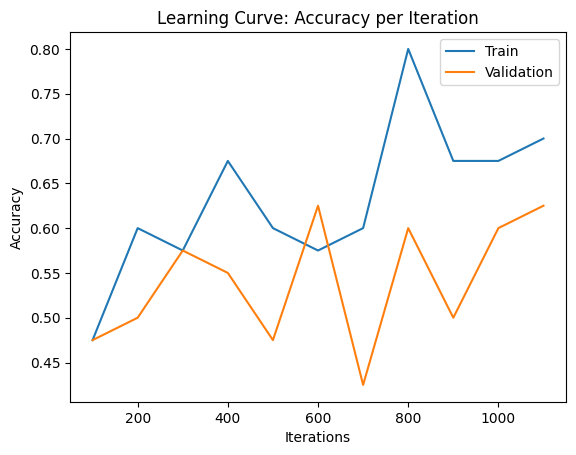

In [56]:

batch =20
m=0.0001
decay=0.001


learning_curve_info = run_pytorch_gradient_descent(Dropi,vt, vtst, xt,st,N_epochs=10, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Dropi/Weights/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

# B. Implement early stopping for 'Dropi' too

****************Train****************

Accuracy: 0.675
Precision: 0.6876893939393939
Recall: 0.675


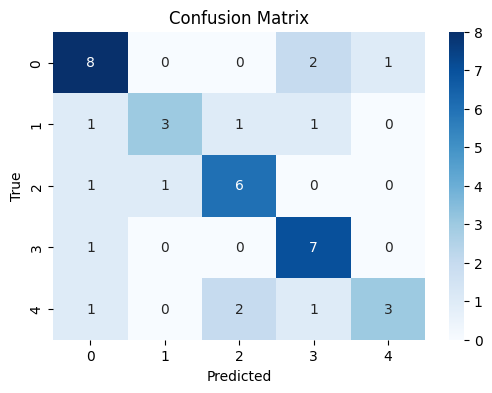

****************Validation****************

Accuracy: 0.6
Precision: 0.6895833333333333
Recall: 0.6


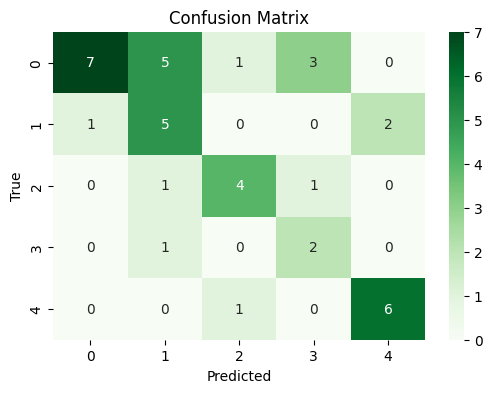

epoch 0 , Iter 100. [Val Acc 60%] [Train Acc 68%] [Train Loss 1.242140, Validation loss 1.270603]
****************Train****************

Accuracy: 0.575
Precision: 0.5823076923076923
Recall: 0.575


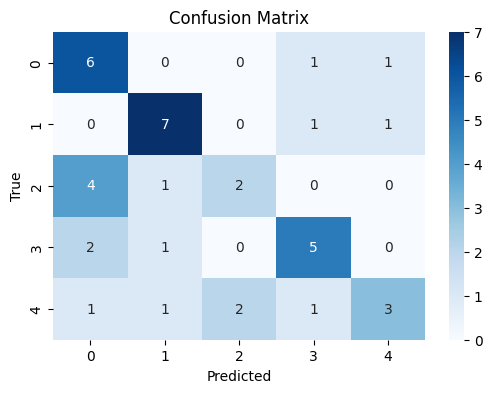

****************Validation****************

Accuracy: 0.575
Precision: 0.6702380952380953
Recall: 0.575


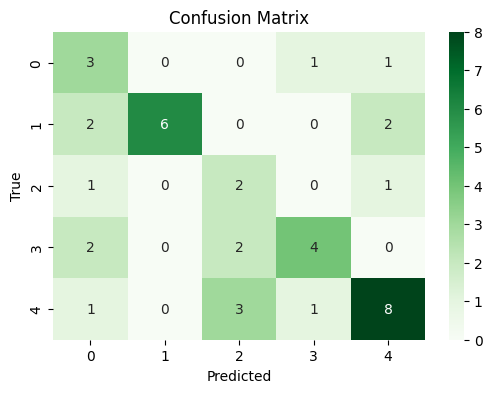

epoch 1 , Iter 200. [Val Acc 57%] [Train Acc 57%] [Train Loss 1.322456, Validation loss 1.333276]
****************Train****************

Accuracy: 0.625
Precision: 0.6538825757575758
Recall: 0.625


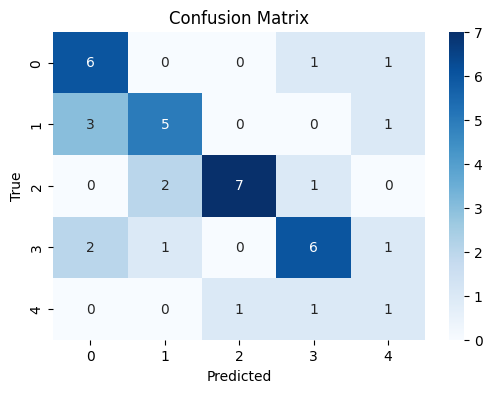

****************Validation****************

Accuracy: 0.575
Precision: 0.6307224025974026
Recall: 0.575


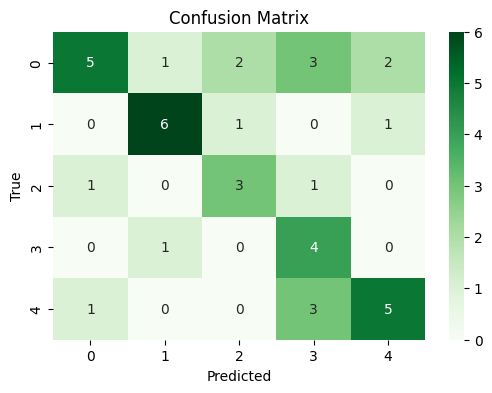

epoch 2 , Iter 300. [Val Acc 57%] [Train Acc 62%] [Train Loss 1.328590, Validation loss 1.317654]
****************Train****************

Accuracy: 0.5
Precision: 0.4931746031746031
Recall: 0.5


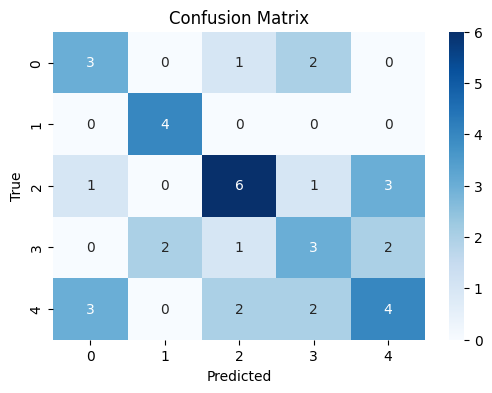

****************Validation****************

Accuracy: 0.575
Precision: 0.5328571428571428
Recall: 0.575


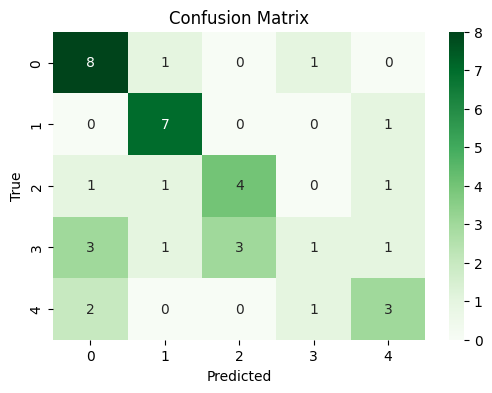

epoch 3 , Iter 400. [Val Acc 57%] [Train Acc 50%] [Train Loss 1.295846, Validation loss 1.333456]
****************Train****************

Accuracy: 0.625
Precision: 0.6192857142857142
Recall: 0.625


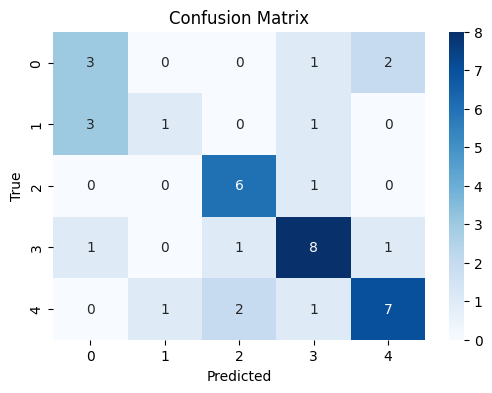

****************Validation****************

Accuracy: 0.425
Precision: 0.4399801587301587
Recall: 0.425


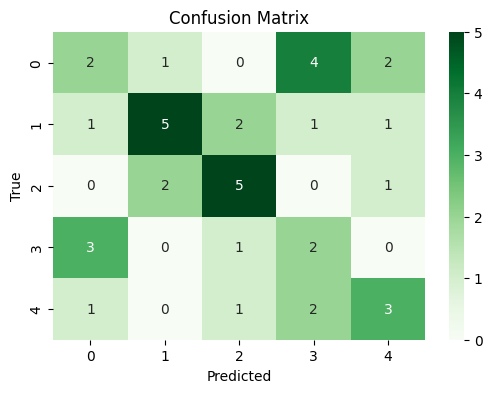

epoch 4 , Iter 500. [Val Acc 42%] [Train Acc 62%] [Train Loss 1.302414, Validation loss 1.433976]
****************Train****************

Accuracy: 0.575
Precision: 0.5830952380952381
Recall: 0.575


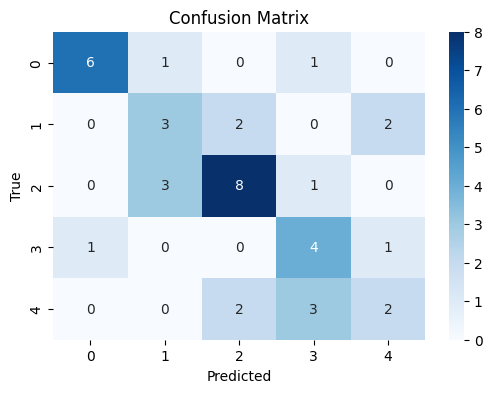

****************Validation****************

Accuracy: 0.5
Precision: 0.5167532467532467
Recall: 0.5


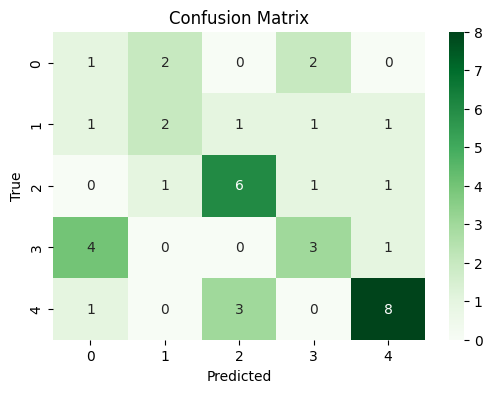

epoch 5 , Iter 600. [Val Acc 50%] [Train Acc 57%] [Train Loss 1.303019, Validation loss 1.368187]
****************Train****************

Accuracy: 0.75
Precision: 0.7816666666666666
Recall: 0.75


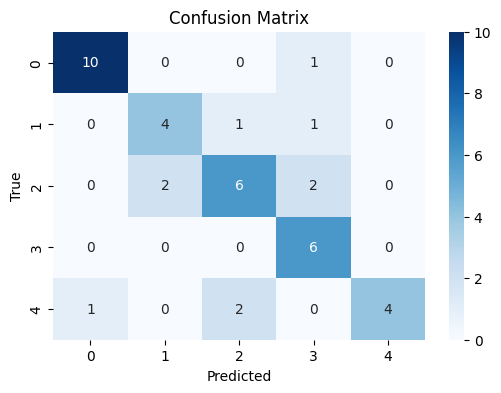

****************Validation****************

Accuracy: 0.475
Precision: 0.44749999999999995
Recall: 0.475


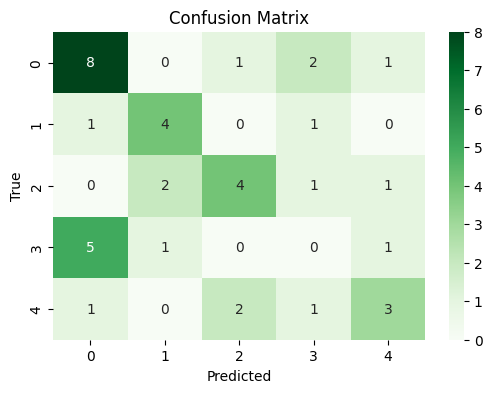

epoch 6 , Iter 700. [Val Acc 48%] [Train Acc 75%] [Train Loss 1.235263, Validation loss 1.435003]
****************Train****************

Accuracy: 0.65
Precision: 0.6610389610389611
Recall: 0.65


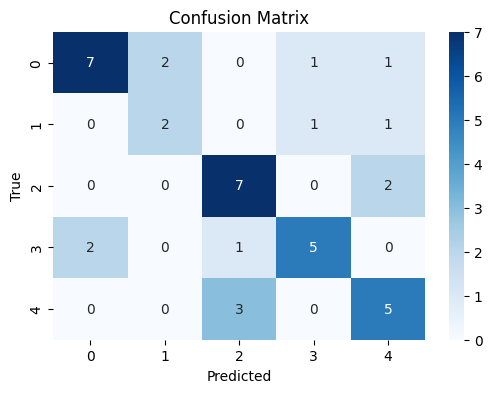

****************Validation****************

Accuracy: 0.575
Precision: 0.5999999999999999
Recall: 0.575


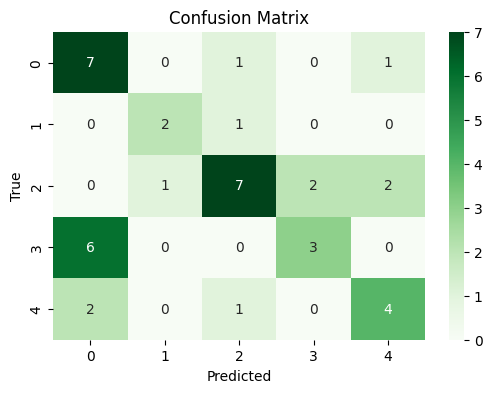

epoch 7 , Iter 800. [Val Acc 57%] [Train Acc 65%] [Train Loss 1.359194, Validation loss 1.320888]
****************Train****************

Accuracy: 0.7
Precision: 0.7419047619047621
Recall: 0.7


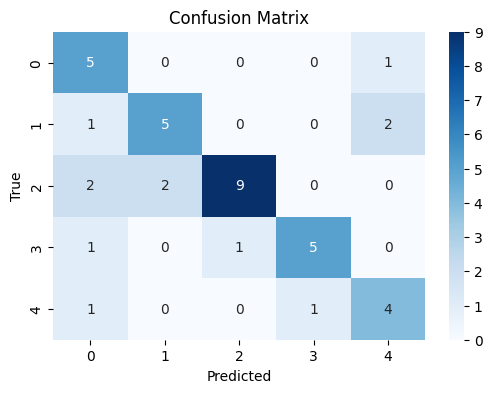

****************Validation****************

Accuracy: 0.725
Precision: 0.7298295454545455
Recall: 0.725


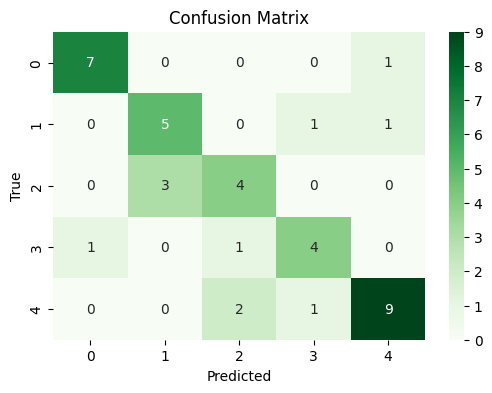

epoch 8 , Iter 900. [Val Acc 72%] [Train Acc 70%] [Train Loss 1.359868, Validation loss 1.185737]
****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.7
Precision: 0.6429395604395605
Recall: 0.7


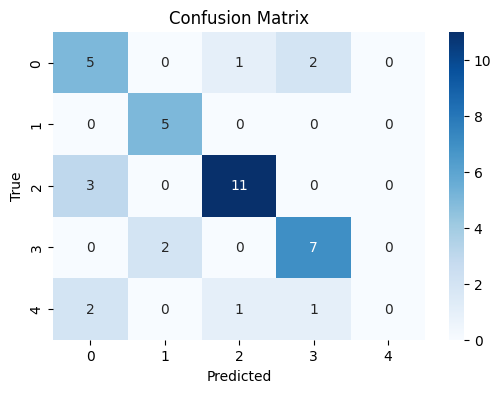

****************Validation****************

Accuracy: 0.625
Precision: 0.6315972222222223
Recall: 0.625


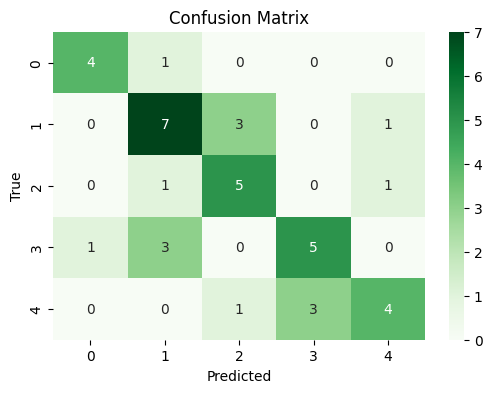

epoch 9 , Iter 1000. [Val Acc 62%] [Train Acc 70%] [Train Loss 1.143492, Validation loss 1.291466]
****************Train****************

Accuracy: 0.675
Precision: 0.6666666666666666
Recall: 0.675


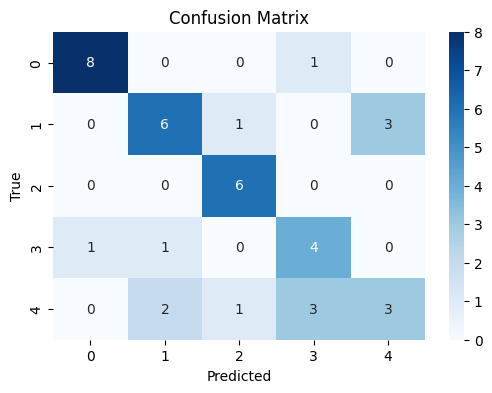

****************Validation****************

Accuracy: 0.575
Precision: 0.600595238095238
Recall: 0.575


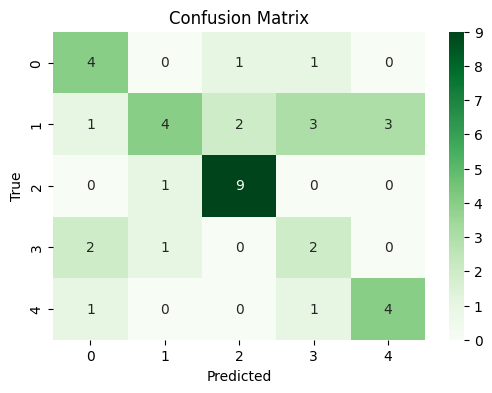

epoch 10 , Iter 1100. [Val Acc 57%] [Train Acc 68%] [Train Loss 1.158859, Validation loss 1.337336]
****************Train****************

Accuracy: 0.75
Precision: 0.7525162337662338
Recall: 0.75


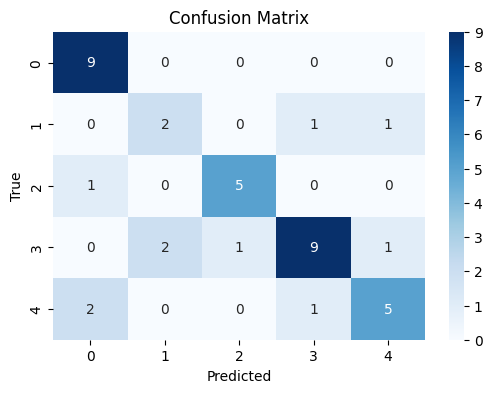

****************Validation****************

Accuracy: 0.75
Precision: 0.7668831168831168
Recall: 0.75


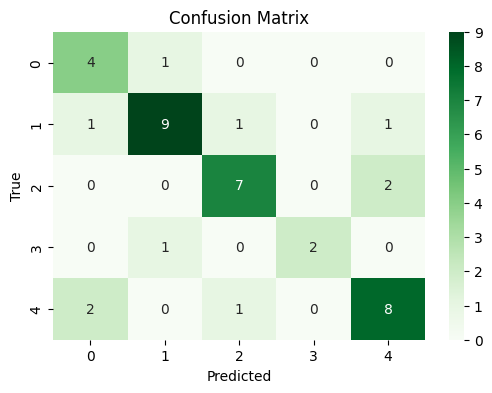

epoch 11 , Iter 1200. [Val Acc 75%] [Train Acc 75%] [Train Loss 1.265265, Validation loss 1.179167]
****************Train****************

Accuracy: 0.6
Precision: 0.6171428571428571
Recall: 0.6


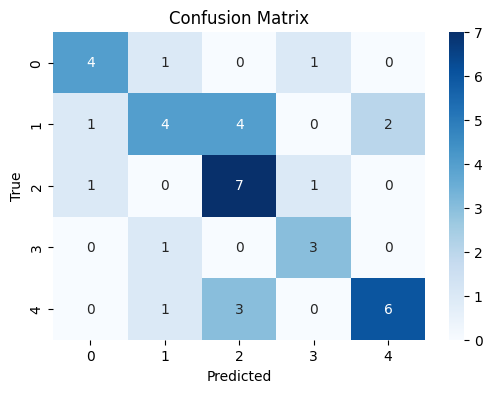

****************Validation****************

Accuracy: 0.5
Precision: 0.510625
Recall: 0.5


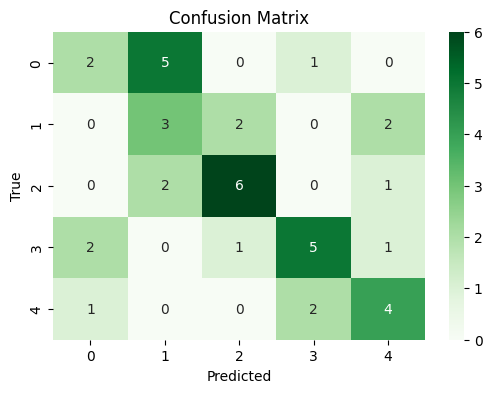

epoch 12 , Iter 1300. [Val Acc 50%] [Train Acc 60%] [Train Loss 1.181601, Validation loss 1.385582]
****************Train****************

Accuracy: 0.725
Precision: 0.7223214285714286
Recall: 0.725


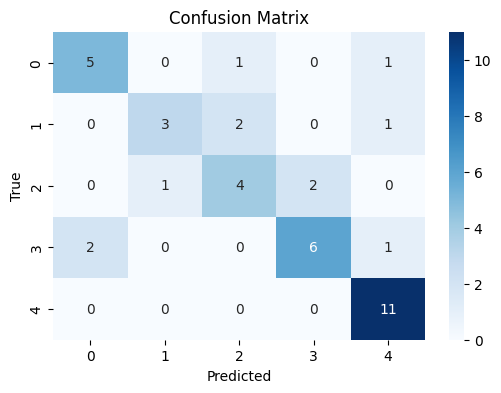

****************Validation****************

Accuracy: 0.425
Precision: 0.4599417249417249
Recall: 0.425


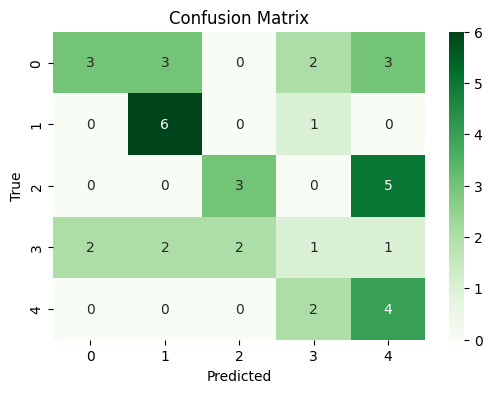

epoch 13 , Iter 1400. [Val Acc 42%] [Train Acc 72%] [Train Loss 1.235109, Validation loss 1.409730]
****************Train****************

Accuracy: 0.725
Precision: 0.7879807692307692
Recall: 0.725


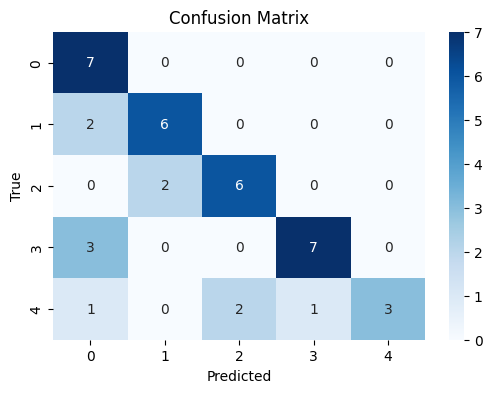

****************Validation****************

Accuracy: 0.425
Precision: 0.47689393939393937
Recall: 0.425


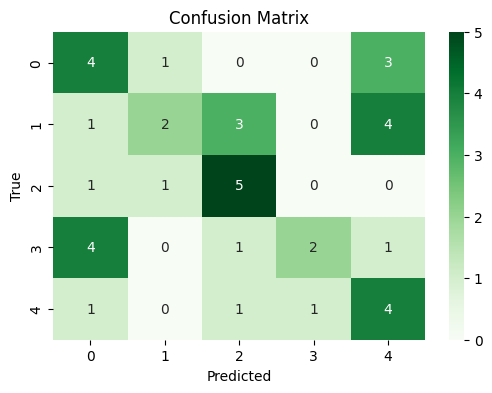

epoch 14 , Iter 1500. [Val Acc 42%] [Train Acc 72%] [Train Loss 1.187253, Validation loss 1.469412]
****************Train****************

Accuracy: 0.65
Precision: 0.65
Recall: 0.65


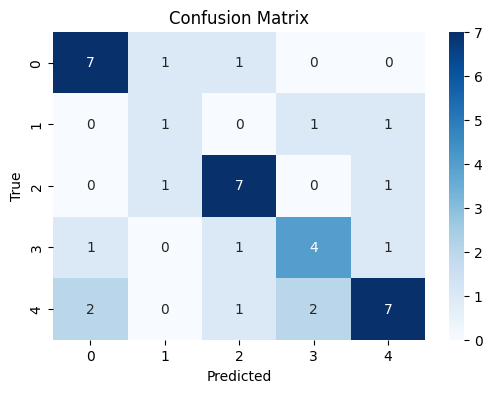

****************Validation****************

Accuracy: 0.6
Precision: 0.6375
Recall: 0.6


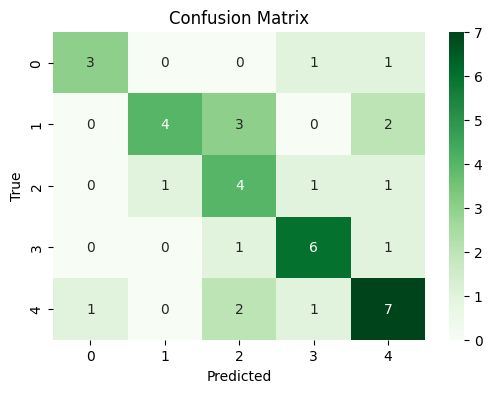

epoch 15 , Iter 1600. [Val Acc 60%] [Train Acc 65%] [Train Loss 1.494188, Validation loss 1.273261]
****************Train****************

Accuracy: 0.675
Precision: 0.7453030303030304
Recall: 0.675


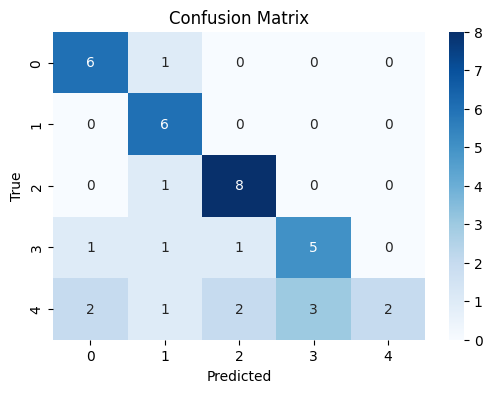

****************Validation****************

Accuracy: 0.4
Precision: 0.42437500000000006
Recall: 0.4


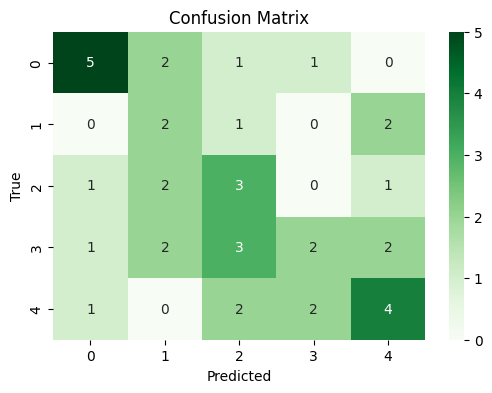

epoch 16 , Iter 1700. [Val Acc 40%] [Train Acc 68%] [Train Loss 1.349905, Validation loss 1.460034]
****************Train****************

Accuracy: 0.85
Precision: 0.8547348484848485
Recall: 0.85


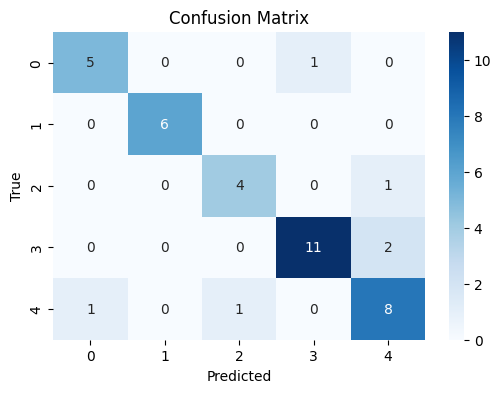

****************Validation****************

Accuracy: 0.5
Precision: 0.5531746031746032
Recall: 0.5


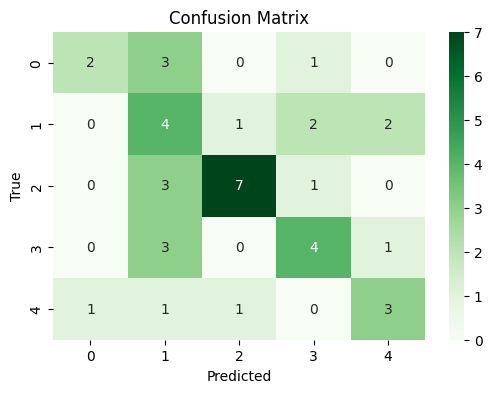

epoch 17 , Iter 1800. [Val Acc 50%] [Train Acc 85%] [Train Loss 1.412503, Validation loss 1.426363]
****************Train****************

Accuracy: 0.725
Precision: 0.7573214285714285
Recall: 0.725


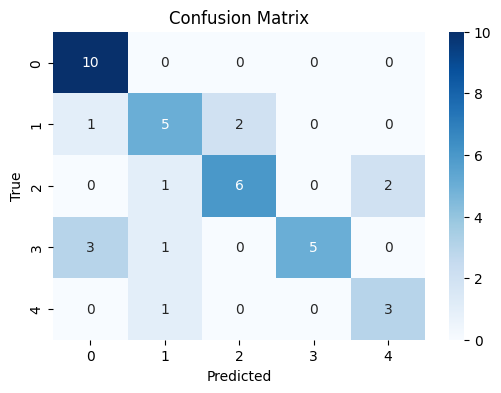

****************Validation****************

Accuracy: 0.5
Precision: 0.5443749999999999
Recall: 0.5


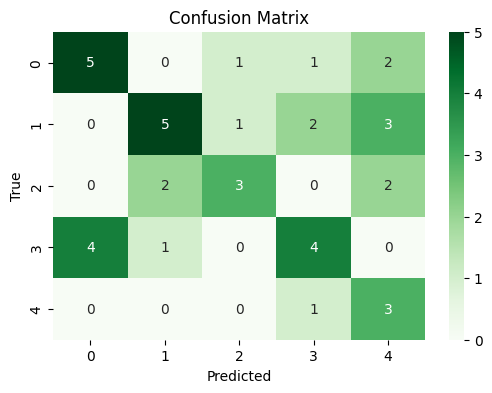

epoch 18 , Iter 1900. [Val Acc 50%] [Train Acc 72%] [Train Loss 1.153811, Validation loss 1.369369]
****************Train****************

Accuracy: 0.725
Precision: 0.7337301587301587
Recall: 0.725


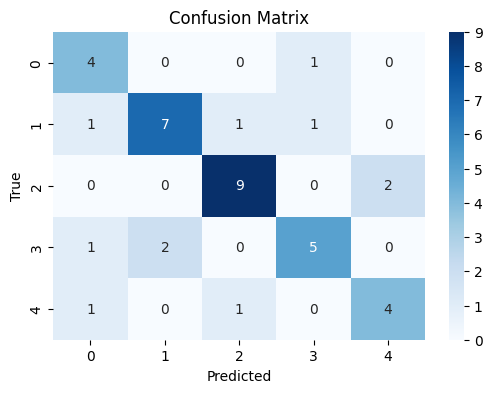

****************Validation****************

Accuracy: 0.55
Precision: 0.561456043956044
Recall: 0.55


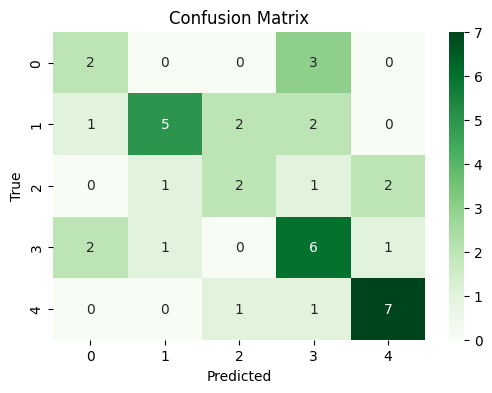

epoch 19 , Iter 2000. [Val Acc 55%] [Train Acc 72%] [Train Loss 1.142407, Validation loss 1.364486]
****************Train****************

Accuracy: 0.8
Precision: 0.8139285714285714
Recall: 0.8


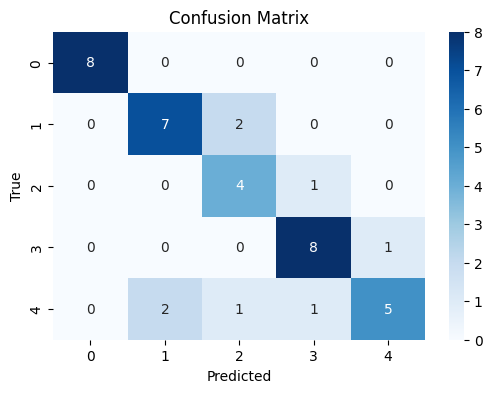

****************Validation****************

Accuracy: 0.6
Precision: 0.6386904761904763
Recall: 0.6


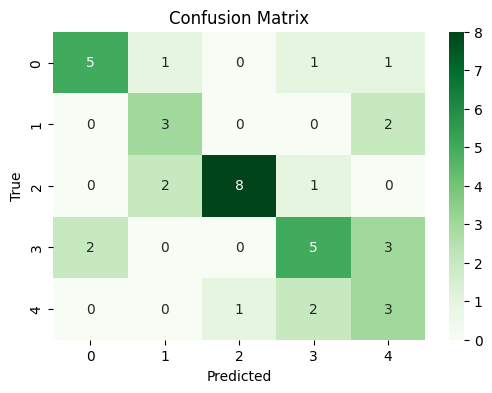

epoch 20 , Iter 2100. [Val Acc 60%] [Train Acc 80%] [Train Loss 1.380344, Validation loss 1.297074]


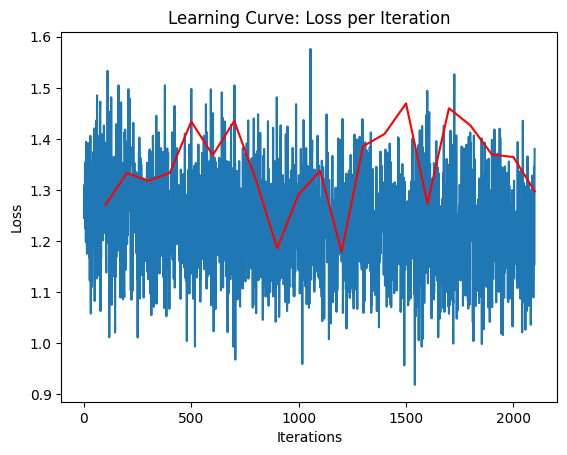

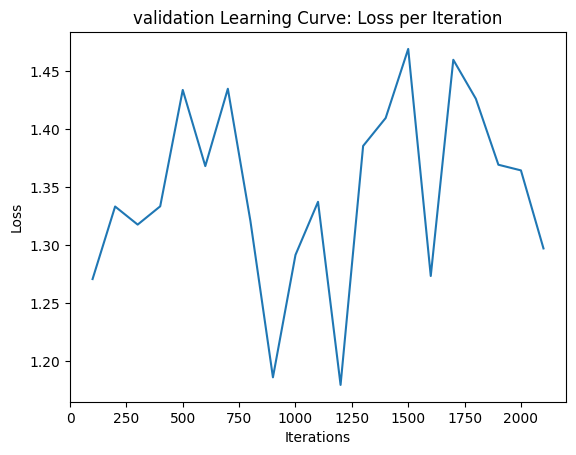

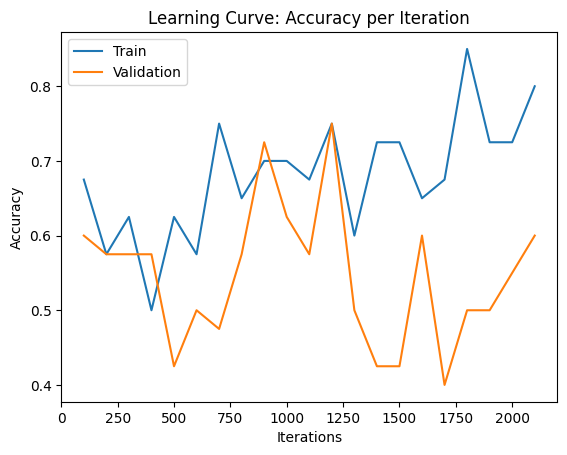

In [57]:

batch =20
m=0.00001
decay=0.001
Dropi.load_state_dict(torch.load('/content/Dropi/Weights/ckpt-600.pk'))

learning_curve_info = run_pytorch_gradient_descent(Dropi,vt, vtst, xt,st,N_epochs=20, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Dropi/Weights2/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.5517241379310345
Precision: 0.5532172743280693
Recall: 0.5517241379310345


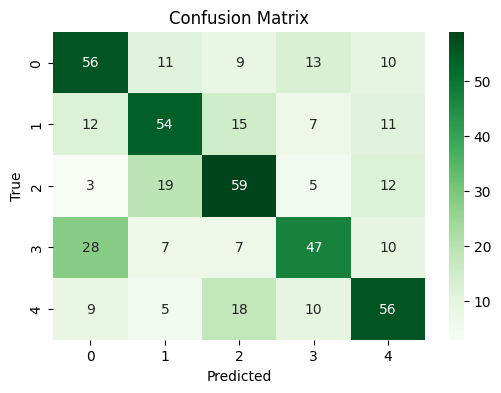

In [59]:
Dropi.load_state_dict(torch.load('/content/Dropi/Weights2/ckpt-900.pk'))
val_acc, val_loss = get_accuracy(Dropi,vt,vtst,"Greens" ,20,493)


Accuracy: 0.5496957403651116
Precision: 0.556757422414456
Recall: 0.5496957403651116


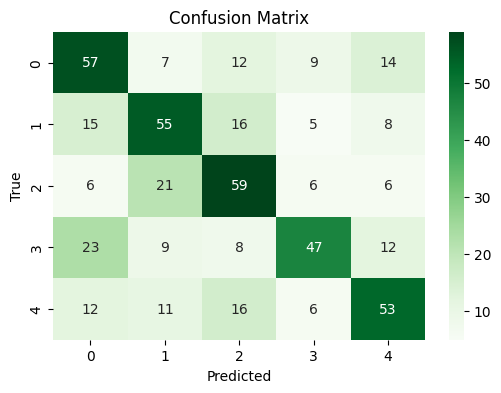

In [49]:
Dropi.load_state_dict(torch.load('/content/Dropi/Weights/ckpt-1000.pk'))
val_acc, val_loss = get_accuracy(Dropi,vt,vtst,"Greens" ,20,493)

****************Train****************

Accuracy: 0.55
Precision: 0.5797916666666666
Recall: 0.55


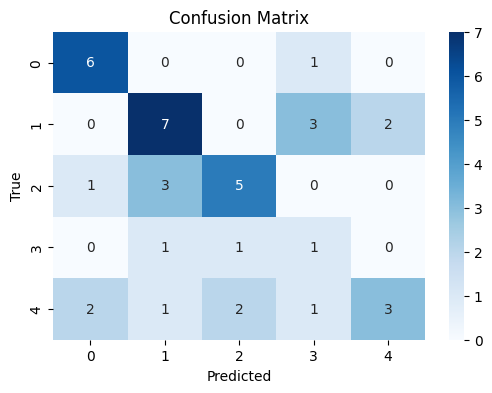

****************Validation****************

Accuracy: 0.475
Precision: 0.4516071428571428
Recall: 0.475


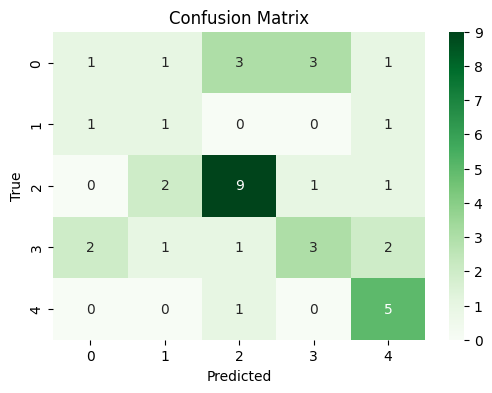

epoch 0 , Iter 100. [Val Acc 48%] [Train Acc 55%] [Train Loss 1.183264, Validation loss 1.413350]
****************Train****************

Accuracy: 0.75
Precision: 0.7700892857142857
Recall: 0.75


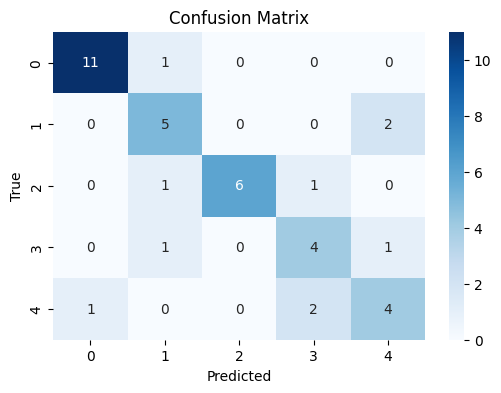

****************Validation****************

Accuracy: 0.5
Precision: 0.5137310606060606
Recall: 0.5


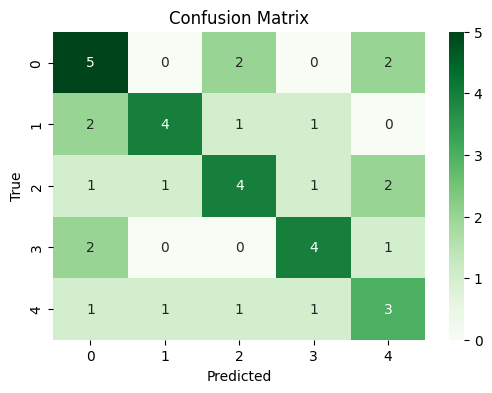

epoch 1 , Iter 200. [Val Acc 50%] [Train Acc 75%] [Train Loss 1.363158, Validation loss 1.384876]
****************Train****************

Accuracy: 0.625
Precision: 0.6587121212121212
Recall: 0.625


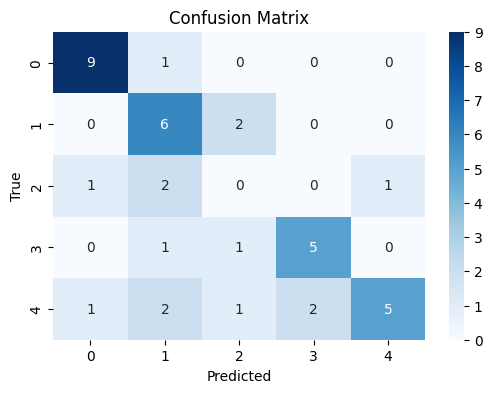

****************Validation****************

Accuracy: 0.55
Precision: 0.5553030303030303
Recall: 0.55


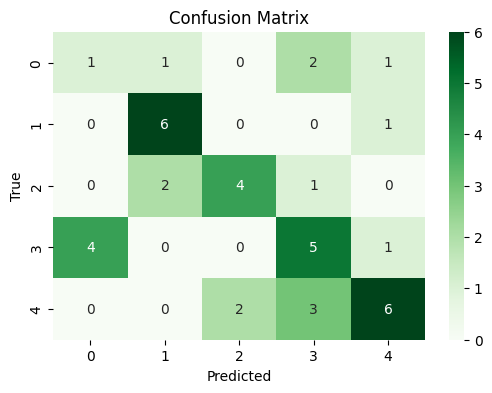

epoch 2 , Iter 300. [Val Acc 55%] [Train Acc 62%] [Train Loss 1.349333, Validation loss 1.342493]
****************Train****************

Accuracy: 0.65
Precision: 0.7014285714285714
Recall: 0.65


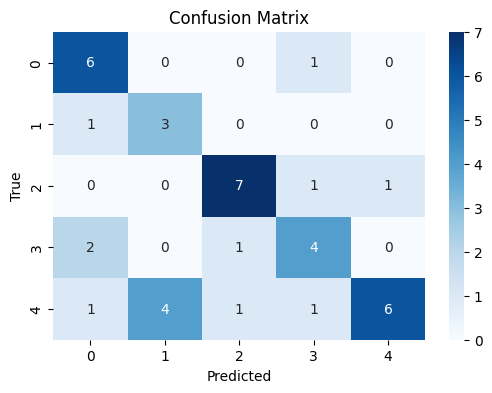

****************Validation****************

Accuracy: 0.625
Precision: 0.6319444444444444
Recall: 0.625


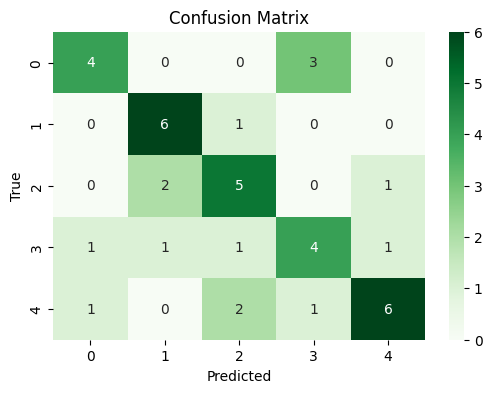

epoch 3 , Iter 400. [Val Acc 62%] [Train Acc 65%] [Train Loss 1.195930, Validation loss 1.251769]
****************Train****************

Accuracy: 0.675
Precision: 0.7188888888888889
Recall: 0.675


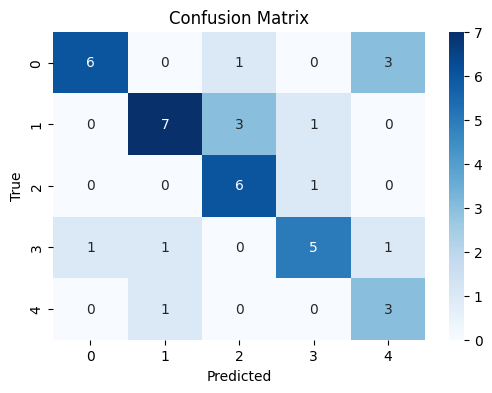

****************Validation****************

Accuracy: 0.55
Precision: 0.6239448051948051
Recall: 0.55


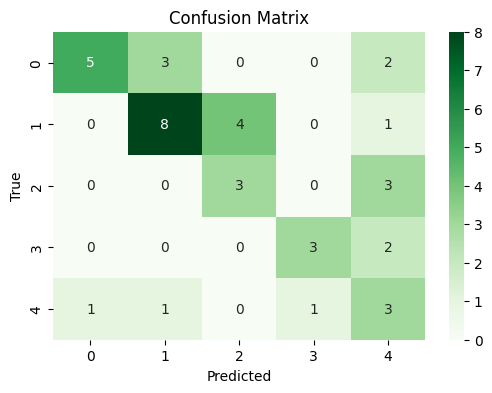

epoch 4 , Iter 500. [Val Acc 55%] [Train Acc 68%] [Train Loss 1.202857, Validation loss 1.333950]
****************Train****************

Accuracy: 0.6
Precision: 0.5908333333333333
Recall: 0.6


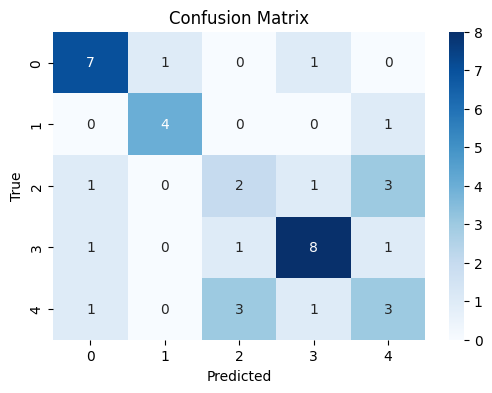

****************Validation****************

Accuracy: 0.45
Precision: 0.49190476190476196
Recall: 0.45


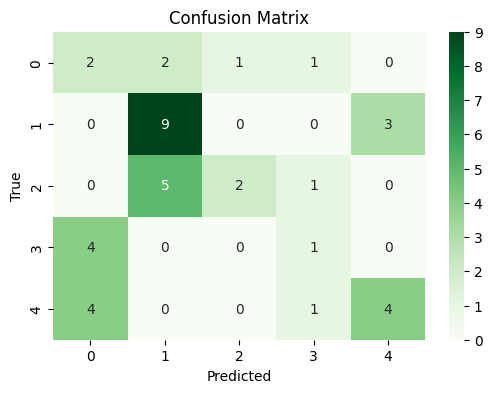

epoch 5 , Iter 600. [Val Acc 45%] [Train Acc 60%] [Train Loss 1.131166, Validation loss 1.404543]
****************Train****************

Accuracy: 0.675
Precision: 0.7204166666666667
Recall: 0.675


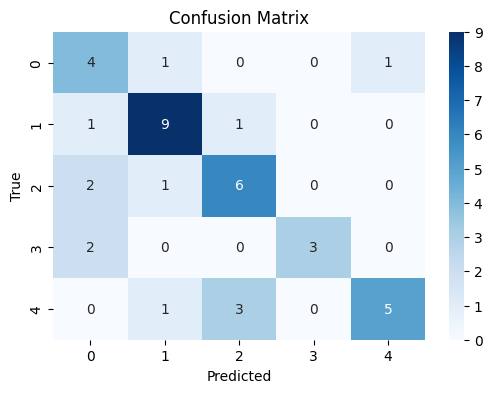

****************Validation****************

Accuracy: 0.675
Precision: 0.7055631868131869
Recall: 0.675


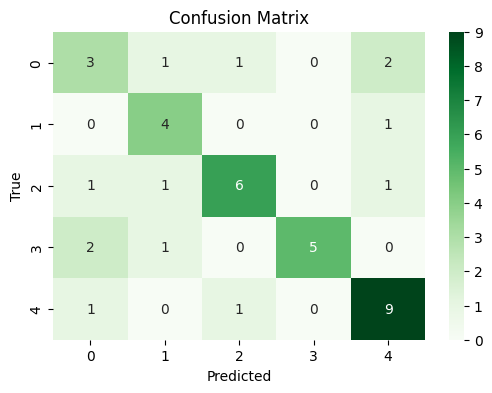

epoch 6 , Iter 700. [Val Acc 68%] [Train Acc 68%] [Train Loss 1.037986, Validation loss 1.222347]
****************Train****************

Accuracy: 0.675
Precision: 0.7213888888888889
Recall: 0.675


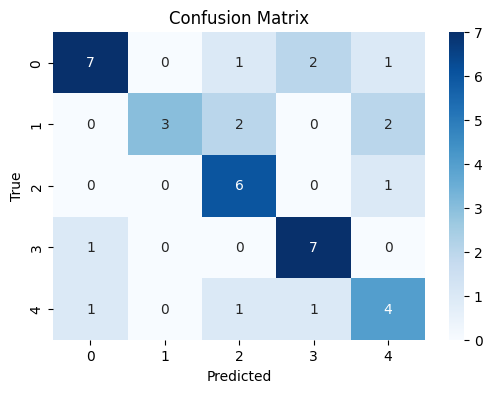

****************Validation****************

Accuracy: 0.625
Precision: 0.6518253968253969
Recall: 0.625


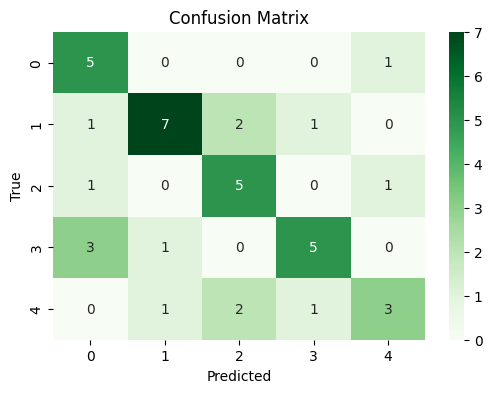

epoch 7 , Iter 800. [Val Acc 62%] [Train Acc 68%] [Train Loss 1.260626, Validation loss 1.282529]
****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.725
Precision: 0.8617647058823529
Recall: 0.725


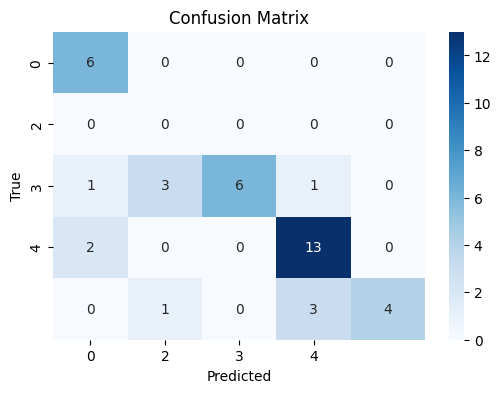

****************Validation****************

Accuracy: 0.575
Precision: 0.595
Recall: 0.575


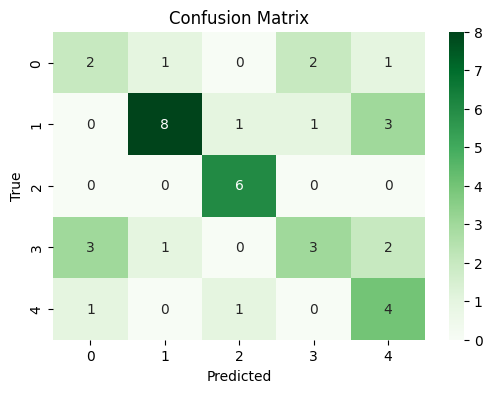

epoch 8 , Iter 900. [Val Acc 57%] [Train Acc 72%] [Train Loss 1.332491, Validation loss 1.304580]
****************Train****************

Accuracy: 0.775
Precision: 0.7958333333333333
Recall: 0.775


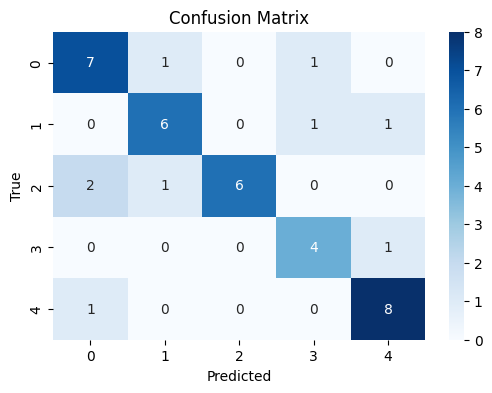

****************Validation****************

Accuracy: 0.575
Precision: 0.6354166666666666
Recall: 0.575


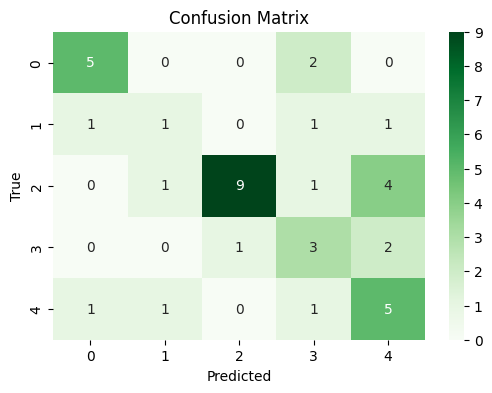

epoch 9 , Iter 1000. [Val Acc 57%] [Train Acc 78%] [Train Loss 1.449781, Validation loss 1.340233]
****************Train****************

Accuracy: 0.75
Precision: 0.7767094017094017
Recall: 0.75


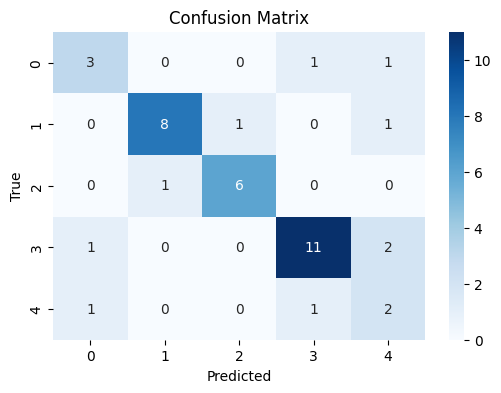

****************Validation****************

Accuracy: 0.625
Precision: 0.7042929292929293
Recall: 0.625


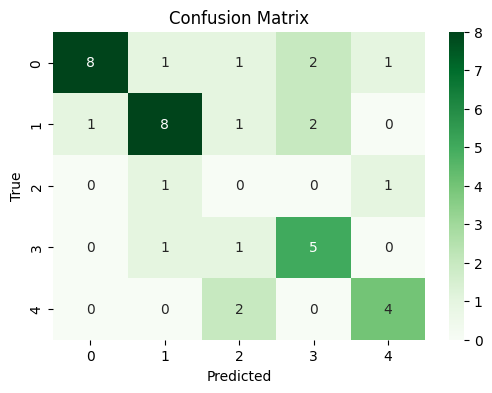

epoch 10 , Iter 1100. [Val Acc 62%] [Train Acc 75%] [Train Loss 1.299687, Validation loss 1.274857]
****************Train****************

Accuracy: 0.725
Precision: 0.788392857142857
Recall: 0.725


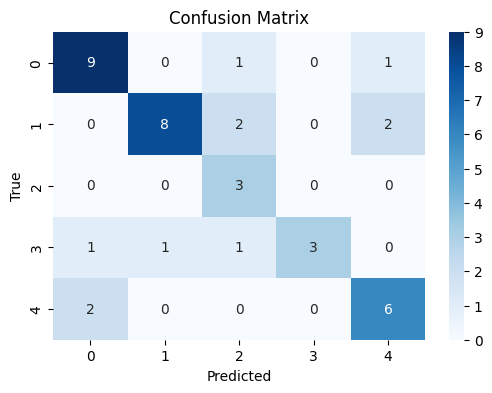

****************Validation****************

Accuracy: 0.6
Precision: 0.7214781746031746
Recall: 0.6


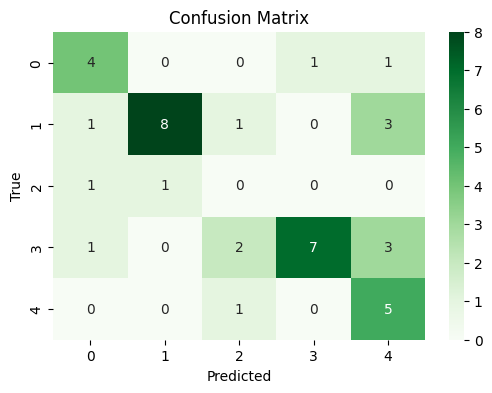

epoch 11 , Iter 1200. [Val Acc 60%] [Train Acc 72%] [Train Loss 1.089647, Validation loss 1.307137]
****************Train****************

Accuracy: 0.7
Precision: 0.735
Recall: 0.7


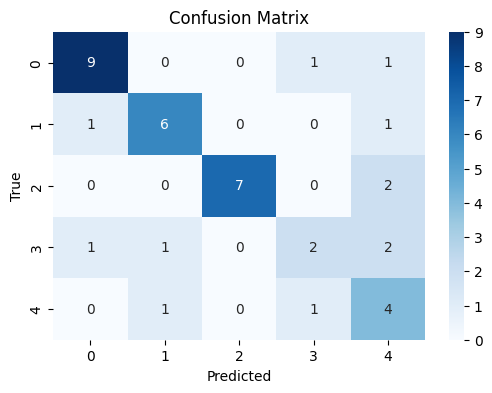

****************Validation****************

Accuracy: 0.45
Precision: 0.4286038961038961
Recall: 0.45


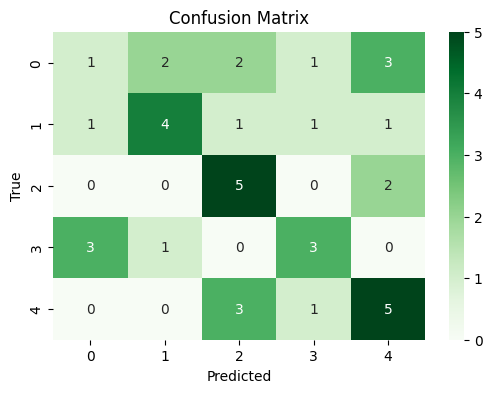

epoch 12 , Iter 1300. [Val Acc 45%] [Train Acc 70%] [Train Loss 1.310450, Validation loss 1.460048]
****************Train****************

Accuracy: 0.7
Precision: 0.7831529581529582
Recall: 0.7


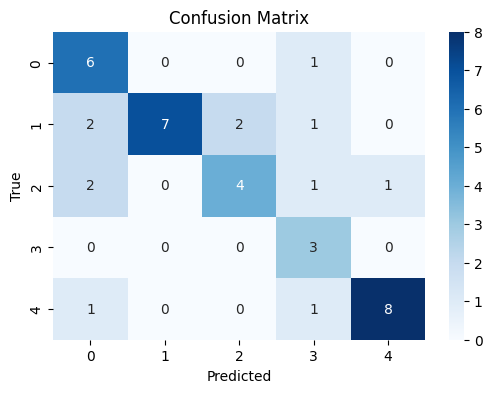

****************Validation****************

Accuracy: 0.425
Precision: 0.4367857142857143
Recall: 0.425


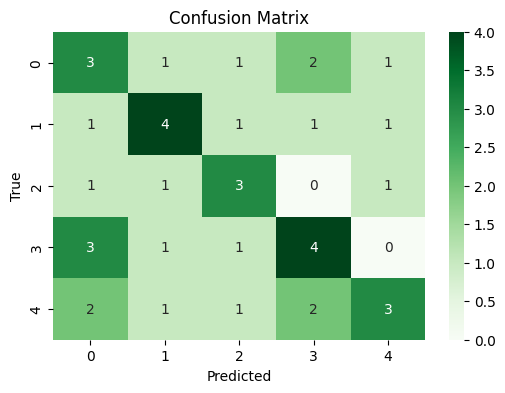

epoch 13 , Iter 1400. [Val Acc 42%] [Train Acc 70%] [Train Loss 1.103821, Validation loss 1.428091]
****************Train****************

Accuracy: 0.725
Precision: 0.735
Recall: 0.725


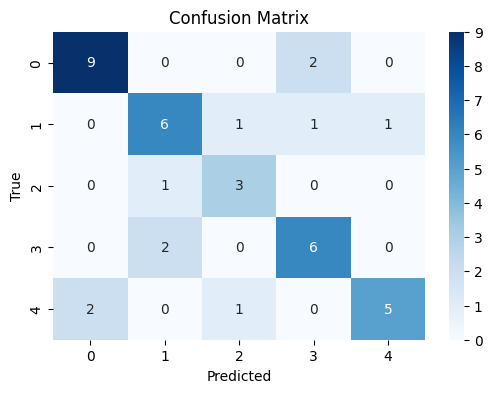

****************Validation****************

Accuracy: 0.55
Precision: 0.5308333333333334
Recall: 0.55


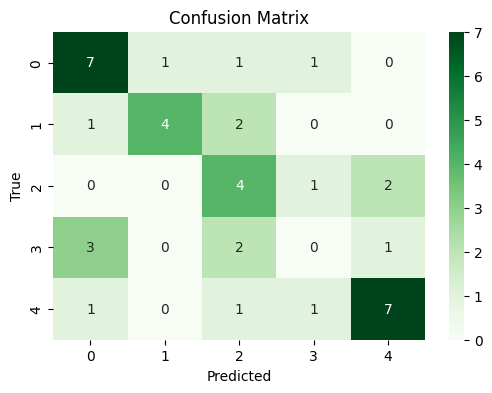

epoch 14 , Iter 1500. [Val Acc 55%] [Train Acc 72%] [Train Loss 1.143039, Validation loss 1.352371]
****************Train****************

Accuracy: 0.6
Precision: 0.64375
Recall: 0.6


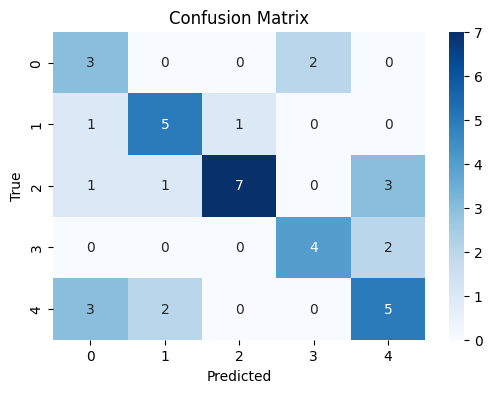

****************Validation****************

Accuracy: 0.675
Precision: 0.6783333333333333
Recall: 0.675


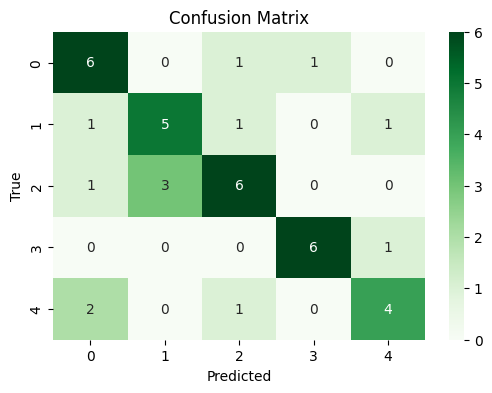

epoch 15 , Iter 1600. [Val Acc 68%] [Train Acc 60%] [Train Loss 1.344412, Validation loss 1.229683]


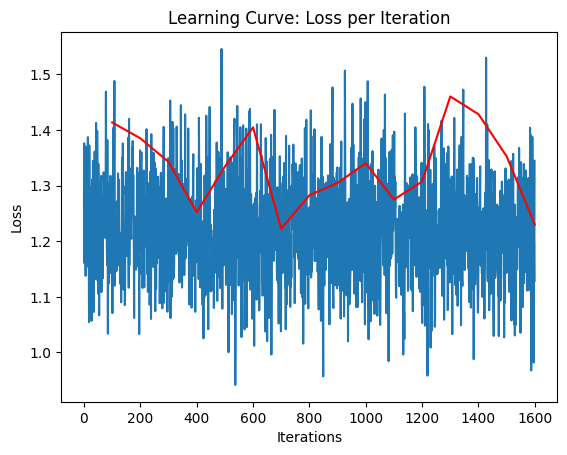

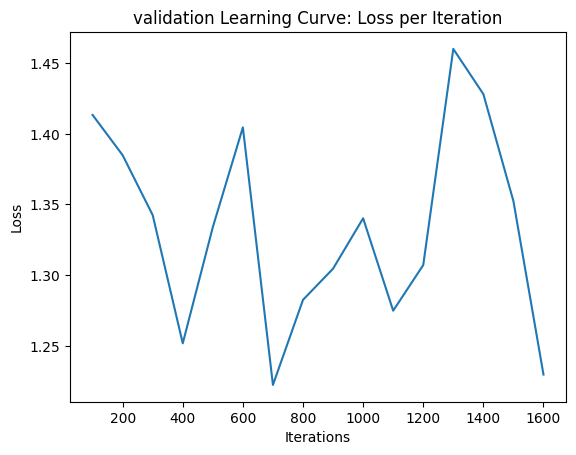

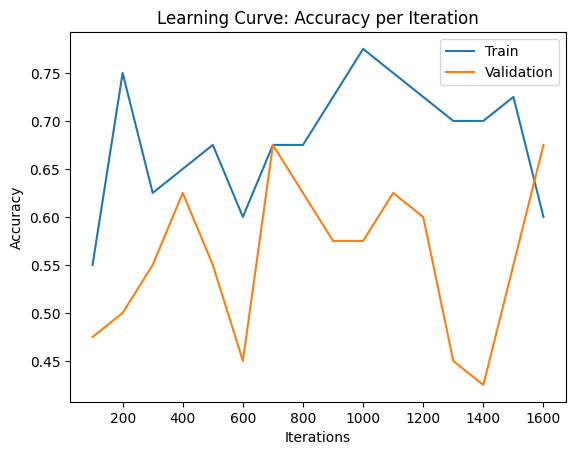

In [60]:
batch =20
m=0.000005
decay=0.001
Dropi.load_state_dict(torch.load('/content/Dropi/Weights2/ckpt-900.pk'))

learning_curve_info = run_pytorch_gradient_descent(Dropi,vt, vtst, xt,st,N_epochs=15, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Dropi/Weights3/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.5557809330628803
Precision: 0.5582164255441266
Recall: 0.5557809330628803


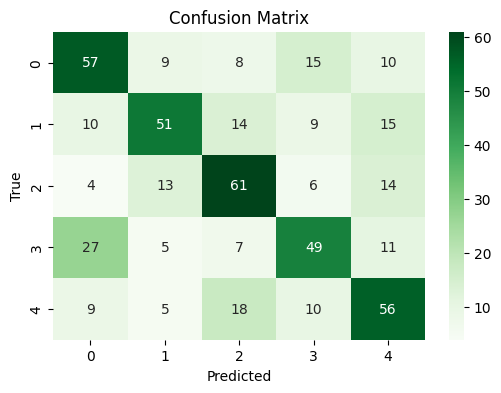

In [61]:
val_acc, val_loss = get_accuracy(Dropi,vt,vtst,"Greens" ,20,493)

#**Outcome Discussion and Insights**

After investing hours in attempting to achieve high accuracy rates and minimize loss, the results remain largely consistent. There is little variation observed over time. The majority of improvements occurred and were noticeable in the initial hour of training attempts. The subsequent time spent on this endeavor was primarily to confirm and validate that there is no hidden aspect resembling a concealed treasure waiting around the corner, about to be unveiled in the next attempt.

#*This approach leads us to an accuracy rate of approximately **65%** on the entire validation set. The addition of dropout layers and layer normalization has neither diminished these results to **55%**.*

On other sessions, I observed Dropi reach 65% accuracy rate similar to Aarti. But unfortunately, I did not save those weights and results.

Moving on to our next approach.

# **4. Compare models and experiment with ensemble method**
D. Experiment with ensemble methods


Comparing different models and experimenting with ensemble methods can enhance overall performance in machine learning tasks. By evaluating the last two models, each with its unique strengths and weaknesses, we can gain insights into their individual contributions to the task at hand. The ensemble method, which combines predictions from multiple models, can effectively leverage the diversity of these models, resulting in a more robust and accurate overall prediction. This approach allows us to mitigate the limitations of individual models and capitalize on their collective intelligence, ultimately improving the performance and generalization ability of the entire system.

Each of the two models achieves an accuracy rate of around 65%. The question is:

#*Are their contributions complementary?*

#*Will combining the two models in an ensemble method enhance overall performance?*

In [92]:
Dropi = Dropi_Art_NN(n=6)
Dropi.to(device)
print(Dropi)

Dropi_Art_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layernorm1): LayerNorm((3, 512, 512), eps=

In [93]:
Dropi.load_state_dict(torch.load('/content/Dropi/Weights3/ckpt-1600.pk'))

<All keys matched successfully>

In [84]:
Arti.to(device)

Art_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layernorm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
)

In [95]:
import torch
import torch.nn.functional as F

def ensemble_voting(model1, model2, xt,st_ac):
    """
    Perform voting using two PyTorch neural network models.

    Parameters:
    - model1 (nn.Module): First neural network model.
    - model2 (nn.Module): Second neural network model.
    - data_loader (DataLoader): PyTorch DataLoader for the input data.

    Returns:
    - predictions (Tensor): Aggregated predictions based on majority voting.
    """
    confusion_tracker = ConfusionMatrixTracker("Blues")
    model1.eval()
    model2.eval()
    model1 = model1.to(device)
    model2 = model2.to(device)

    all_predictions = []
    batch_size = 20
    #with torch.no_grad():
    for i in range(0, xt.shape[0], batch_size):
        XT = xt[i:i+batch_size]
        ST = st_ac[i:i+batch_size]
        inputs = torch.Tensor(XT.reshape(-1,512, 512, 3)).transpose(1, 3).transpose(2,3) #from [1024,1024,6] to [6,1024,1024]
        inputs = inputs.to(device)
        ST = torch.Tensor(ST).to(device)

                # Get softmax probabilities
        outputs1 = F.softmax(model1(inputs), dim=1)
        outputs2 = F.softmax(model2(inputs), dim=1)

        # Calculate confidence scores
        confidence1, predicted1 = torch.max(outputs1, 1)
        confidence2, predicted2 = torch.max(outputs2, 1)
        #print("outputs1=",outputs1)
        #print("outputs2=",outputs2)
        #print('confidence1=',confidence1, '\npredicted1=', predicted1)
        #print('confidence2=',confidence2, '\npredicted1=', predicted2)

        # Weighted voting based on confidence scores
        '''
        ensemble_predictions = (
            outputs1 * (confidence1 ).float().unsqueeze(1) +
            outputs2 * (confidence2 ).float().unsqueeze(1)
        )
        '''
        blend = (
            outputs1 * (confidence1 ).float().unsqueeze(1) +
            outputs2 * (confidence2 ).float().unsqueeze(1)
        )
        confidence_threshold = 0.1

        # Calculate absolute difference between confidence1 and confidence2
        confidence_diff = torch.abs(confidence1 - confidence2)

        # Create masks for different conditions
        mask1_confident = confidence1 - confidence2 > confidence_threshold
        mask2_confident = confidence2 - confidence1 > confidence_threshold
        mask_within_threshold = confidence_diff <= confidence_threshold

        # Initialize ensemble_predictions with zeros
        ensemble_predictions = torch.zeros_like(outputs1)

        # Assign predictions based on conditions
        ensemble_predictions[mask1_confident] = outputs1[mask1_confident]
        ensemble_predictions[mask2_confident] = outputs2[mask2_confident]

        # Handle the case when the confidence difference is within the threshold
        # For this example, we choose model1 as the default, but you can modify it based on your requirements
        ensemble_predictions[mask_within_threshold] = blend[mask_within_threshold]

        #print("ensemble_predictions=",ensemble_predictions)

        # Perform majority voting
        #ensemble_predictions = (outputs1 + outputs2)
        all_predictions.extend(ensemble_predictions.detach().cpu().numpy())

    confusion_tracker.update(st_ac, all_predictions)
    cm, accuracy, precision, recall, f1 = confusion_tracker.calculate_metrics()
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    #print("F1 Score:", f1)

    # Visualize confusion matrix
    confusion_tracker.plot_confusion_matrix()

    return torch.tensor(all_predictions)

# Example usage:
# Assuming you have two trained models model1 and model2, and a DataLoader named test_loader
# predictions = ensemble_voting(model1, model2, test_loader)



Accuracy: 0.6206896551724138
Precision: 0.622888643740536
Recall: 0.6206896551724138


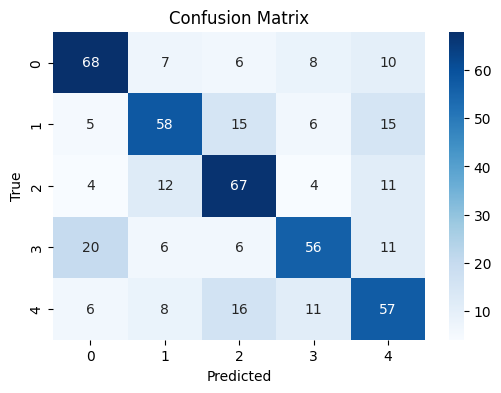

<ipython-input-95-7d201bf3798c>:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(all_predictions)


In [96]:
all_predictions = ensemble_voting(Dropi,Arti,vt,vtst)


Accuracy: 0.6450304259634888
Precision: 0.6534471122102212
Recall: 0.6450304259634888


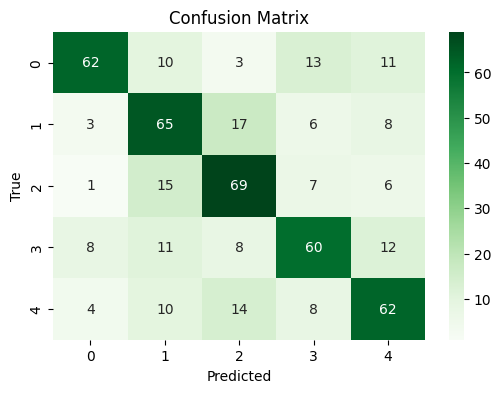

In [97]:
val_acc, val_loss = get_accuracy(Arti,vt,vtst,"Greens" ,20,493)


Accuracy: 0.5557809330628803
Precision: 0.5582164255441266
Recall: 0.5557809330628803


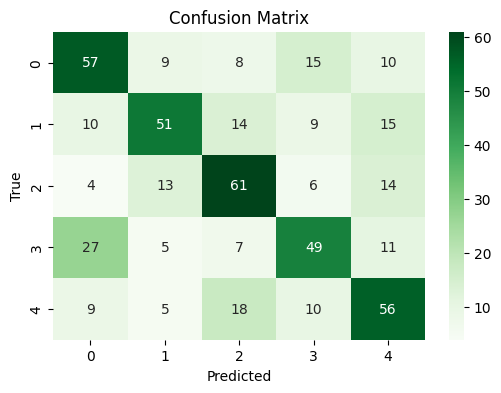

In [98]:
val_acc, val_loss = get_accuracy(Dropi,vt,vtst,"Greens" ,20,493)

# **Outcome Discussion and Insights**

Despite initial expectations, the ensemble method did not lead to a significant improvement in performance. Several factors may contribute to this result. It's possible that the two models employed in the ensemble exhibit similar strengths and weaknesses, limiting the diversity crucial for ensemble effectiveness.

Moving on to our next approach.

# **6.   Use Untrained RESNET from torchvision.models**

Now, we will employ an untrained RESNET from torchvision.models and assess its performance after multiple training sessions. The motivation behind this action is to compare a state-of-the-art architecture to our CNN models, Dropi and Arti. The task at hand requires a solution composed of three integral components:

1.   Data
2.   **Architecture**
3.   Training approach

This action will help us isolate our architecture component and have a comparison baseline. Obviusly, I did not invest in the logic behind my simple CNN as much as was invested in RESNET18 by the writers of 'Deep Residual Learning for Image Recognition'. But if these models reach the same 65% accuracy rate, then we can know the simplicity of our models archtecture might not be our main issue.

This action allows us to isolate the architecture component, providing a baseline for comparison. Clearly, the level of investment in the logic behind our simple CNN, Dropi and Arti, does not match that of RESNET18 architecture as proposed in 'Deep Residual Learning for Image Recognition'. However, if these models achieve a comparable 65% accuracy rate, it suggests that the simplicity of our models' architecture may not be the primary limiting component.


In [108]:
import torchvision
from torchvision import datasets, models, transforms
Untrained_resnet = models.resnet18(pretrained=False)
print(Untrained_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [109]:
num_classes =5
# Modify fc layers to match num_classes
num_ftrs = Untrained_resnet.fc.in_features
Untrained_resnet.fc = nn.Linear(num_ftrs,num_classes )
Untrained_resnet = Untrained_resnet.to(device)

In [102]:
print(Untrained_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#C. Resize all the images to the same dimensions (224,224,3) as used for RESNET18 inputs
This is done to shorten the running time of the training.
We need to resize and fit all the paintings to the same scale (224,224,3).
We are going to use Image from PIL.

In [105]:
from PIL import Image

# Assuming you have a NumPy array `xt` containing images
# Define the target size
target_size = (224,224)

# Create an empty array to store the resized and cropped images
resized_images = []

# Iterate through the images in `xt` and resize them to the target size
for image in xt:
    current_height, current_width, channels = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / current_width
    height_scale = target_size[1] / current_height

    # Choose the maximum scaling factor that still fits within the target size
    scale_factor = max(width_scale, height_scale)

    # Calculate the new dimensions after resizing
    new_width = int(current_width * scale_factor)
    new_height = int(current_height * scale_factor)

    # Resize the image using the calculated dimensions
    resized_image = Image.fromarray((image).astype(np.uint8))
    resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)

    # Calculate the crop box to get the center portion of the resized image
    left = (new_width - target_size[0]) / 2
    top = (new_height - target_size[1]) / 2
    right = (new_width + target_size[0]) / 2
    bottom = (new_height + target_size[1]) / 2

    # Crop the resized image to the target size
    cropped_image = resized_image.crop((left, top, right, bottom))

    # Convert the cropped image back to a NumPy array
    cropped_image = np.array(cropped_image)

    # Append the resized and cropped image to the result
    resized_images.append(cropped_image)

# Convert the list of resized and cropped images back to a NumPy array
xt = np.array(resized_images)
del resized_images


<ipython-input-105-f44917228e9b>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)


Same but for validation data:

In [106]:
from PIL import Image

# Assuming you have a NumPy array `xt` containing images
# Define the target size
target_size = (224,224)

# Create an empty array to store the resized and cropped images
resized_images = []

# Iterate through the images in `xt` and resize them to the target size
for image in vt:
    current_height, current_width, channels = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / current_width
    height_scale = target_size[1] / current_height

    # Choose the maximum scaling factor that still fits within the target size
    scale_factor = max(width_scale, height_scale)

    # Calculate the new dimensions after resizing
    new_width = int(current_width * scale_factor)
    new_height = int(current_height * scale_factor)

    # Resize the image using the calculated dimensions
    resized_image = Image.fromarray((image).astype(np.uint8))
    resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)

    # Calculate the crop box to get the center portion of the resized image
    left = (new_width - target_size[0]) / 2
    top = (new_height - target_size[1]) / 2
    right = (new_width + target_size[0]) / 2
    bottom = (new_height + target_size[1]) / 2

    # Crop the resized image to the target size
    cropped_image = resized_image.crop((left, top, right, bottom))

    # Convert the cropped image back to a NumPy array
    cropped_image = np.array(cropped_image)

    # Append the resized and cropped image to the result
    resized_images.append(cropped_image)

# Convert the list of resized and cropped images back to a NumPy array
vt = np.array(resized_images)
del resized_images


<ipython-input-106-ea307f5d35df>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = resized_image.resize((new_width, new_height), Image.ANTIALIAS)


In [107]:
print(xt.shape)
print(vt.shape)

(1989, 224, 224, 3)
(493, 224, 224, 3)


****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.525
Precision: 0.591826923076923
Recall: 0.525


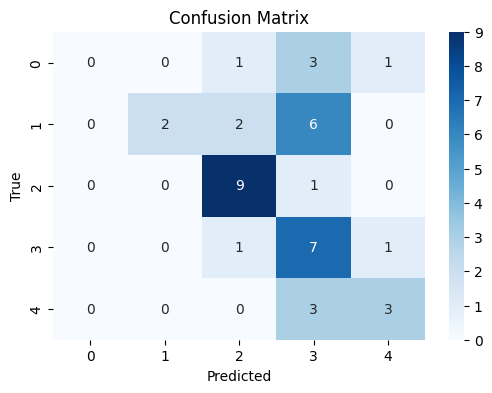

****************Validation****************

Accuracy: 0.55
Precision: 0.708173076923077
Recall: 0.55


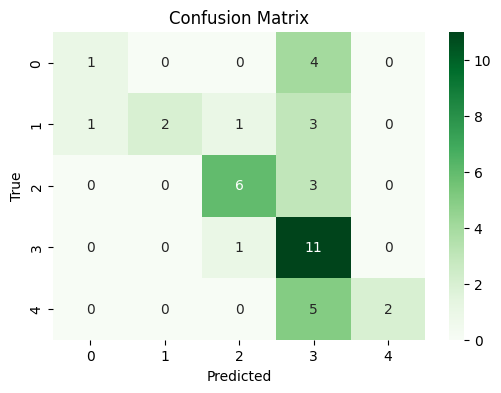

epoch 0 , Iter 100. [Val Acc 55%] [Train Acc 52%] [Train Loss 1.200984, Validation loss 1.163522]
****************Train****************

Accuracy: 0.475
Precision: 0.6145021645021644
Recall: 0.475


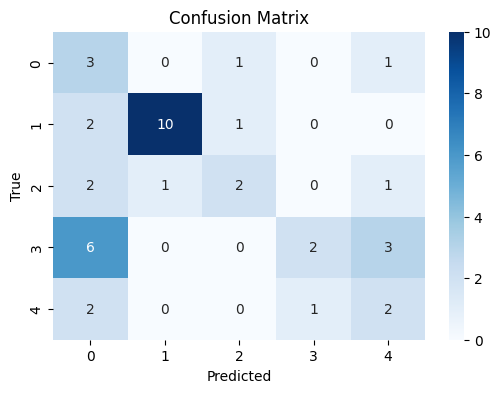

****************Validation****************

Accuracy: 0.65
Precision: 0.6830357142857143
Recall: 0.65


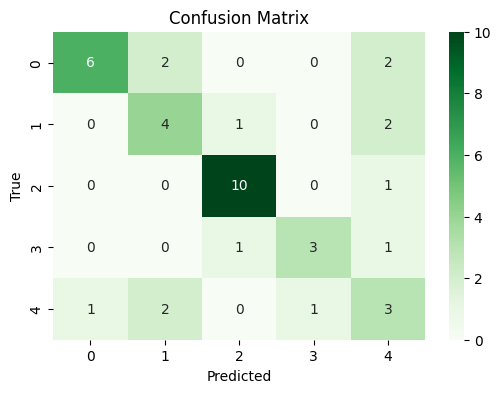

epoch 1 , Iter 200. [Val Acc 65%] [Train Acc 48%] [Train Loss 1.087529, Validation loss 1.043453]
****************Train****************

Accuracy: 0.6
Precision: 0.7852516233766235
Recall: 0.6


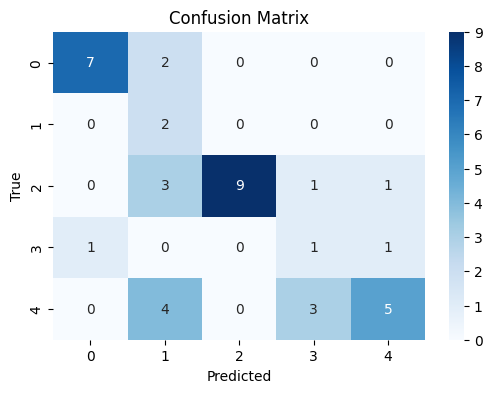

****************Validation****************

Accuracy: 0.525
Precision: 0.6912393162393162
Recall: 0.525


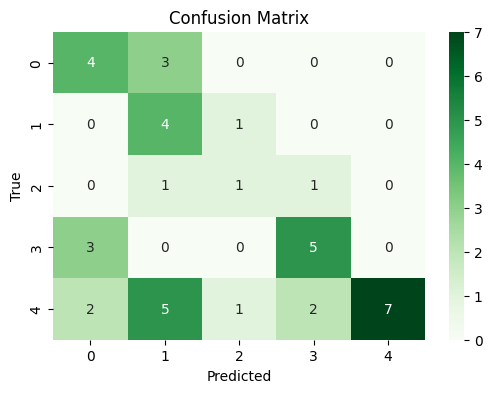

epoch 2 , Iter 300. [Val Acc 52%] [Train Acc 60%] [Train Loss 0.598275, Validation loss 1.188835]
****************Train****************

Accuracy: 0.825
Precision: 0.8423232323232324
Recall: 0.825


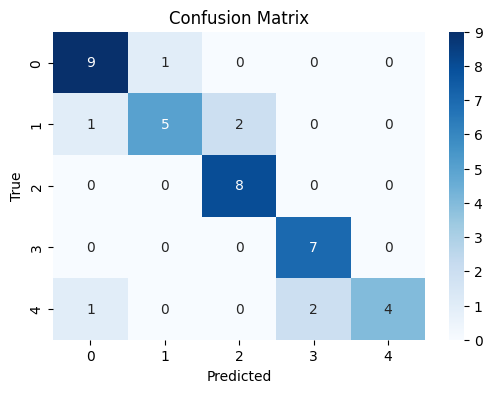

****************Validation****************

Accuracy: 0.575
Precision: 0.5191666666666667
Recall: 0.575


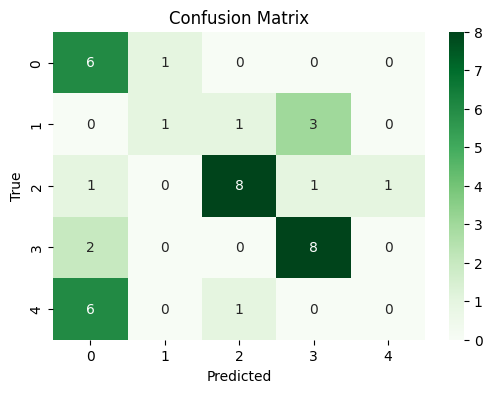

epoch 3 , Iter 400. [Val Acc 57%] [Train Acc 82%] [Train Loss 0.942483, Validation loss 1.132385]
****************Train****************

Accuracy: 0.675
Precision: 0.757361111111111
Recall: 0.675


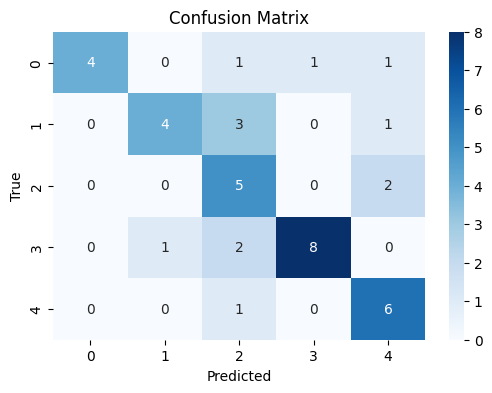

****************Validation****************

Accuracy: 0.55
Precision: 0.6053632478632479
Recall: 0.55


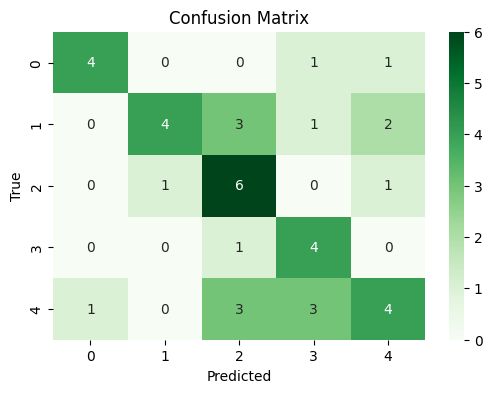

epoch 4 , Iter 500. [Val Acc 55%] [Train Acc 68%] [Train Loss 1.336249, Validation loss 1.059135]
****************Train****************

Accuracy: 0.7
Precision: 0.7548295454545455
Recall: 0.7


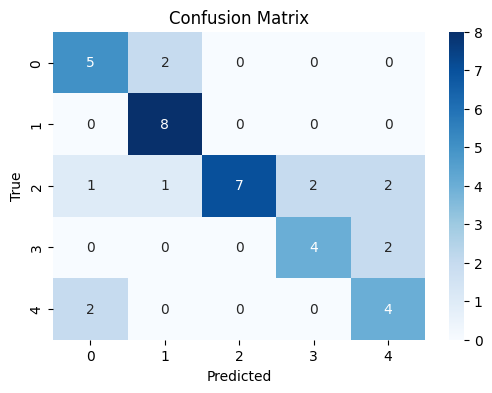

****************Validation****************

Accuracy: 0.6
Precision: 0.6085678210678209
Recall: 0.6


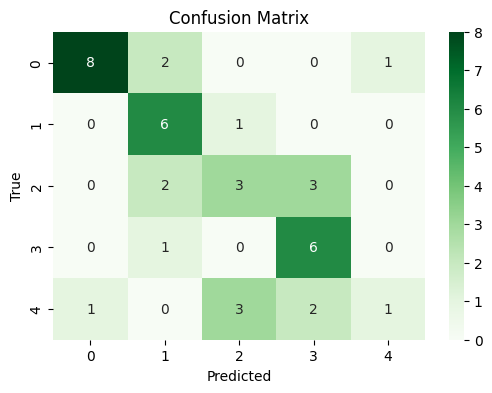

epoch 5 , Iter 600. [Val Acc 60%] [Train Acc 70%] [Train Loss 1.192868, Validation loss 1.127448]
****************Train****************

Accuracy: 0.6
Precision: 0.6636752136752136
Recall: 0.6


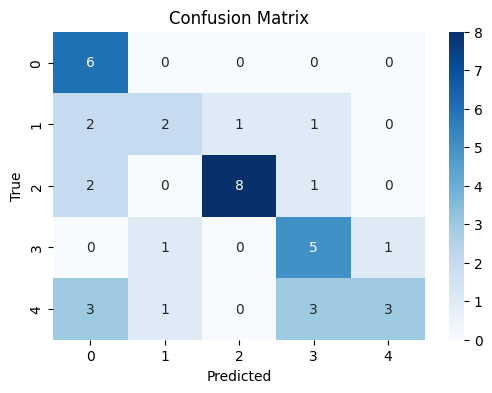

****************Validation****************

Accuracy: 0.45
Precision: 0.4452272727272727
Recall: 0.45


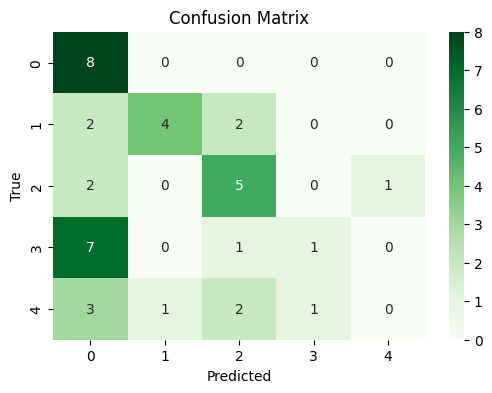

epoch 6 , Iter 700. [Val Acc 45%] [Train Acc 60%] [Train Loss 1.384519, Validation loss 1.437887]
****************Train****************

Accuracy: 0.925
Precision: 0.93
Recall: 0.925


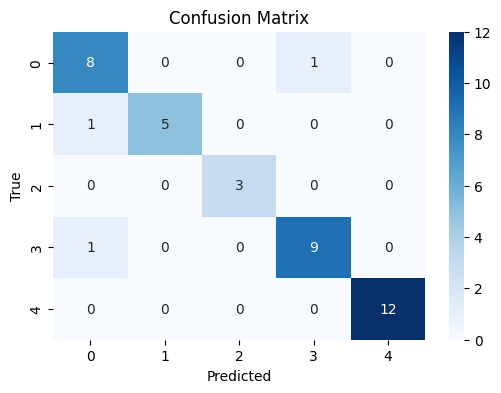

****************Validation****************

Accuracy: 0.65
Precision: 0.6878434065934066
Recall: 0.65


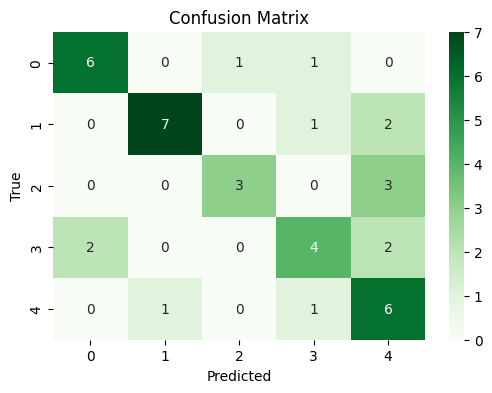

epoch 7 , Iter 800. [Val Acc 65%] [Train Acc 92%] [Train Loss 0.952195, Validation loss 1.046836]
****************Train****************

Accuracy: 0.8
Precision: 0.8545299145299146
Recall: 0.8


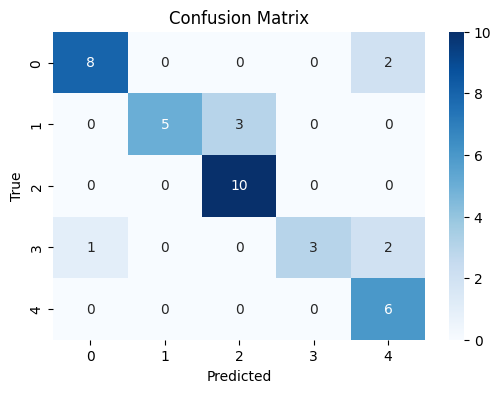

****************Validation****************

Accuracy: 0.6
Precision: 0.625357142857143
Recall: 0.6


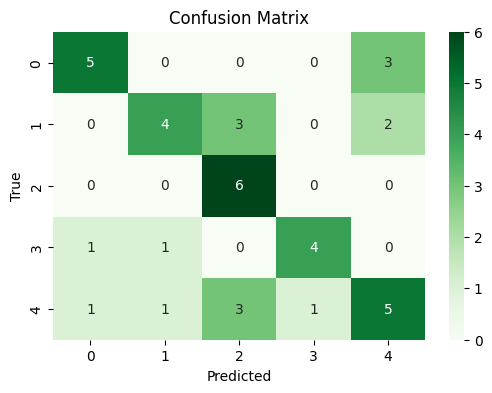

epoch 8 , Iter 900. [Val Acc 60%] [Train Acc 80%] [Train Loss 0.870070, Validation loss 1.008444]
****************Train****************

Accuracy: 0.675
Precision: 0.7328787878787878
Recall: 0.675


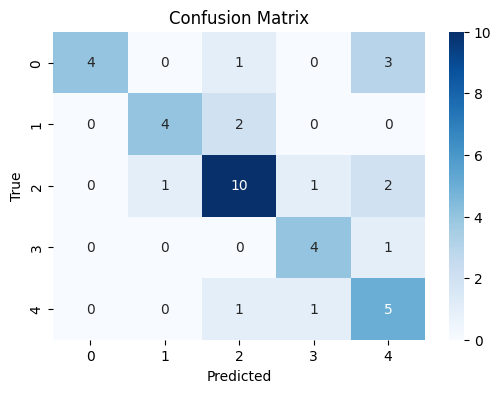

****************Validation****************

Accuracy: 0.625
Precision: 0.6794642857142857
Recall: 0.625


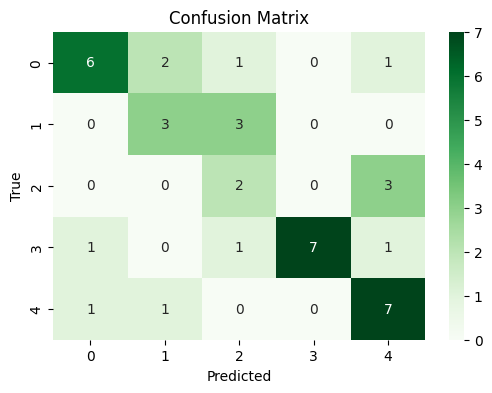

epoch 9 , Iter 1000. [Val Acc 62%] [Train Acc 68%] [Train Loss 0.619252, Validation loss 1.022196]
****************Train****************

Accuracy: 0.75
Precision: 0.8786324786324787
Recall: 0.75


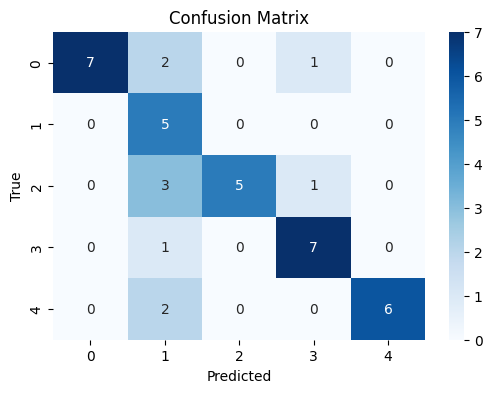

****************Validation****************

Accuracy: 0.6
Precision: 0.6794258373205742
Recall: 0.6


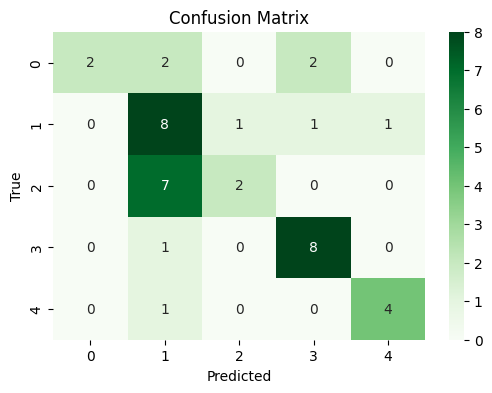

epoch 10 , Iter 1100. [Val Acc 60%] [Train Acc 75%] [Train Loss 0.942233, Validation loss 1.033217]
****************Train****************

Accuracy: 0.675
Precision: 0.7328125
Recall: 0.675


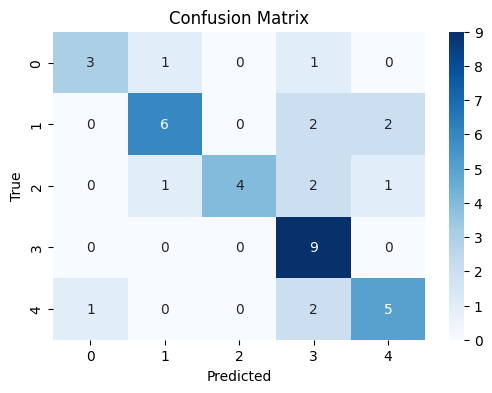

****************Validation****************

Accuracy: 0.525
Precision: 0.56375
Recall: 0.525


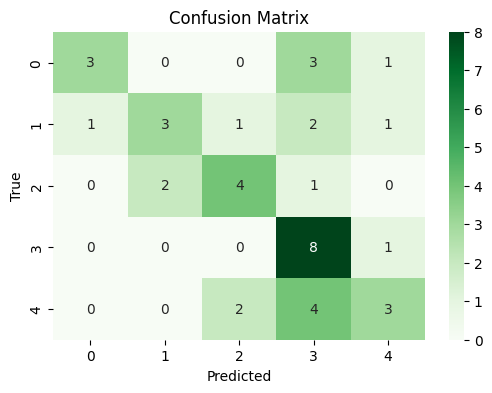

epoch 11 , Iter 1200. [Val Acc 52%] [Train Acc 68%] [Train Loss 1.239728, Validation loss 1.347158]
****************Train****************

Accuracy: 0.7
Precision: 0.724404761904762
Recall: 0.7


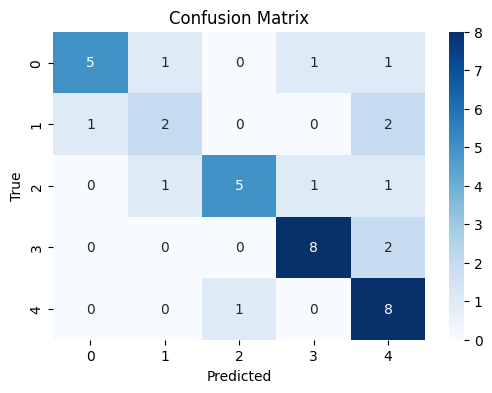

****************Validation****************

Accuracy: 0.725
Precision: 0.7982142857142857
Recall: 0.725


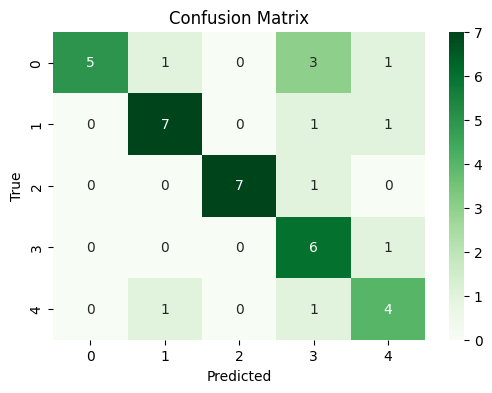

epoch 12 , Iter 1300. [Val Acc 72%] [Train Acc 70%] [Train Loss 0.915537, Validation loss 0.859921]
****************Train****************

Accuracy: 0.775
Precision: 0.823645104895105
Recall: 0.775


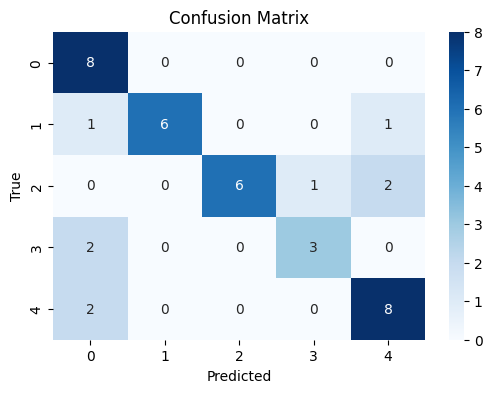

****************Validation****************

Accuracy: 0.475
Precision: 0.5802777777777778
Recall: 0.475


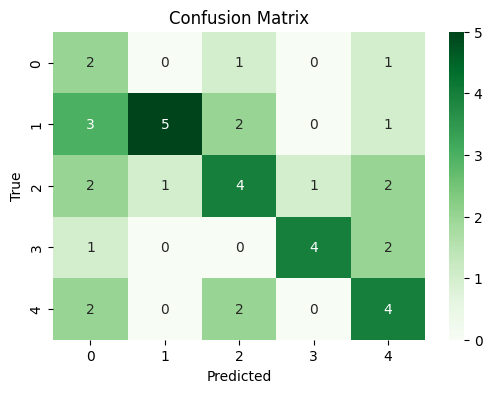

epoch 13 , Iter 1400. [Val Acc 48%] [Train Acc 78%] [Train Loss 0.332826, Validation loss 1.338965]
****************Train****************

Accuracy: 0.5
Precision: 0.6483173076923077
Recall: 0.5


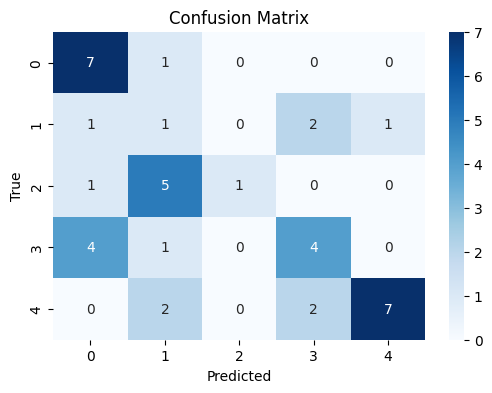

****************Validation****************

Accuracy: 0.6
Precision: 0.6847222222222223
Recall: 0.6


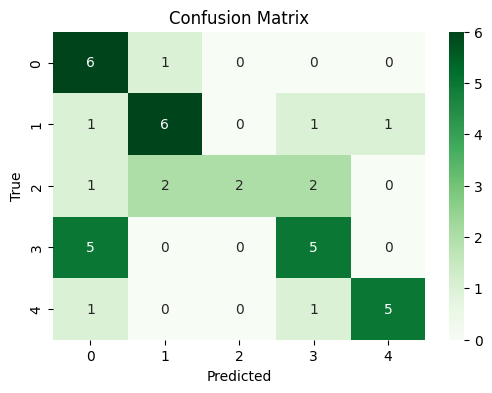

epoch 14 , Iter 1500. [Val Acc 60%] [Train Acc 50%] [Train Loss 0.285686, Validation loss 0.968473]
****************Train****************

Accuracy: 0.75
Precision: 0.7826785714285714
Recall: 0.75


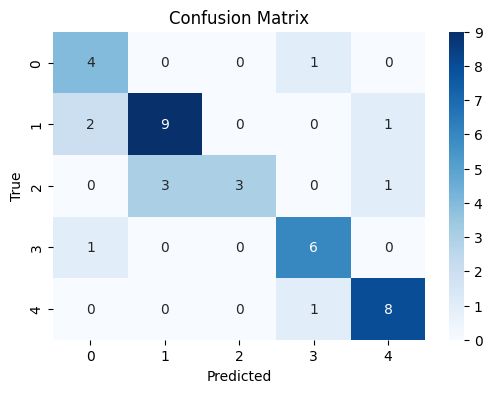

****************Validation****************

Accuracy: 0.475
Precision: 0.5147727272727273
Recall: 0.475


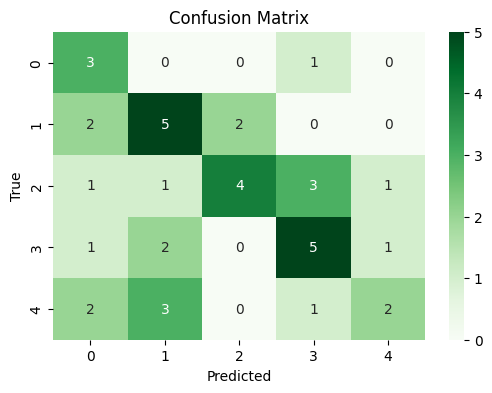

epoch 15 , Iter 1600. [Val Acc 48%] [Train Acc 75%] [Train Loss 0.353197, Validation loss 1.482238]
****************Train****************

Accuracy: 0.825
Precision: 0.9015625
Recall: 0.825


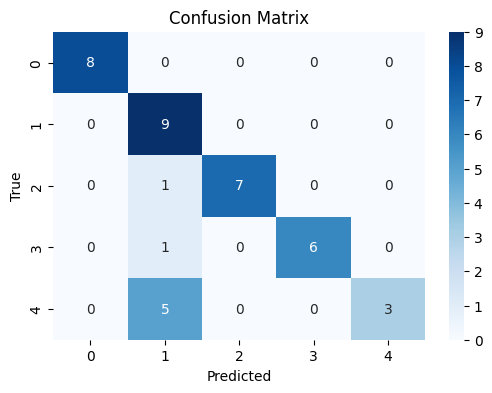

****************Validation****************

Accuracy: 0.55
Precision: 0.49017857142857135
Recall: 0.55


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


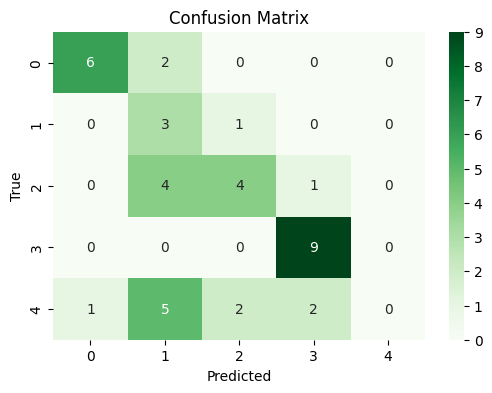

epoch 16 , Iter 1700. [Val Acc 55%] [Train Acc 82%] [Train Loss 1.033602, Validation loss 1.234214]
****************Train****************

Accuracy: 0.9
Precision: 0.9107954545454545
Recall: 0.9


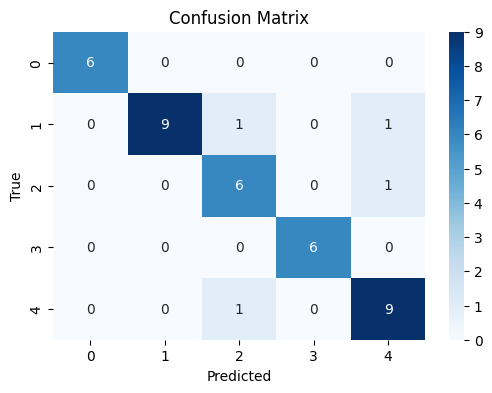

****************Validation****************

Accuracy: 0.6
Precision: 0.65625
Recall: 0.6


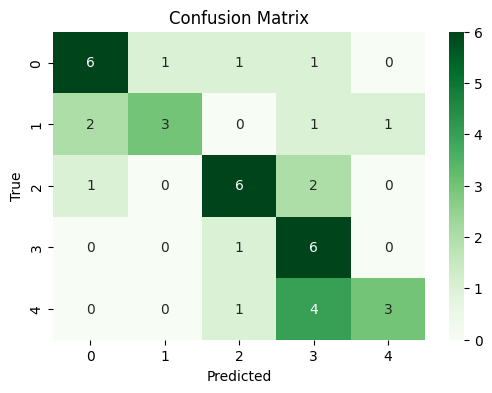

epoch 17 , Iter 1800. [Val Acc 60%] [Train Acc 90%] [Train Loss 0.233956, Validation loss 1.277110]
****************Train****************

Accuracy: 0.95
Precision: 0.9555555555555555
Recall: 0.95


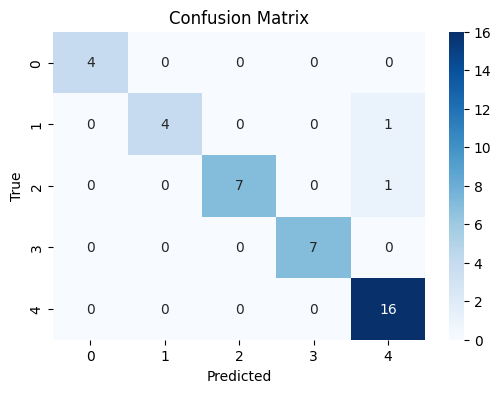

****************Validation****************

Accuracy: 0.525
Precision: 0.5868022328548644
Recall: 0.525


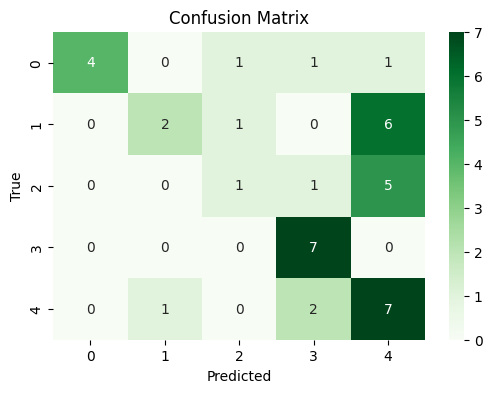

epoch 18 , Iter 1900. [Val Acc 52%] [Train Acc 95%] [Train Loss 0.254915, Validation loss 1.900356]
****************Train****************

Accuracy: 0.975
Precision: 0.976923076923077
Recall: 0.975


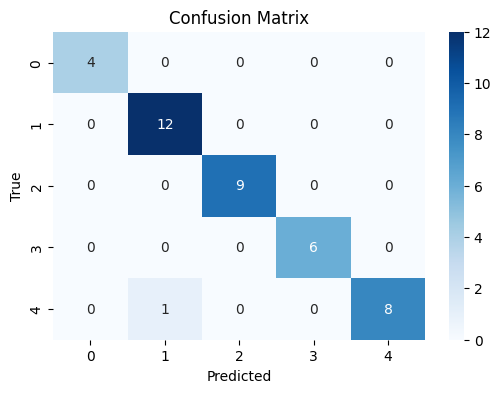

****************Validation****************

Accuracy: 0.55
Precision: 0.5833333333333333
Recall: 0.55


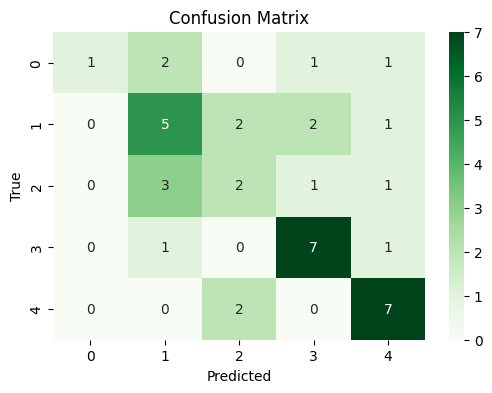

epoch 19 , Iter 2000. [Val Acc 55%] [Train Acc 98%] [Train Loss 0.229773, Validation loss 1.355256]
****************Train****************

Accuracy: 0.95
Precision: 0.9527777777777778
Recall: 0.95


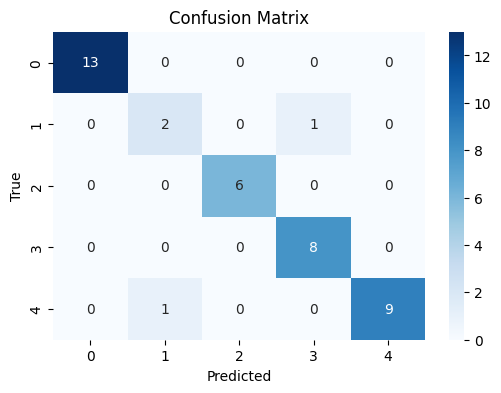

****************Validation****************

Accuracy: 0.575
Precision: 0.6501488095238095
Recall: 0.575


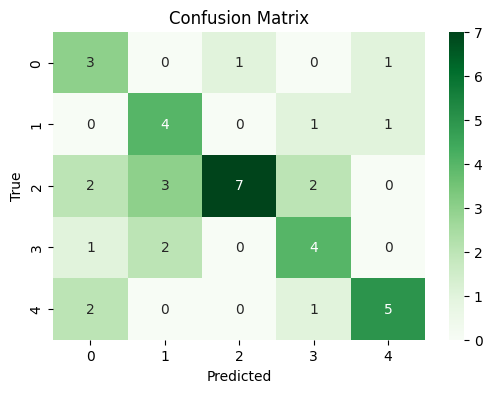

epoch 20 , Iter 2100. [Val Acc 57%] [Train Acc 95%] [Train Loss 0.069726, Validation loss 1.963000]


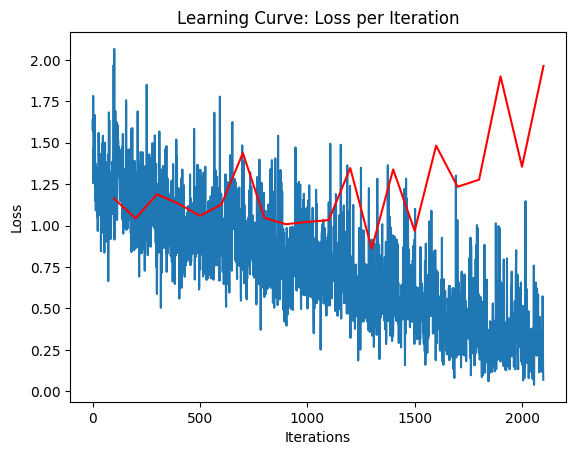

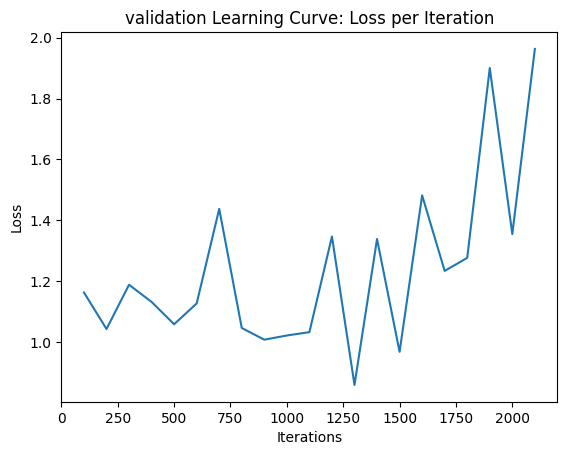

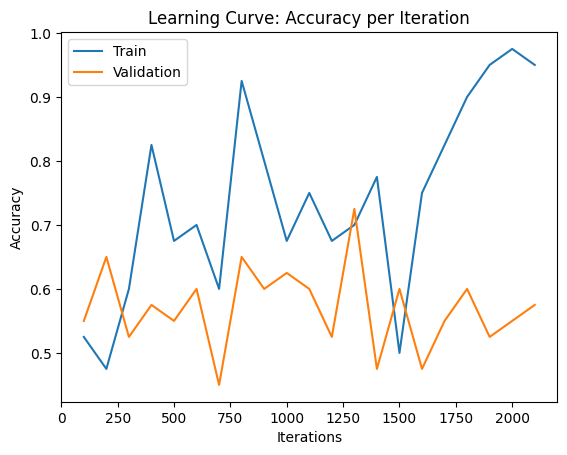

In [110]:
batch =20
m=0.0001
decay=0.001

learning_curve_info = run_pytorch_gradient_descent(Untrained_resnet,vt, vtst, xt,st,N_epochs=20, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Resnet/Weights/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.5801217038539553
Precision: 0.6227195452047731
Recall: 0.5801217038539553


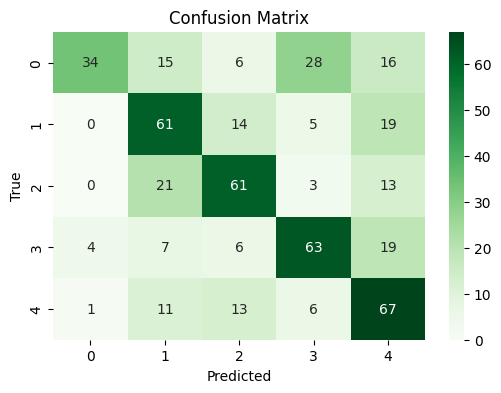

In [111]:
Untrained_resnet.load_state_dict(torch.load('/content/Resnet/Weights/ckpt-1300.pk'))
val_acc, val_loss = get_accuracy(Untrained_resnet,vt,vtst,"Greens" ,20,493)

****************Train****************

Accuracy: 0.925
Precision: 0.93
Recall: 0.925


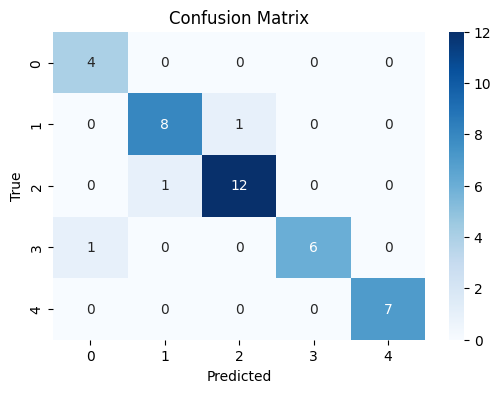

****************Validation****************

Accuracy: 0.725
Precision: 0.7576298701298702
Recall: 0.725


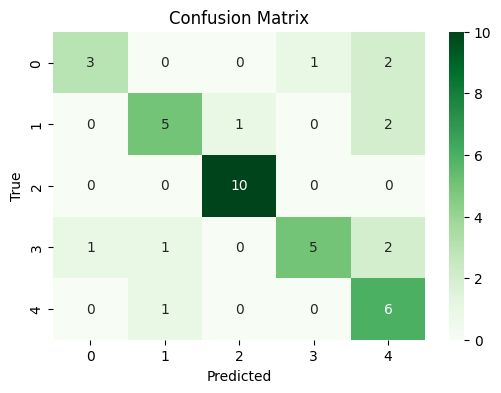

epoch 0 , Iter 100. [Val Acc 72%] [Train Acc 92%] [Train Loss 0.205360, Validation loss 0.664269]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


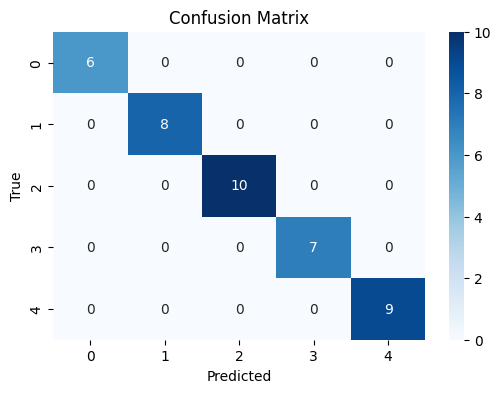

****************Validation****************

Accuracy: 0.75
Precision: 0.7946428571428571
Recall: 0.75


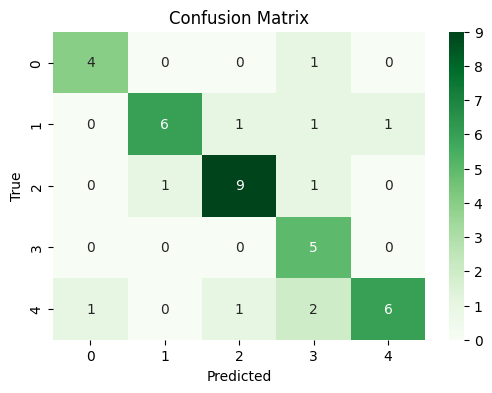

epoch 1 , Iter 200. [Val Acc 75%] [Train Acc 100%] [Train Loss 0.191699, Validation loss 0.944429]
****************Train****************

Accuracy: 0.95
Precision: 0.9556250000000001
Recall: 0.95


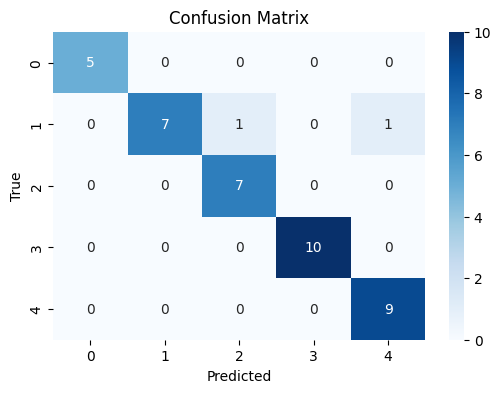

****************Validation****************

Accuracy: 0.525
Precision: 0.55625
Recall: 0.525


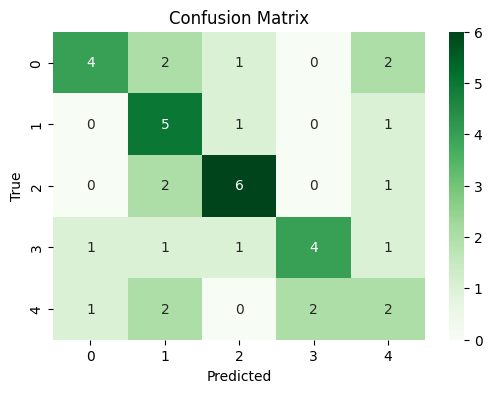

epoch 2 , Iter 300. [Val Acc 52%] [Train Acc 95%] [Train Loss 0.268963, Validation loss 1.782033]
****************Train****************

Accuracy: 0.95
Precision: 0.961111111111111
Recall: 0.95


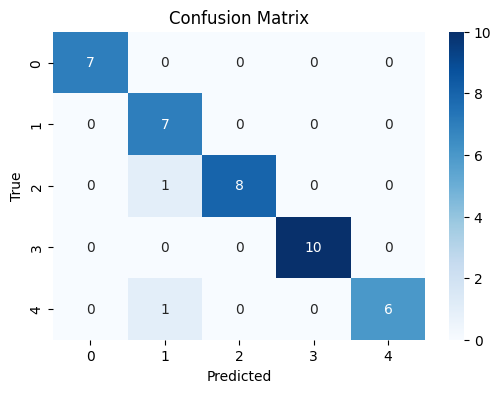

****************Validation****************

Accuracy: 0.625
Precision: 0.6753571428571429
Recall: 0.625


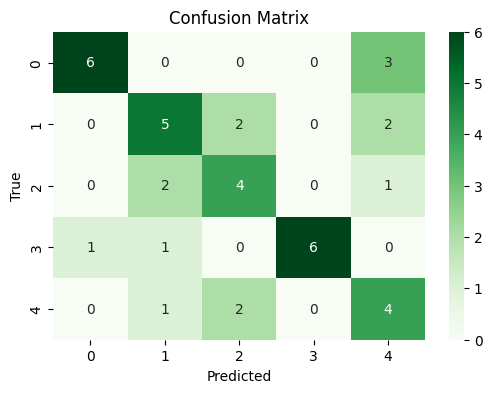

epoch 3 , Iter 400. [Val Acc 62%] [Train Acc 95%] [Train Loss 0.284146, Validation loss 1.395661]
****************Train****************

Accuracy: 0.95
Precision: 0.957142857142857
Recall: 0.95


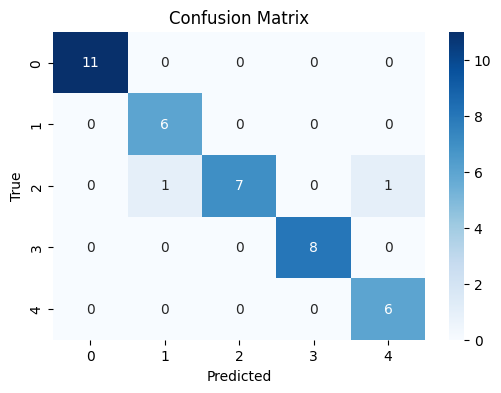

****************Validation****************

Accuracy: 0.625
Precision: 0.6460416666666666
Recall: 0.625


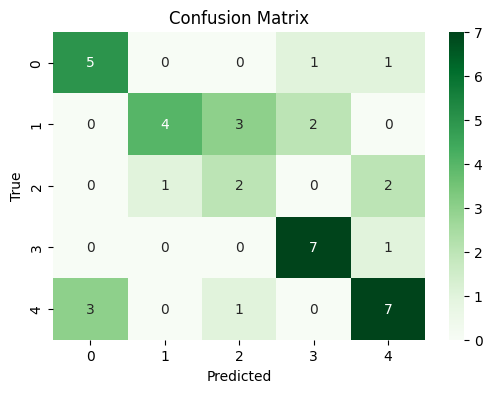

epoch 4 , Iter 500. [Val Acc 62%] [Train Acc 95%] [Train Loss 0.108819, Validation loss 1.361209]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


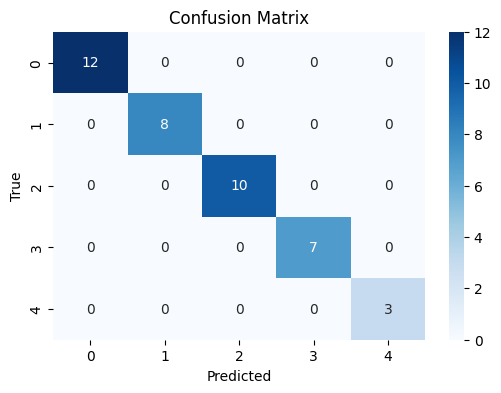

****************Validation****************

Accuracy: 0.475
Precision: 0.5075000000000001
Recall: 0.475


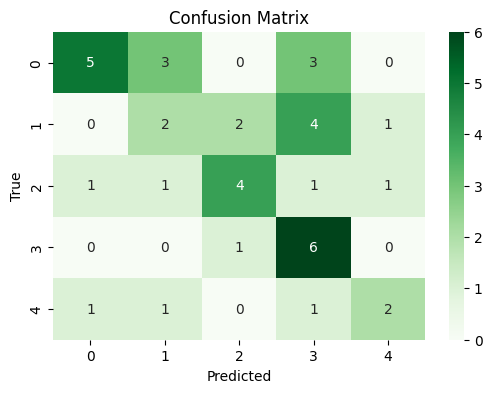

epoch 5 , Iter 600. [Val Acc 48%] [Train Acc 100%] [Train Loss 0.024189, Validation loss 1.727444]
****************Train****************

Accuracy: 0.95
Precision: 0.96
Recall: 0.95


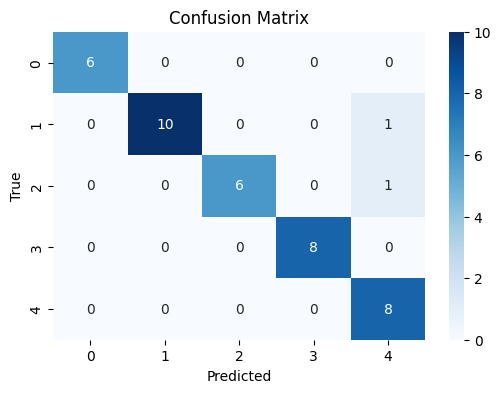

****************Validation****************

Accuracy: 0.55
Precision: 0.5707070707070707
Recall: 0.55


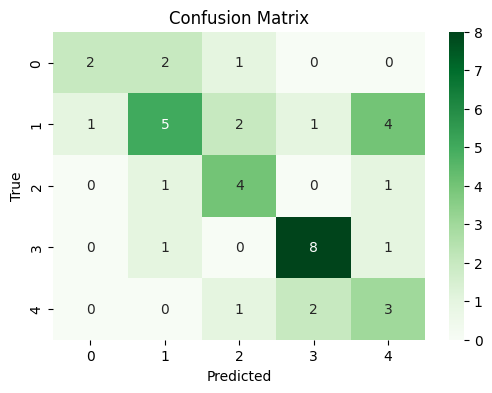

epoch 6 , Iter 700. [Val Acc 55%] [Train Acc 95%] [Train Loss 0.018669, Validation loss 1.997748]
****************Train****************

Accuracy: 0.975
Precision: 0.9800000000000001
Recall: 0.975


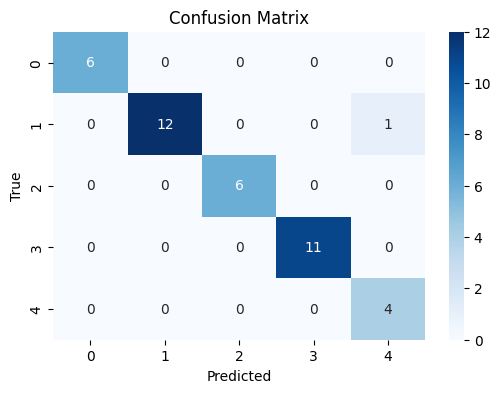

****************Validation****************

Accuracy: 0.55
Precision: 0.5724206349206349
Recall: 0.55


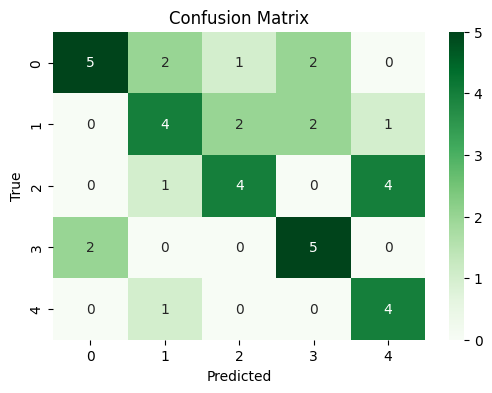

epoch 7 , Iter 800. [Val Acc 55%] [Train Acc 98%] [Train Loss 0.057209, Validation loss 2.022306]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


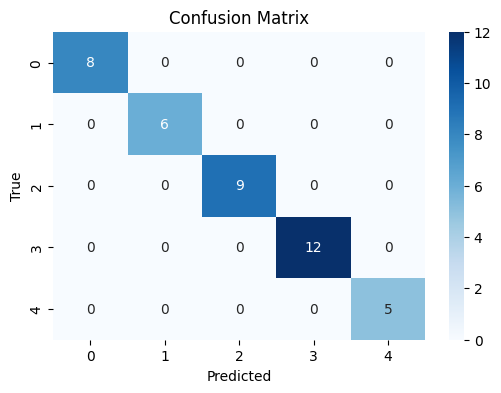

****************Validation****************

Accuracy: 0.575
Precision: 0.655681818181818
Recall: 0.575


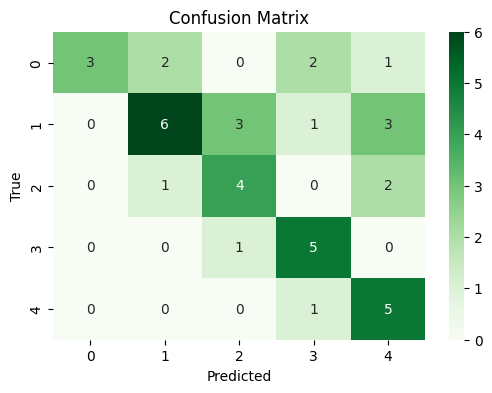

epoch 8 , Iter 900. [Val Acc 57%] [Train Acc 100%] [Train Loss 0.020205, Validation loss 1.892943]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


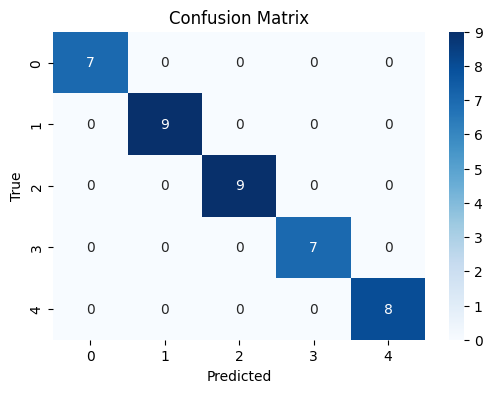

****************Validation****************

Accuracy: 0.65
Precision: 0.7165584415584416
Recall: 0.65


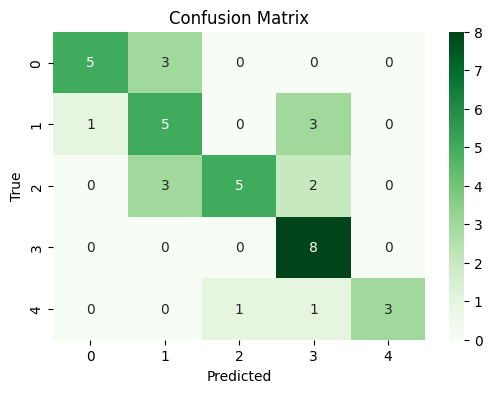

epoch 9 , Iter 1000. [Val Acc 65%] [Train Acc 100%] [Train Loss 0.037116, Validation loss 2.419496]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


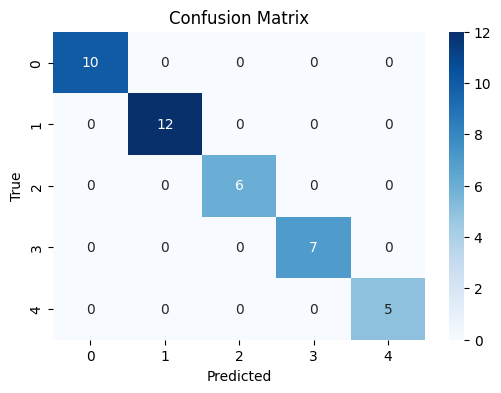

****************Validation****************

Accuracy: 0.575
Precision: 0.5985714285714285
Recall: 0.575


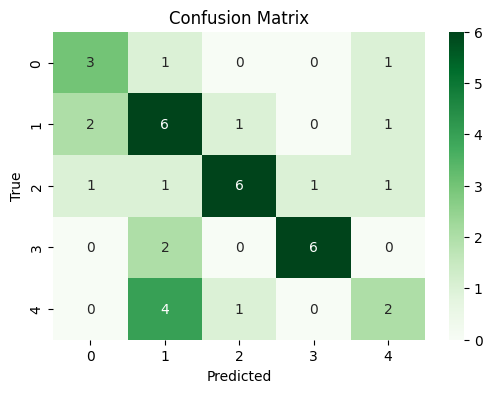

epoch 10 , Iter 1100. [Val Acc 57%] [Train Acc 100%] [Train Loss 0.021318, Validation loss 1.787972]


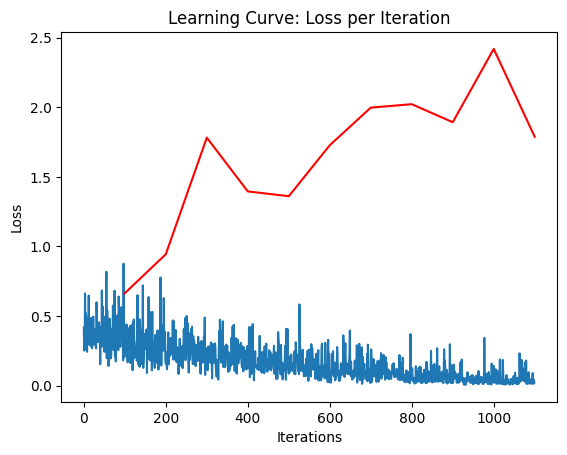

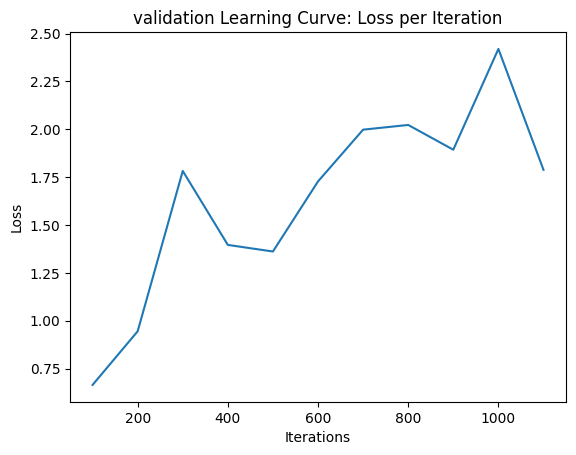

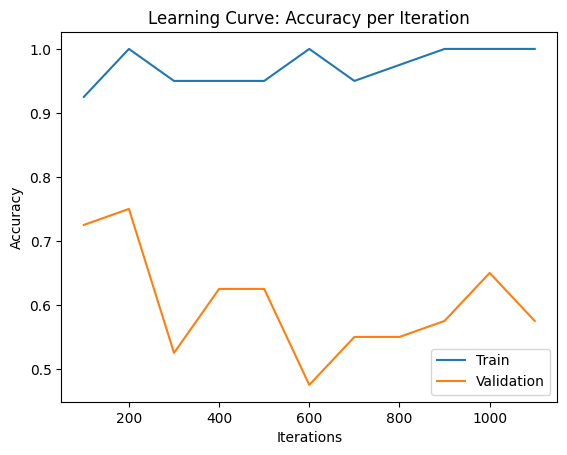

In [112]:
batch =20
m=0.00001
decay=0.001
Untrained_resnet.load_state_dict(torch.load('/content/Resnet/Weights/ckpt-1300.pk'))

learning_curve_info = run_pytorch_gradient_descent(Untrained_resnet,vt, vtst, xt,st,N_epochs=10, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Resnet/Weights2/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

****************Train****************

Accuracy: 0.875
Precision: 0.8770833333333332
Recall: 0.875


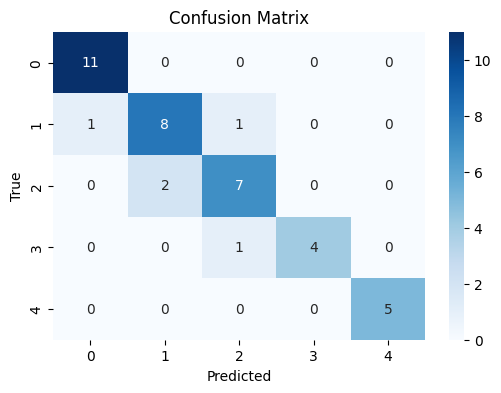

****************Validation****************

Accuracy: 0.675
Precision: 0.701590909090909
Recall: 0.675


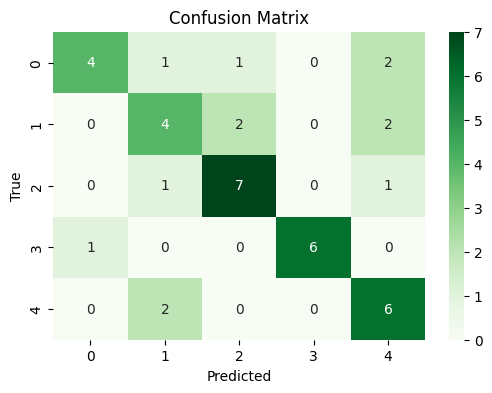

epoch 0 , Iter 100. [Val Acc 68%] [Train Acc 88%] [Train Loss 0.669244, Validation loss 0.864698]
****************Train****************

Accuracy: 0.825
Precision: 0.817063492063492
Recall: 0.825


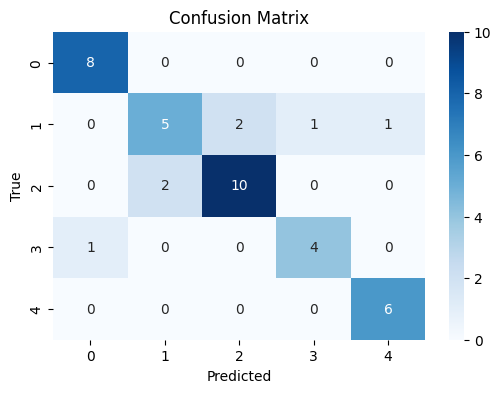

****************Validation****************

Accuracy: 0.425
Precision: 0.4321153846153846
Recall: 0.425


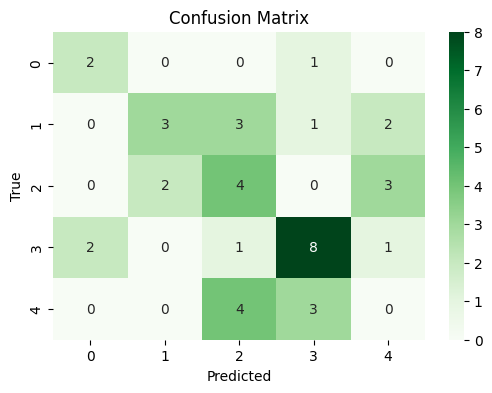

epoch 1 , Iter 200. [Val Acc 42%] [Train Acc 82%] [Train Loss 0.410468, Validation loss 1.365188]
****************Train****************

Accuracy: 0.925
Precision: 0.9275
Recall: 0.925


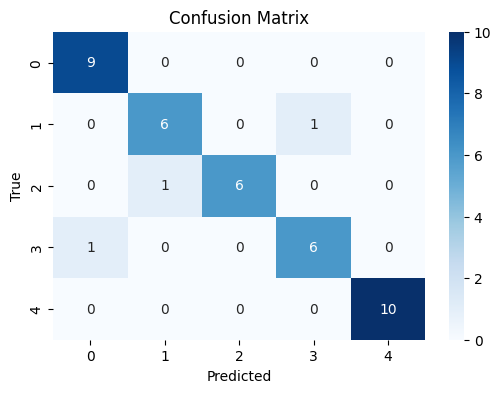

****************Validation****************

Accuracy: 0.675
Precision: 0.6805555555555556
Recall: 0.675


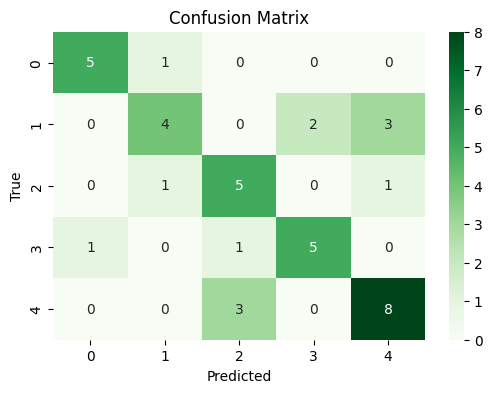

epoch 2 , Iter 300. [Val Acc 68%] [Train Acc 92%] [Train Loss 0.477714, Validation loss 1.122935]
****************Train****************

Accuracy: 0.925
Precision: 0.9239583333333334
Recall: 0.925


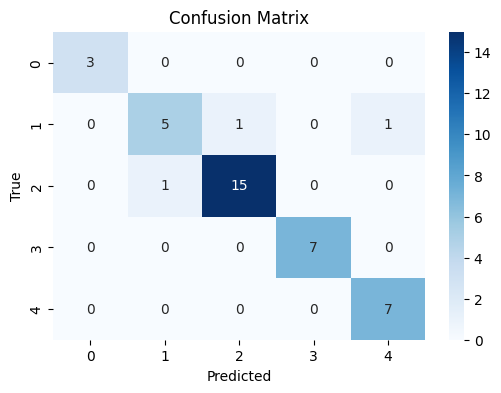

****************Validation****************

Accuracy: 0.7
Precision: 0.7117063492063492
Recall: 0.7


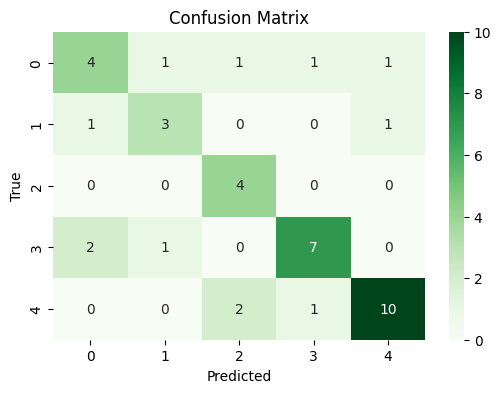

epoch 3 , Iter 400. [Val Acc 70%] [Train Acc 92%] [Train Loss 0.299072, Validation loss 0.990465]
****************Train****************

Accuracy: 0.875
Precision: 0.8947916666666667
Recall: 0.875


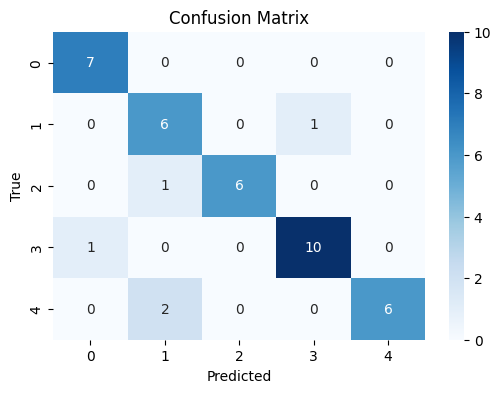

****************Validation****************

Accuracy: 0.725
Precision: 0.7809523809523808
Recall: 0.725


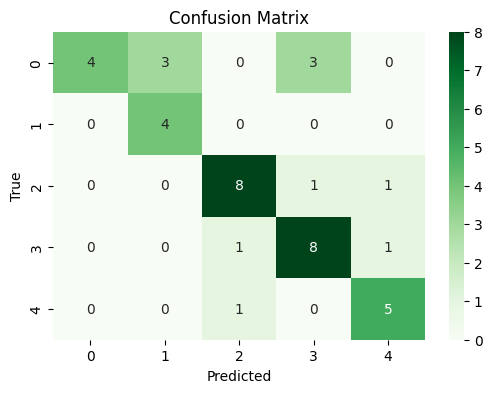

epoch 4 , Iter 500. [Val Acc 72%] [Train Acc 88%] [Train Loss 0.688467, Validation loss 0.800539]
****************Train****************

Accuracy: 0.9
Precision: 0.9162337662337663
Recall: 0.9


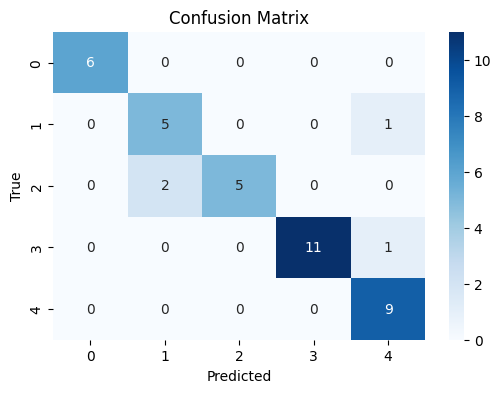

****************Validation****************

Accuracy: 0.725
Precision: 0.7479166666666667
Recall: 0.725


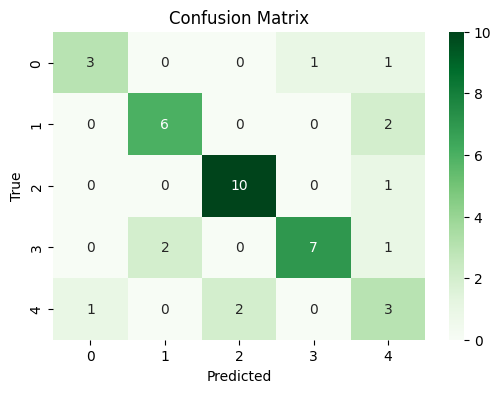

epoch 5 , Iter 600. [Val Acc 72%] [Train Acc 90%] [Train Loss 0.282924, Validation loss 0.844008]


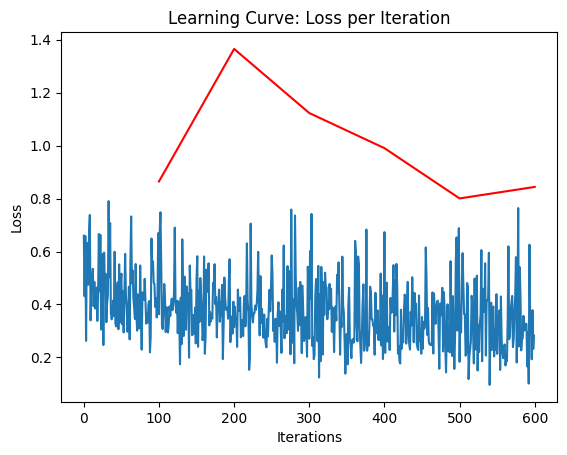

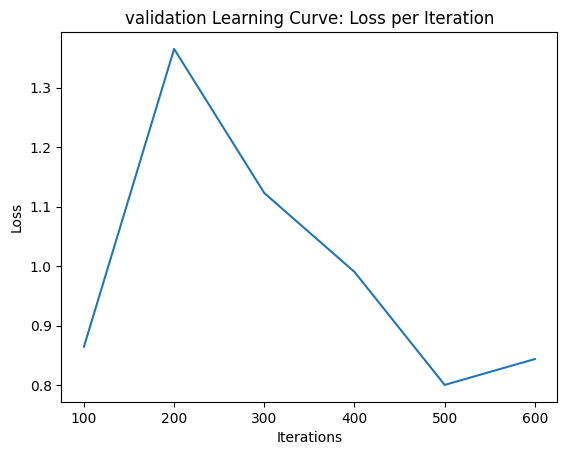

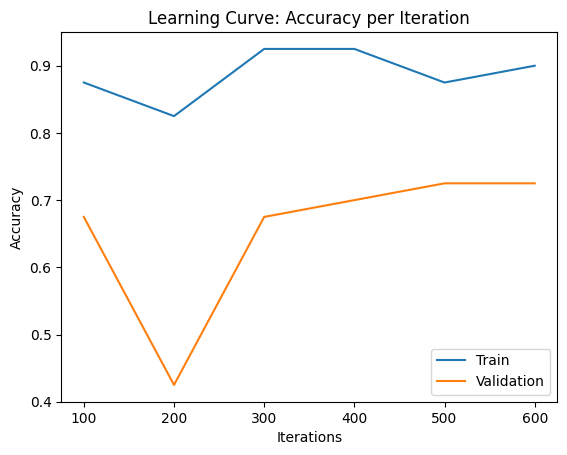

In [117]:
batch =20
m=0.000001
decay=0.001
Untrained_resnet.load_state_dict(torch.load('/content/Resnet/Weights/ckpt-1300.pk'))

learning_curve_info = run_pytorch_gradient_descent(Untrained_resnet,vt, vtst, xt,st,N_epochs=5, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Resnet/Weights3/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.6450304259634888
Precision: 0.643663233599636
Recall: 0.6450304259634888


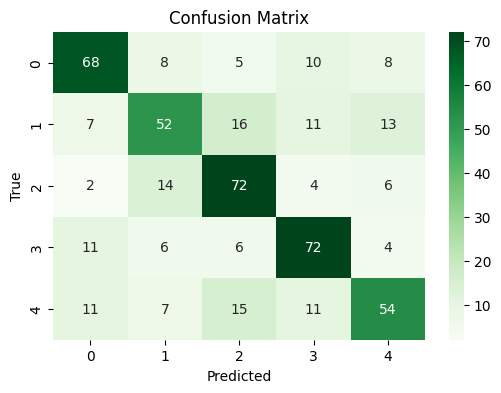

In [113]:
Untrained_resnet.load_state_dict(torch.load('/content/Resnet/Weights2/ckpt-200.pk'))
val_acc, val_loss = get_accuracy(Untrained_resnet,torch.Tensor(vt),torch.Tensor(vtst),"Greens" ,20,493)

# **Outcome Discussion and Insights**

As observed over numerous training sessions (not all documented here due to length considerations), the untrained RESNET18 achieved an accuracy rate of approximately **65%**. This leads us to consider that the architecture component may not be the primary limitation in our solution approach.

Next, we will explore a shift in our training approach by using a pretrained RESNET18.

#**6. Use *Pre*trained RESNET from torchvision.models**

Now, we will employ a **pretrained** RESNET from torchvision.models and assess its performance.
As mentioned earlier, the task at hand requires a solution composed of three integral components:

1.   Data
2.   Architecture
3.   **Training approach**

Using a pretrained RESNET model provides an opportunity to assess the training procedure. RESNET18 was pretrained on over a million images from the ImageNet database, capable of classifying images into 1000 object categories, including items such as keyboards, mice, pencils, and various animals.

The question arises: Can a model trained on diverse object categories and adapted to our specific number of classes (5 artists) perform well on our task?

#Could the prior training on different categories contribute to improved artist classification?

These considerations prompt an exploration into the **transferability of knowledge** from broader categories to our specific artistic classification problem.





In [139]:
Trained_resnet = models.resnet18(pretrained=True)
num_classes =5
# Modify fc layers to match num_classes
num_ftrs = Trained_resnet.fc.in_features
Trained_resnet.fc = nn.Linear(num_ftrs,num_classes )
Trained_resnet = Trained_resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


****************Train****************

Accuracy: 0.775
Precision: 0.7946212121212122
Recall: 0.775


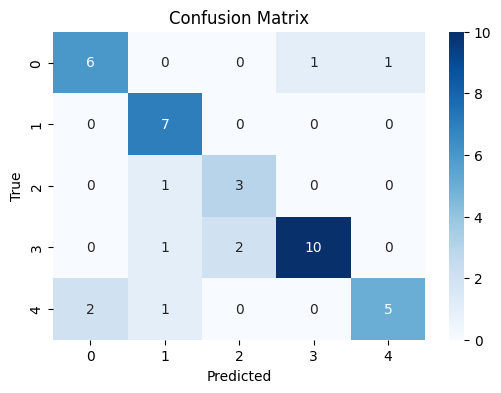

****************Validation****************

Accuracy: 0.7
Precision: 0.7086931818181819
Recall: 0.7


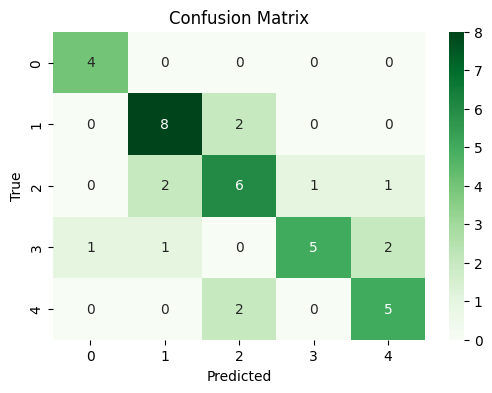

epoch 0 , Iter 100. [Val Acc 70%] [Train Acc 78%] [Train Loss 0.831450, Validation loss 0.908434]
****************Train****************

Accuracy: 0.9
Precision: 0.9392857142857143
Recall: 0.9


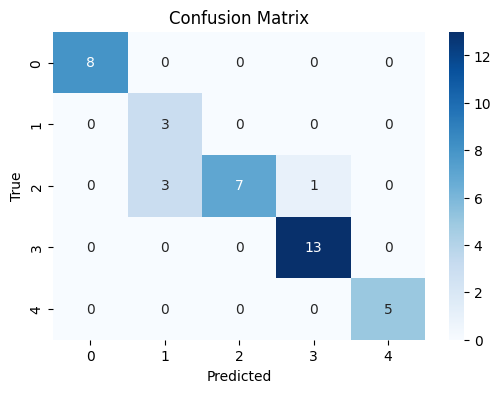

****************Validation****************

Accuracy: 0.8
Precision: 0.8351785714285714
Recall: 0.8


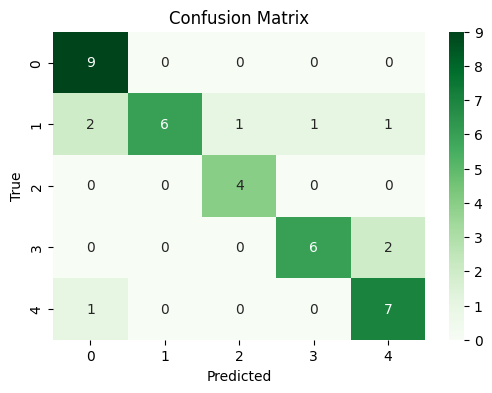

epoch 1 , Iter 200. [Val Acc 80%] [Train Acc 90%] [Train Loss 0.345959, Validation loss 0.553252]
****************Train****************

Accuracy: 0.95
Precision: 0.9576923076923076
Recall: 0.95


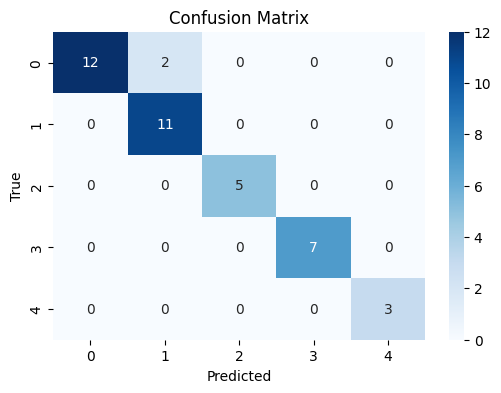

****************Validation****************

Accuracy: 0.85
Precision: 0.85375
Recall: 0.85


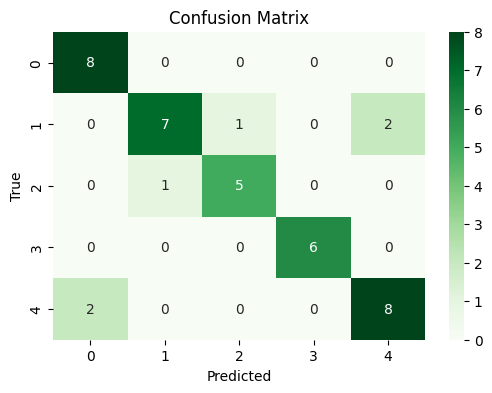

epoch 2 , Iter 300. [Val Acc 85%] [Train Acc 95%] [Train Loss 0.647996, Validation loss 0.403133]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


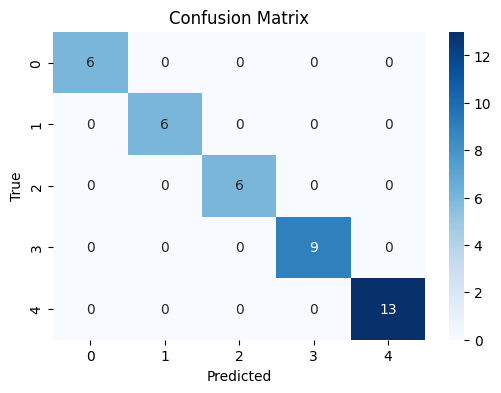

****************Validation****************

Accuracy: 0.85
Precision: 0.8747727272727273
Recall: 0.85


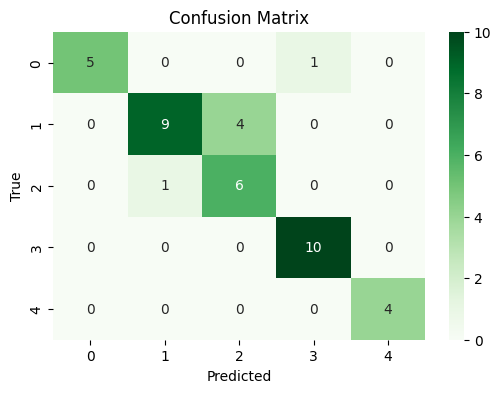

epoch 3 , Iter 400. [Val Acc 85%] [Train Acc 100%] [Train Loss 0.019169, Validation loss 0.431918]
****************Train****************

Accuracy: 0.975
Precision: 0.976923076923077
Recall: 0.975


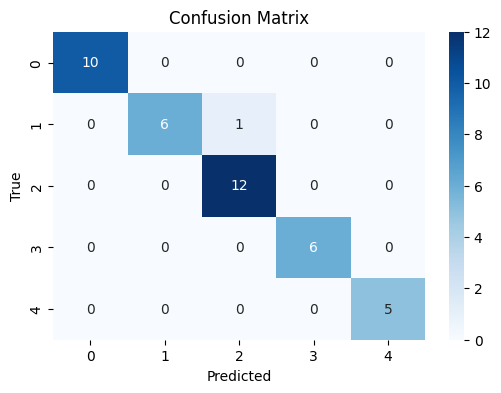

****************Validation****************

Accuracy: 0.85
Precision: 0.8685714285714287
Recall: 0.85


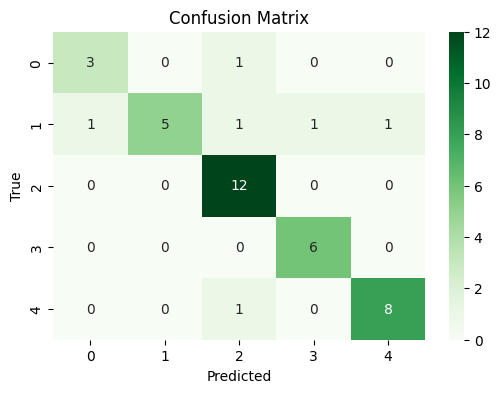

epoch 4 , Iter 500. [Val Acc 85%] [Train Acc 98%] [Train Loss 0.135301, Validation loss 0.930764]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


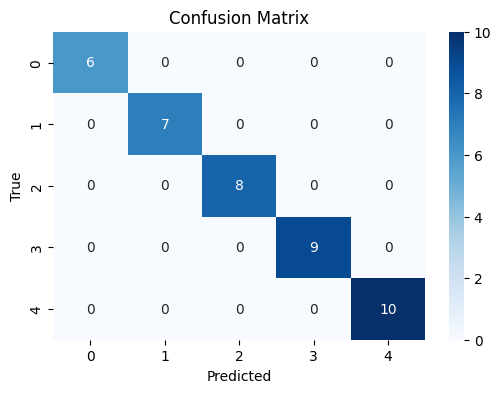

****************Validation****************

Accuracy: 0.9
Precision: 0.9099206349206348
Recall: 0.9


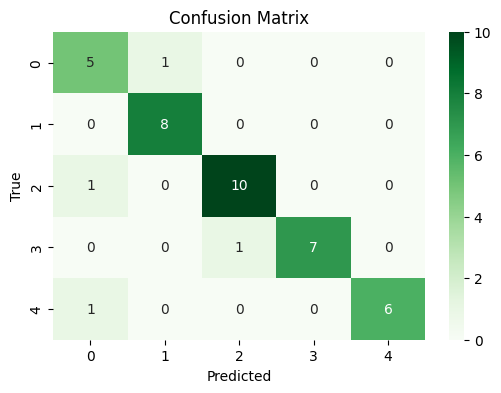

epoch 5 , Iter 600. [Val Acc 90%] [Train Acc 100%] [Train Loss 0.011724, Validation loss 0.322332]


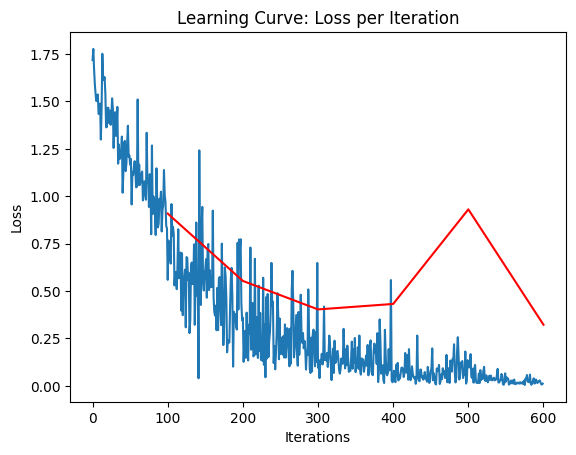

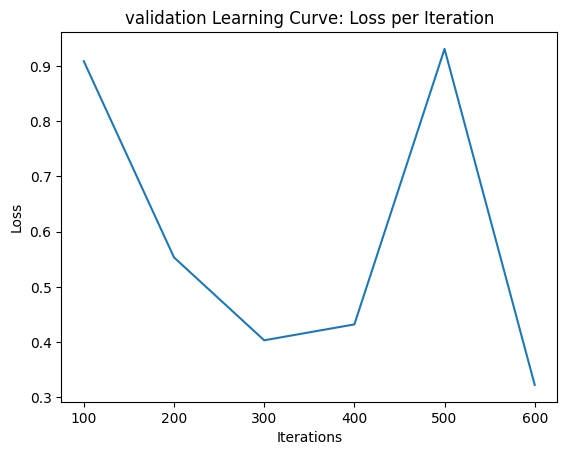

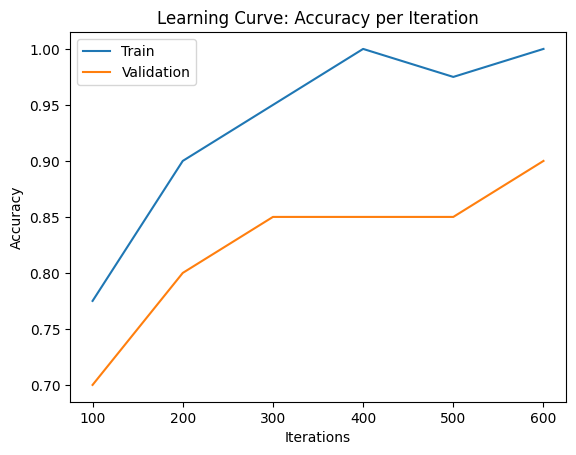

In [132]:
batch =20
m=0.00001
decay=0.0001

learning_curve_info = run_pytorch_gradient_descent(Trained_resnet,vt, vtst, xt,st,N_epochs=5, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Trained_Resnet/Weights/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.8620689655172413
Precision: 0.8622678154970256
Recall: 0.8620689655172413


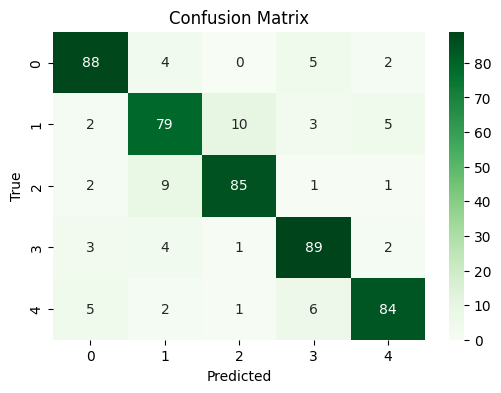

In [133]:
val_acc, val_loss = get_accuracy(Trained_resnet,torch.Tensor(vt),torch.Tensor(vtst),"Greens" ,20,493)

****************Train****************


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.25
Precision: 0.18974358974358974
Recall: 0.25


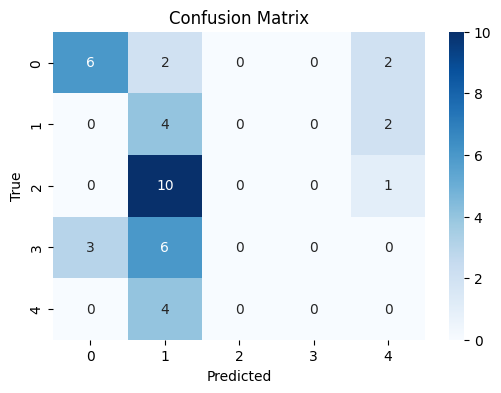

****************Validation****************

Accuracy: 0.325
Precision: 0.29100000000000004
Recall: 0.325


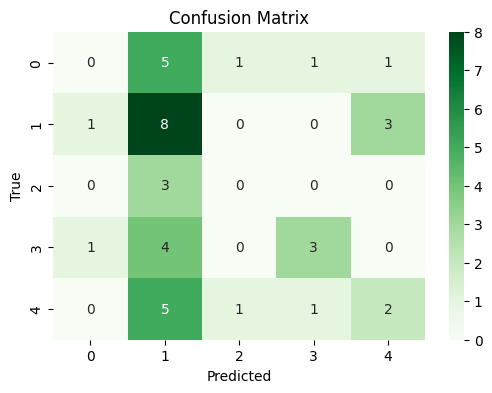

epoch 0 , Iter 100. [Val Acc 32%] [Train Acc 25%] [Train Loss 1.549385, Validation loss 1.516065]
****************Train****************

Accuracy: 0.5
Precision: 0.49416666666666664
Recall: 0.5


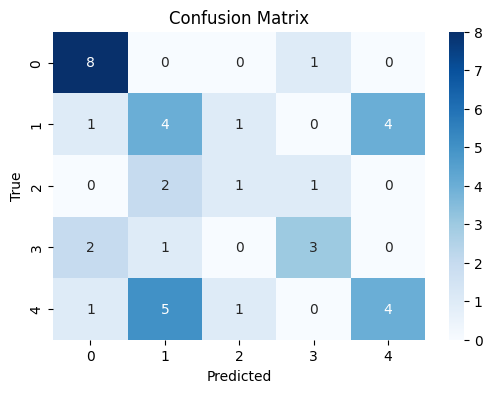

****************Validation****************

Accuracy: 0.35
Precision: 0.3763888888888889
Recall: 0.35


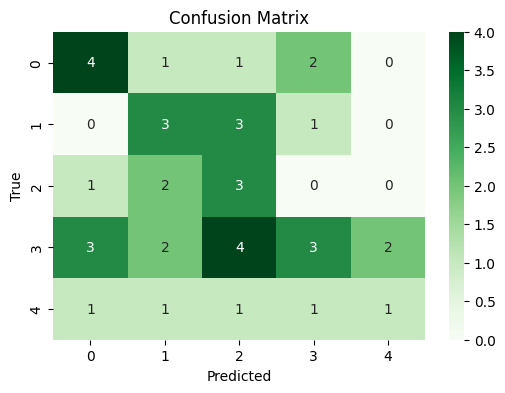

epoch 1 , Iter 200. [Val Acc 35%] [Train Acc 50%] [Train Loss 1.342478, Validation loss 1.412626]
****************Train****************

Accuracy: 0.7
Precision: 0.6672348484848485
Recall: 0.7


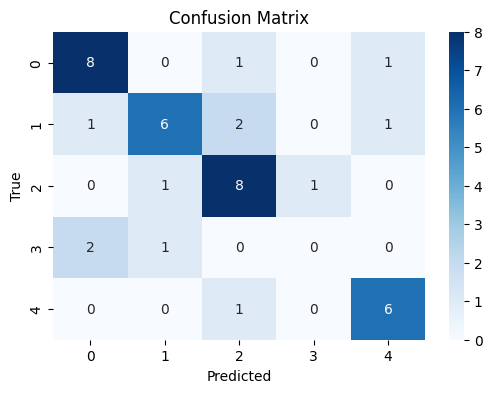

****************Validation****************

Accuracy: 0.625
Precision: 0.6741071428571429
Recall: 0.625


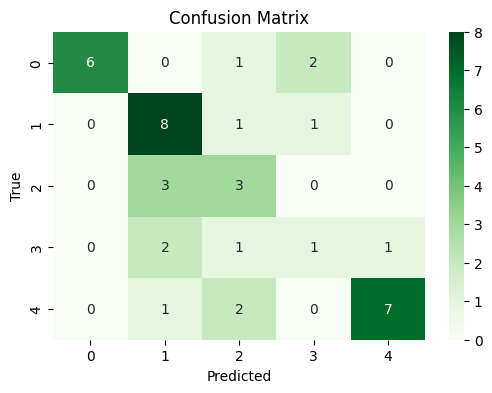

epoch 2 , Iter 300. [Val Acc 62%] [Train Acc 70%] [Train Loss 0.897321, Validation loss 1.101382]
****************Train****************

Accuracy: 0.775
Precision: 0.8023809523809524
Recall: 0.775


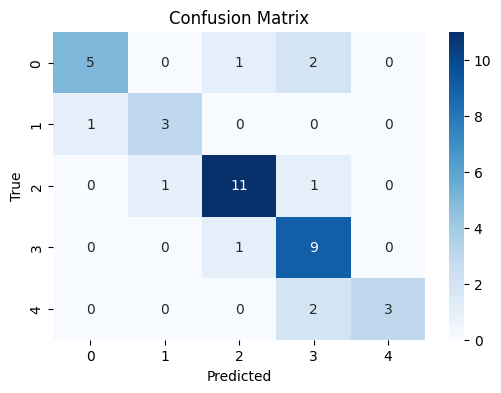

****************Validation****************

Accuracy: 0.725
Precision: 0.7618750000000001
Recall: 0.725


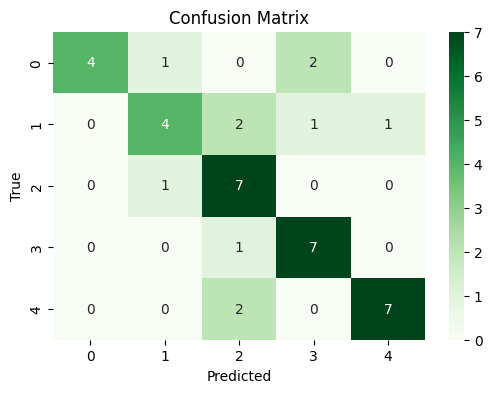

epoch 3 , Iter 400. [Val Acc 72%] [Train Acc 78%] [Train Loss 0.857536, Validation loss 0.876602]
****************Train****************

Accuracy: 0.8
Precision: 0.8006547619047619
Recall: 0.8


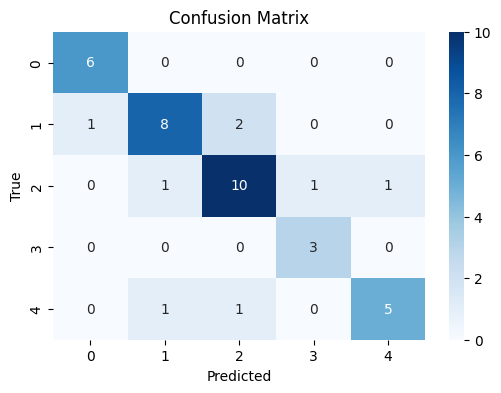

****************Validation****************

Accuracy: 0.6
Precision: 0.740625
Recall: 0.6


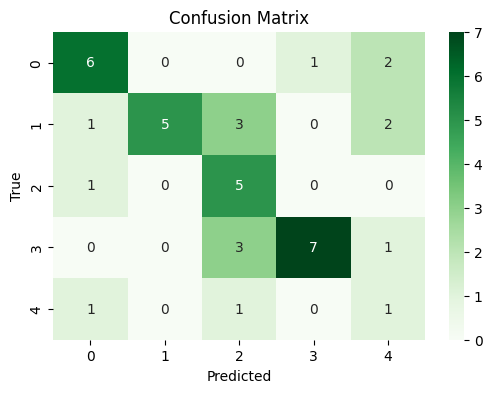

epoch 4 , Iter 500. [Val Acc 60%] [Train Acc 80%] [Train Loss 0.381793, Validation loss 0.934375]
****************Train****************

Accuracy: 0.775
Precision: 0.8037202380952382
Recall: 0.775


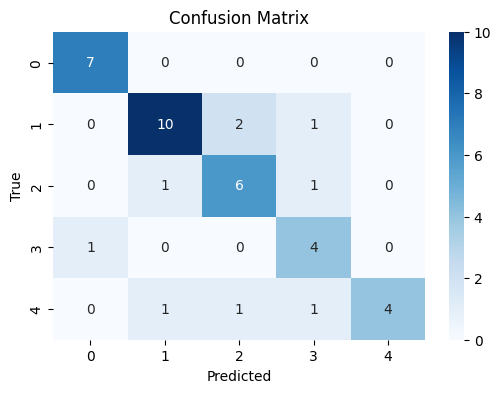

****************Validation****************

Accuracy: 0.825
Precision: 0.8516666666666666
Recall: 0.825


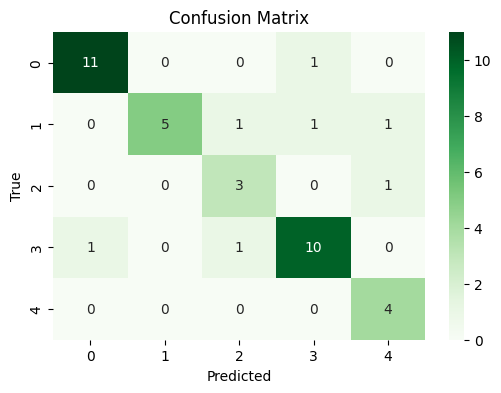

epoch 5 , Iter 600. [Val Acc 82%] [Train Acc 78%] [Train Loss 1.092988, Validation loss 0.651306]


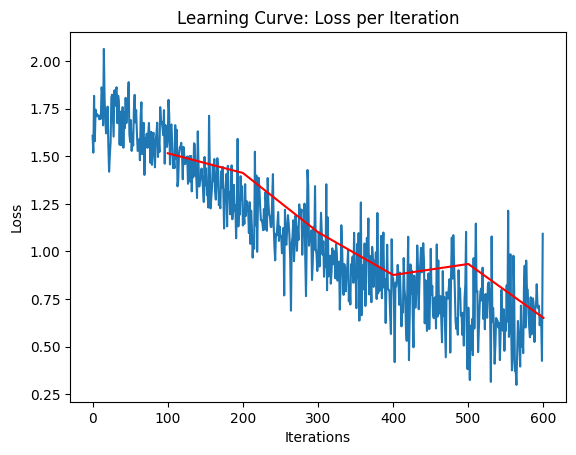

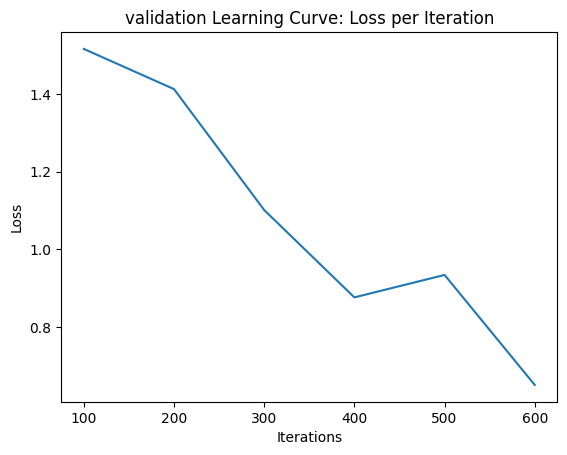

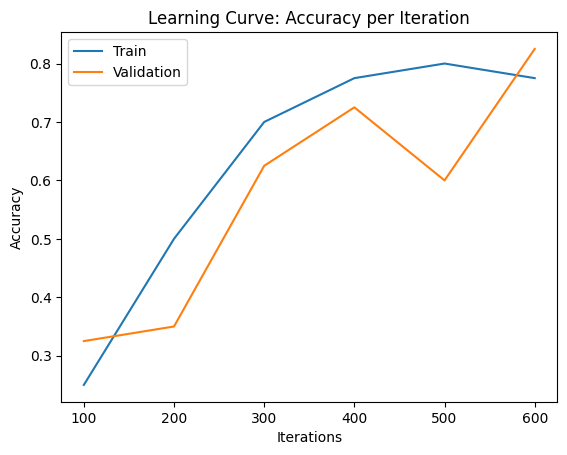

In [135]:
batch =20
m=0.000001
decay=0.0001

learning_curve_info = run_pytorch_gradient_descent(Trained_resnet,vt, vtst, xt,st,N_epochs=5, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Trained_Resnet/Weights2/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)

# Another Attempt
reload pretrained ResNet18 from torchvision.models and reloanch training.

****************Train****************

Accuracy: 0.625
Precision: 0.6956818181818182
Recall: 0.625


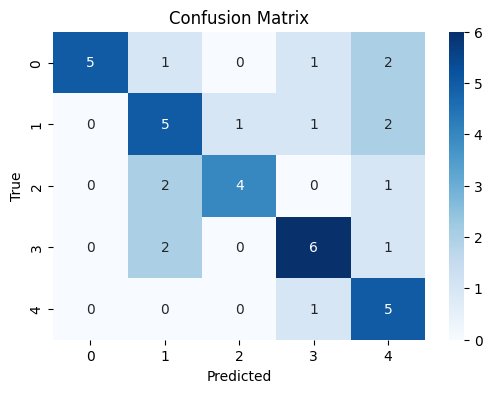

****************Validation****************

Accuracy: 0.725
Precision: 0.7622222222222221
Recall: 0.725


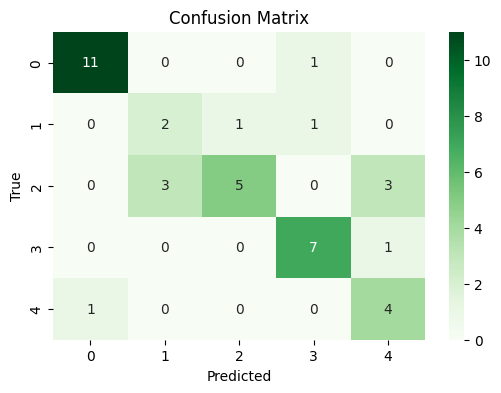

epoch 0 , Iter 67. [Val Acc 72%] [Train Acc 62%] [Train Loss 1.090313, Validation loss 0.904277]
****************Train****************

Accuracy: 0.85
Precision: 0.8533630952380953
Recall: 0.85


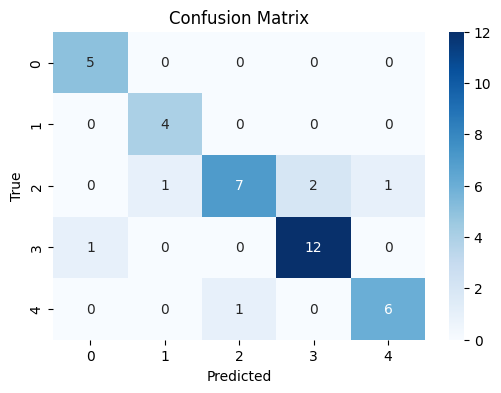

****************Validation****************

Accuracy: 0.9
Precision: 0.9173076923076924
Recall: 0.9


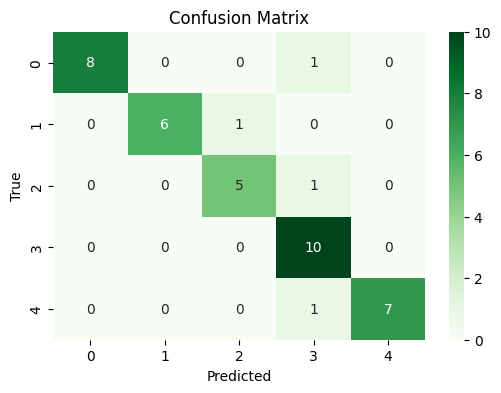

epoch 1 , Iter 134. [Val Acc 90%] [Train Acc 85%] [Train Loss 0.432240, Validation loss 0.313473]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


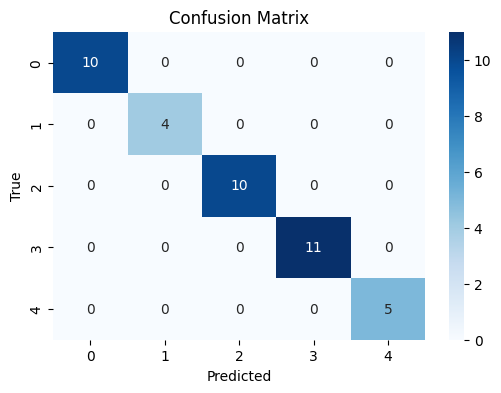

****************Validation****************

Accuracy: 0.825
Precision: 0.8438492063492063
Recall: 0.825


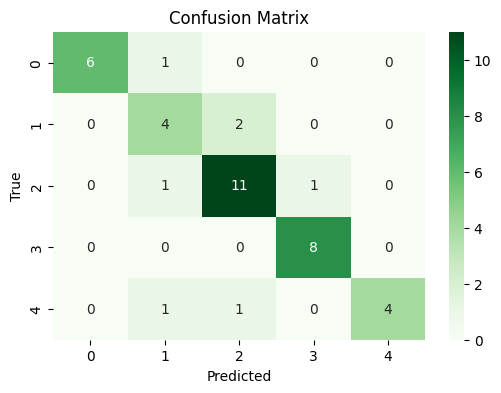

epoch 2 , Iter 201. [Val Acc 82%] [Train Acc 100%] [Train Loss 0.170284, Validation loss 0.482593]
****************Train****************

Accuracy: 0.925
Precision: 0.9349999999999999
Recall: 0.925


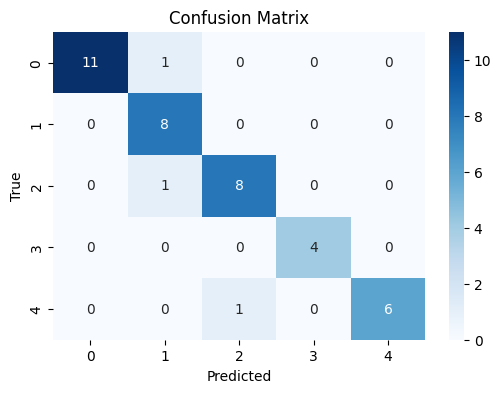

****************Validation****************

Accuracy: 0.725
Precision: 0.8295454545454545
Recall: 0.725


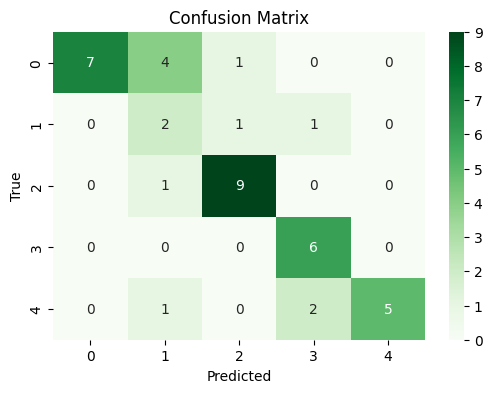

epoch 3 , Iter 268. [Val Acc 72%] [Train Acc 92%] [Train Loss 0.193779, Validation loss 0.903602]
****************Train****************

Accuracy: 0.975
Precision: 0.9785714285714284
Recall: 0.975


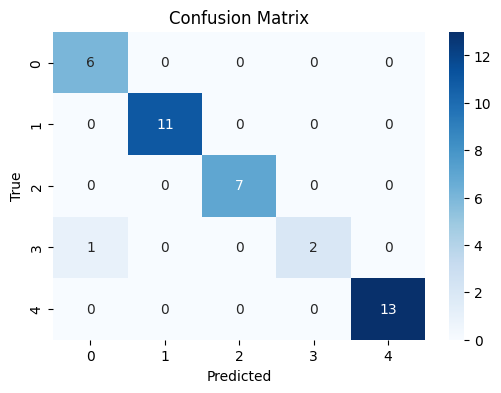

****************Validation****************

Accuracy: 0.9
Precision: 0.9171130952380953
Recall: 0.9


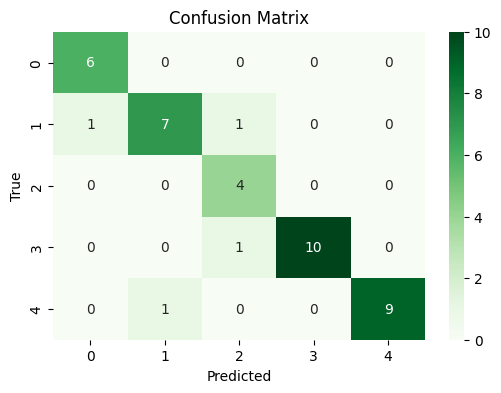

epoch 4 , Iter 335. [Val Acc 90%] [Train Acc 98%] [Train Loss 0.282144, Validation loss 0.355653]
****************Train****************

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


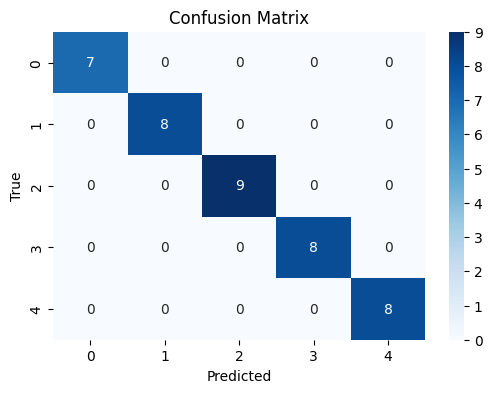

****************Validation****************

Accuracy: 0.875
Precision: 0.8829545454545455
Recall: 0.875


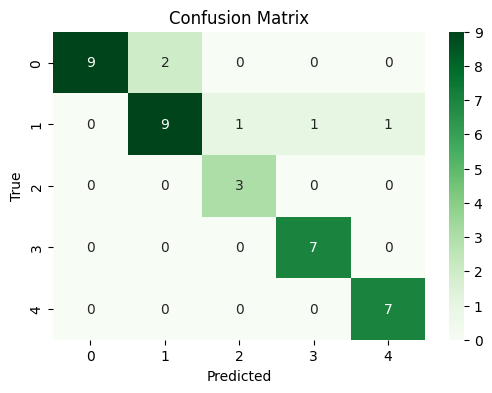

epoch 5 , Iter 402. [Val Acc 88%] [Train Acc 100%] [Train Loss 0.097847, Validation loss 0.476626]


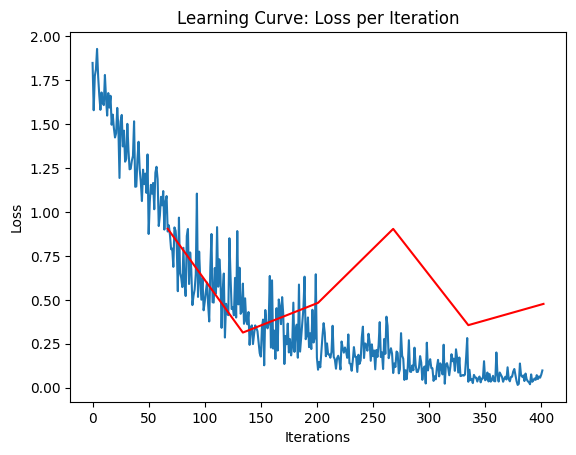

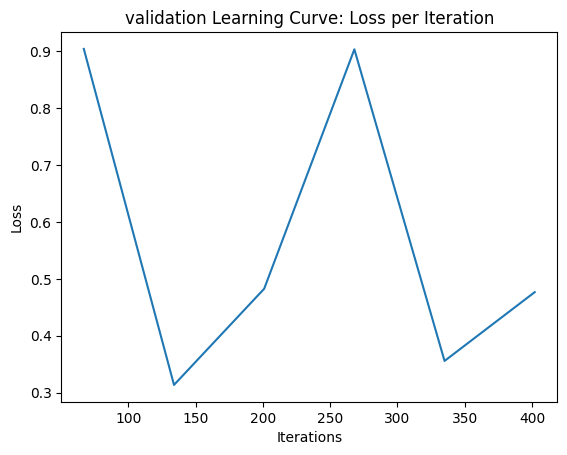

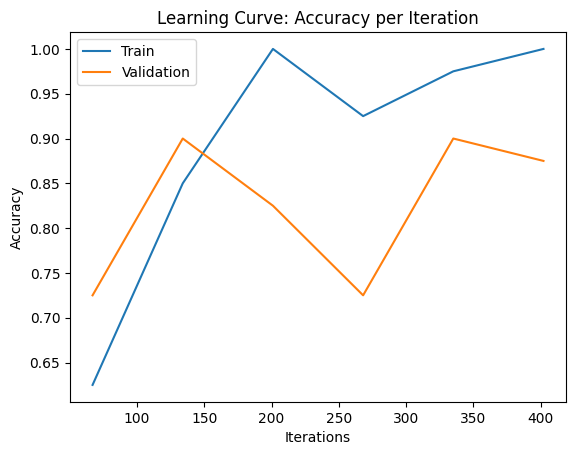

In [140]:
batch =30
m=0.00001
decay=0.0001

learning_curve_info = run_pytorch_gradient_descent(Trained_resnet,vt, vtst, xt,st,N_epochs=5, batch_size=batch,
                                  learning_rate=m,
                                  weight_decay=decay, beta1=0.9, beta2=0.999,
                                  checkpoint_path='/content/Trained_Resnet/Weights4/ckpt-{}.pk')

plot_learning_curve(*learning_curve_info)


Accuracy: 0.8417849898580122
Precision: 0.8422811021807347
Recall: 0.8417849898580122


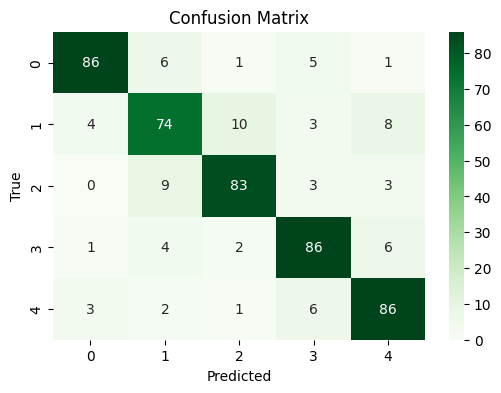

In [141]:
val_acc, val_loss = get_accuracy(Trained_resnet,torch.Tensor(vt),torch.Tensor(vtst),"Greens" ,20,493)

# Pretrained ResNet18 Final Accuracy Rate of 86% Demonstration


Accuracy: 0.8620689655172413
Precision: 0.8622678154970256
Recall: 0.8620689655172413


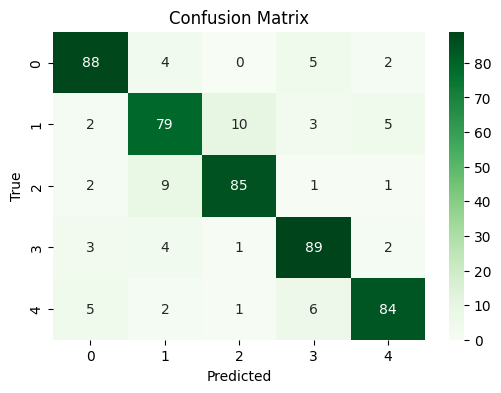

In [145]:
Trained_resnet.load_state_dict(torch.load('/content/Trained_Resnet/Weights/ckpt-600.pk'))
val_acc, val_loss = get_accuracy(Trained_resnet,torch.Tensor(vt),torch.Tensor(vtst),"Greens" ,20,493)

# **Outcome Discussion and Insights**

As we can see from the results, the pretrained ResNet18 has reached an accuracy rate of **86%** !

This was achieved after a short training session.

This is ***an improvement of more than 20%*** compared to all the other models; Arti and the untrained ResNet at maximum **65%** accuracy rate.

epoch 5 , Iter 600. [Val Acc 90%] [Train Acc 100%] [Train Loss 0.011724, Validation loss 0.322332]
_________________

# Prior training on different categories **can** contribute to improved artist classification !

# ***It appears it is indeed possible to transfer knowledge and intelligence from different tasks !***

Even though we have a relatively small dataset for our task (500 images for each artist), we can still pretrain the model on different object categories to achieve improved performance.

This conclusion, in my opinion, is not conventional. To me, it opens up a new approach for training neural networks and handling tasks with small datasets.

#You don't have to be confined to your task's original dataset to enhance your network's starting point of intelligence. You can explore the entire world and experiment with other data categories to see how they can benefit your task.

# **PROJECT SUMMARY**

In this project, I attempted to train neural networks for classifying paintings by five Impressionist painters: Camille Pissarro, Claude Monet, Henri Matisse, John Singer-Sargent, and Vincent van Gogh.

I compared four neural network models:

1.   A simple CNN named 'Arti' (accuracy rate of **65%**)
2.   A simple CNN with dropout and layer normalization called 'Dropi' (accuracy rate of **55%**)
3.   ResNet18 (not pretrained) (accuracy rate of **65%**)
4.   Pretrained ResNet18 (accuracy rate of **86%**)

The primary challenge was rapid overfitting during training, prompting me to experiment with complexifying the CNN architectures and incorporating dropout and layer normalization. However, these modifications did not yield improvements beyond the maximum accuracy rate of 65%.

To further explore, I thought of comparing my architecture to a state-of-the-art (SOTA) architecture, ResNet18 from torchvision.models. Initially using an untrained ResNet18, I reached the same maximum accuracy rate of 65% after extensive training sessions.

Then I employed the pretrained version of ResNet18, which performed significantly better, achieving an 86% accuracy rate — a 20% improvement compared to all other models. ***This outcome suggests that prior training on diverse categories can indeed enhance artist classification, demonstrating the possibility of transferring knowledge and intelligence across different tasks.***

The ***key insight*** from this project is that you don't have to be confined to your task's original dataset to enhance your network's starting point of intelligence. You can explore the entire world and experiment with other data categories to see how they can benefit your task.
